<a href="https://colab.research.google.com/github/AlvaroNegromonte/ECG-Anomalies-Detection/blob/main/Projeto_Sinais_2025_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Anomalias Cardiológicas em ECC ~ Grupo 2
######Vinícius de Sousa Rodrigues (vsr)
######Álvaro Cavalcante Negromonte (acn3)
######Júlio César Barbosa da Silva (jcbs3)
######Luiz Felipe Silva Lustosa (lfsl)
######Felipe Torres de Macedo (ftm2)
######Edinaldo Filho (ebcf2)

# **Problemas cardiológicos selecionados**

O modelo será treinado para reconhecer três condições distintas nos registros de ECG da base PTB-XL:

- Infarto Agudo do Miocárdio (MI)

  - Condição grave com alterações claras na morfologia do complexo QRS e segmento ST.

- Batimento Cardíaco Anormal (Abnormal Heartbeat – Abn-HB)

  - Irregularidades no ritmo cardíaco, incluindo extrassístoles, fibrilações e taquiarritmias.

- ECG Normal (NORM)

  - Representa pacientes saudáveis, sem evidências de anomalias eletrocardiográficas.
  
A inclusão da classe “normal” é essencial para permitir que o modelo aprenda a distinguir padrões fisiológicos normais de padrões patológicos. Isso garante completude diagnóstica e redução de falsos positivos, além de estar em conformidade com a especificação oficial do projeto: “diagnóstico de anomalias cardiológicas e também coração normal”.

---
# **Preparando dataset**

In [ ]:
#https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset

In [ ]:
!pip3 install pydub
!pip3 install ffmpeg-downloader
!pip3 install wfdb pandas==2.2.2

INFO: pip is looking at multiple versions of wfdb to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
import zipfile
import random
import wfdb
import ast
import shutil
from shutil import copyfile
from google.colab import files
from pydub import AudioSegment
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Garantir estabilidade das amostras e escabilidade

In [ ]:
import numpy as np
import random
import tensorflow as tf
import os

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


### Importing Dataset from Kaggle

In [ ]:
#upload kaggle API Token
# Tutorial to get Kaggle API Token : https://www.kaggle.com/discussions/general/74235
# just the step 1 and 2
# upload the json file downloaded here
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luizfsl","key":"3373fc72c1e572d1d6f699e3f8c7b82d"}'}

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 63 Aug 15 19:48 kaggle.json
/content


In [ ]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

Dataset URL: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 1.67G/1.72G [00:10<00:01, 40.9MB/s]
100% 1.72G/1.72G [00:10<00:00, 179MB/s] 


In [ ]:
!unzip -o ptb-xl-dataset.zip -d /content/ptb-xl-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: /content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341

In [ ]:
!rm ptb-xl-dataset.zip

In [ ]:
!mkdir splited_dataset

---
## **Processamento da Base PTB-XL**

### Tratamento dos dados

Essa primeira etapa realiza a importação, organização, balanceamento e salvamento dos dados do dataset [PTB-XL](https://physionet.org/content/ptb-xl/1.0.3/), uma base pública de eletrocardiogramas, incluindo exames com infarto (MI), batimentos anormais (Abn-HB) e normalidade (NORM)
- Feitos do código abaixo:
    1. Importa os metadados do arquivo ptbxl_database.csv
    2. Classifica os exames em três categorias clínicas:
      - MI: Infarto do miocárdio (com base nos códigos SCP)
      - Abn-HB: Batimentos anormais (como PVC, LBBB, PAC)
      - NORM: Eletrocardiogramas normais
    3. Seleciona uma amostra balanceada com até 100 exames por classe
    4. Carrega os sinais de ECG brutos (500 Hz) usando o wfdb
    5. Salva os sinais e rótulos como arquivos .npy em data_preprocessed/

- Saídas:
    1. `data_preprocessed/X_signals.npy`: Lista de sinais ECG brutos (array de objetos NumPy)
    2. `data_preprocessed/y_labels.npy`: Lista de rótulos (MI, Abn-HB, NORM)

In [ ]:
# Caminho base do dataset do Kaggle (descompactado)
BASE_DIR = '/content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'
RECORDS_PATH = os.path.join(BASE_DIR, 'records500')  # ou 'records100'
METADATA_CSV = os.path.join(BASE_DIR, 'ptbxl_database.csv')
SCP_STATEMENTS_CSV = os.path.join(BASE_DIR, 'scp_statements.csv')
DATA_OUT_PATH = '/content/splited_dataset'

os.makedirs(DATA_OUT_PATH, exist_ok=True)

def load_metadata():
    df = pd.read_csv(METADATA_CSV)
    df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
    return df

def extract_labels(df):
    scp_df = pd.read_csv(SCP_STATEMENTS_CSV, index_col=0)
    mi_scp_codes = scp_df[scp_df['diagnostic_class'] == 'MI'].index.tolist()
    abn_scp_codes = ['ABQRS', 'PVC', 'PAC', 'LBBB', 'RBBB', 'IRBBB']

    def map_label(codes):
        labels = list(codes.keys())
        if any(label in mi_scp_codes for label in labels):
            return 'MI'
        elif any(label in abn_scp_codes for label in labels):
            return 'Abn-HB'
        elif 'NORM' in labels:
            return 'NORM'
        else:
            return None

    df['target'] = df['scp_codes'].apply(map_label)
    return df[df['target'].notnull()]

def load_signal(record_path):
    full_path = os.path.join(BASE_DIR, record_path)
    signal, _ = wfdb.rdsamp(full_path)
    return signal

def load_dataset_balanced(sample_limit_per_class=100):
    df = extract_labels(load_metadata())

    dfs = []
    for class_name in ['MI', 'Abn-HB', 'NORM']:
        df_class = df[df['target'] == class_name]
        available = len(df_class)
        if available == 0:
            print(f"Classe '{class_name}' indisponível.")
            continue
        n = min(sample_limit_per_class, available)
        print(f"Classe '{class_name}': usando {n} de {available} disponíveis.")
        dfs.append(df_class.sample(n=n, random_state=42))

    df_sampled = pd.concat(dfs).sample(frac=1, random_state=42)

    X_signals = []
    y_labels = []

    print(f"\nCarregando {len(df_sampled)} sinais...")

    for _, row in df_sampled.iterrows():
        try:
            signal = load_signal(row['filename_hr'])  # arquivos .hea/.dat
            X_signals.append(signal)
            y_labels.append(row['target'])
        except Exception as e:
            print(f"Erro ao carregar {row['filename_hr']}: {e}")

    return np.array(X_signals, dtype=np.float32), np.array(y_labels)

def save_dataset(X, y):
    np.save(os.path.join(DATA_OUT_PATH, 'X_signals.npy'), X)
    np.save(os.path.join(DATA_OUT_PATH, 'y_labels.npy'), y)
    print(f"\nDados salvos em: {DATA_OUT_PATH}")
    print(f"   - {len(X)} sinais")
    print(f"   - Distribuição: {dict(zip(*np.unique(y, return_counts=True)))}")

# EXECUÇÃO PRINCIPAL
X, y = load_dataset_balanced(sample_limit_per_class=350)
save_dataset(X, y)

dff = load_metadata()
dff = extract_labels(dff)
print("\nDistribuição de classes (conjunto total):")
print(dff['target'].value_counts())

Classe 'MI': usando 350 de 5486 disponíveis.
Classe 'Abn-HB': usando 350 de 2223 disponíveis.
Classe 'NORM': usando 350 de 8762 disponíveis.

Carregando 1050 sinais...

Dados salvos em: /content/splited_dataset
   - 1050 sinais
   - Distribuição: {np.str_('Abn-HB'): np.int64(350), np.str_('MI'): np.int64(350), np.str_('NORM'): np.int64(350)}

Distribuição de classes (conjunto total):
target
NORM      8762
MI        5486
Abn-HB    2223
Name: count, dtype: int64


---
### Visualização dos arquivos gerados

#### Arquivo X_signals

In [ ]:
X = np.load('/content/splited_dataset/X_signals.npy', allow_pickle=True)

print(type(X))                 # <class 'numpy.ndarray'>
print(X.shape)
print(X[0].shape)              # (5000, 12)  ← 5000 amostras, 12 derivações
print(X[0])                    # mostra o sinal do primeiro exame


<class 'numpy.ndarray'>
(1050, 5000, 12)
(5000, 12)
[[-0.095 -0.03   0.065 ... -0.065 -0.055 -0.055]
 [-0.095 -0.03   0.065 ... -0.065 -0.055 -0.055]
 [-0.095 -0.03   0.065 ... -0.065 -0.055 -0.055]
 ...
 [-0.07   0.03   0.1   ... -0.045 -0.03  -0.04 ]
 [-0.07   0.03   0.1   ... -0.045 -0.03  -0.04 ]
 [-0.07   0.03   0.1   ... -0.045 -0.03  -0.04 ]]


- Formato: cada elemento do array é um sinal ECG de um exame, carregado a partir dos arquivos .dat e .hea.
- Dimensão de cada item: (n_amostras, n_derivações), geralmente (5000, 12) para 10 segundos de ECG a 500 Hz com 12 derivações.
- Tamanho do array: 350 por classe (3 classes: MI, Abn-HB, NORM), então o total é 300 sinais

---
#### Arquivo y_signals

In [ ]:
y = np.load('/content/splited_dataset/y_labels.npy', allow_pickle=True)

print(type(y))         # <class 'numpy.ndarray'>
print(y.shape)         # (1050,)
print(np.unique(y))    # ['Abn-HB' 'MI' 'NORM']
print(y[0])            # rótulo do primeiro sinal em X

<class 'numpy.ndarray'>
(1050,)
['Abn-HB' 'MI' 'NORM']
Abn-HB


- Tipo: numpy.ndarray de strings
- Formato: vetor unidimensional com o rótulo correspondente a cada sinal em X_signals.npy.
- Valores possíveis: 'MI', 'Abn-HB', 'NORM'

---
#**Pré-processamento dos sinais**

Nessa etapa, implementaremos as estratégias de pré-processamento:

1. Filtro passa-faixa (0.5 – 40 Hz), que realiza a remoção da interferência elétrica e ruído de baixa frequência;
2. Normalização por Z-score, que padroniza os sinais para torná-los comparáveis entre pacientes;

Esse pré-processamento padroniza a entrada dos extratores, minimiza variações indesejadas e melhora a robustez do modelo.


In [ ]:
import scipy.signal as signal
from tqdm import tqdm

#Caminhos corrigidos para Colab + pasta 'splited_dataset'
DATA_DIR = '/content/splited_dataset'  # Caminho absoluto no Colab

X_INPUT_PATH = os.path.join(DATA_DIR, 'X_signals.npy')     # Sinais brutos
Y_INPUT_PATH = os.path.join(DATA_DIR, 'y_labels.npy')      # Rótulos

X_OUTPUT_PATH = os.path.join(DATA_DIR, 'X_filtered.npy')   # Sinais processados
Y_OUTPUT_PATH = os.path.join(DATA_DIR, 'y_filtered.npy')   # Rótulos (sem alteração)


# Parâmetros do filtro passa-banda
LOWCUT = 0.5       # Frequência mínima (Hz)
HIGHCUT = 40.0     # Frequência máxima (Hz)
FS = 500           # Frequência de amostragem dos sinais do PTB-XL (500 Hz)

# Comprimento fixo desejado para os sinais (número de amostras)
FIXED_LENGTH = 5000  # 10 segundos a 500 Hz

# Função para aplicar filtro passa-banda em um único canal
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs                  # Frequência de Nyquist
    low = lowcut / nyquist              # Normaliza freq. mínima
    high = highcut / nyquist            # Normaliza freq. máxima
    b, a = signal.butter(order, [low, high], btype='band')  # Coeficientes do filtro
    return signal.filtfilt(b, a, data)  # Aplica o filtro (zero-phase)

# Função para normalização z-score por canal (zero média, desvio 1)
def normalize_zscore(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:                        # Evita divisão por zero
        return signal
    return (signal - mean) / std

# Garante que cada sinal tenha o mesmo comprimento (padding ou truncamento)
def pad_or_crop(signal, target_len):
    if signal.shape[0] > target_len:
        return signal[:target_len]  # Trunca se for maior
    elif signal.shape[0] < target_len:
        pad_width = target_len - signal.shape[0]
        return np.pad(signal, ((0, pad_width), (0, 0)), 'constant')  # Preenche com zeros
    else:
        return signal  # Já tem o tamanho certo

# Função principal de pré-processamento
def preprocess_dataset(X):
    X_filtered = []
    print("Pré-processando os sinais...")
    for signal_ecg in tqdm(X):  # Aplica para cada amostra
        # 1. Ajusta o comprimento (truncamento ou padding)
        signal_fixed = pad_or_crop(signal_ecg, FIXED_LENGTH)

        # 2. Aplica filtro passa-banda em cada um dos 12 canais
        filtered = np.array([
            bandpass_filter(signal_fixed[:, ch], LOWCUT, HIGHCUT, FS)
            for ch in range(signal_fixed.shape[1])
        ]).T  # Transpõe para manter formato (tempo, canais)

        # 3. Normaliza cada canal individualmente (z-score)
        normalized = np.array([
            normalize_zscore(filtered[:, ch])
            for ch in range(filtered.shape[1])
        ]).T

        # 4. Armazena a amostra pré-processada
        X_filtered.append(normalized)

    return np.array(X_filtered, dtype=np.float32)  # Converte para array final com tipo float32

# Função principal do script
def main():
    print("Carregando sinais de ECG...")
    X = np.load(X_INPUT_PATH, allow_pickle=True)
    y = np.load(Y_INPUT_PATH, allow_pickle=True)


    print(f"Shape dos dados brutos: {X.shape} (amostras, tempo, canais)")

    X_proc = preprocess_dataset(X)  # Pré-processamento completo

    print(f"Pré-processamento completo. Shape final: {X_proc.shape}")

    # Salva os dados filtrados para as próximas etapas
    np.save(X_OUTPUT_PATH, X_proc)
    np.save(Y_OUTPUT_PATH, y)
    print(f"Arquivos salvos em: {X_OUTPUT_PATH}, {Y_OUTPUT_PATH}")

# Execução direta pelo terminal
if __name__ == "__main__":
    main()

Carregando sinais de ECG...
Shape dos dados brutos: (1050, 5000, 12) (amostras, tempo, canais)
Pré-processando os sinais...


100%|██████████| 1050/1050 [00:10<00:00, 100.47it/s]


Pré-processamento completo. Shape final: (1050, 5000, 12)
Arquivos salvos em: /content/splited_dataset/X_filtered.npy, /content/splited_dataset/y_filtered.npy


---
###**Verificação de se deu tudo certo**

Verificação das dimensões corretas dos arquivos:

In [ ]:
aa = np.load('/content/splited_dataset/X_filtered.npy', allow_pickle=True)
bb = np.load('/content/splited_dataset/y_filtered.npy', allow_pickle=True)


print("Shapes:", aa.shape, bb.shape)

Shapes: (1050, 5000, 12) (1050,)


Verificação da distribuição das classes:

In [ ]:
import pandas as pd
classes, counts = np.unique(bb, return_counts=True)
df = pd.DataFrame({'Classe': classes, 'Qtd': counts})
print(df)

   Classe  Qtd
0  Abn-HB  350
1      MI  350
2    NORM  350


Verificação da padronização (z-score) dos valores:

In [ ]:
mean = np.mean(aa)
std = np.std(aa)

print(f"Média: {mean:.2f}, Desvio padrão: {std:.2f}")

Média: 0.00, Desvio padrão: 1.00


Visualização de um sinal para garantir que não há distorções:

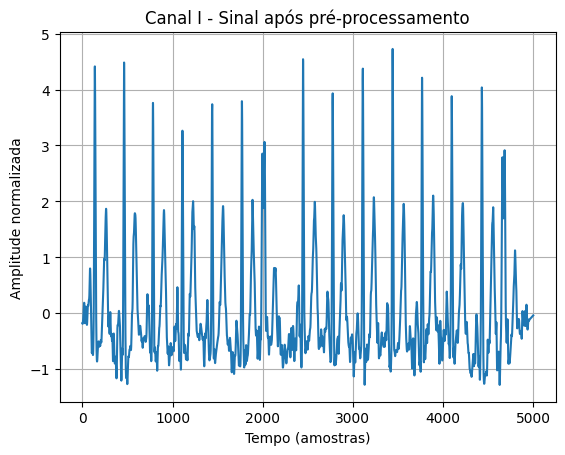

In [ ]:
import matplotlib.pyplot as plt

# Plote o canal I do primeiro exame
plt.plot(aa[0][:, 0])
plt.title("Canal I - Sinal após pré-processamento")
plt.xlabel("Tempo (amostras)")
plt.ylabel("Amplitude normalizada")
plt.grid(True)
plt.show()

# Balanceamento das Classes

Distribuição das classes:
   Classe  Qtd
0  Abn-HB  350
1      MI  350
2    NORM  350


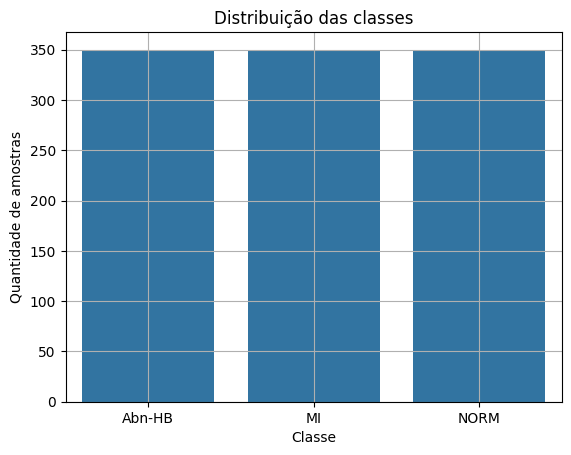

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ver distribuição das classes
classes, counts = np.unique(y, return_counts=True)
df = pd.DataFrame({'Classe': classes, 'Qtd': counts})

print("Distribuição das classes:")
print(df)

# Gráfico de barras
sns.barplot(x='Classe', y='Qtd', data=df)
plt.title("Distribuição das classes")
plt.ylabel("Quantidade de amostras")
plt.xlabel("Classe")
plt.grid(True)
plt.show()


---
#**Extração das características**

## Tranformada de Fourier




**Como funciona?**
A FFT é um algoritmo eficiente para calcular a Transformada de Fourier Discreta. Ela decompõe um sinal do domínio do tempo (amplitude vs. tempo) para o domínio da frequência (magnitude vs. frequência). Em outras palavras, ela nos mostra quais frequências compõem o sinal e com que intensidade.


Diferentes anomalias cardíacas alteram as componentes de frequência do sinal de ECG. Por exemplo, a fibrilação pode introduzir componentes de alta frequência, enquanto alterações isquêmicas podem afetar as baixas frequências.

O código aplica a FFT a cada canal do sinal de ECG e extrai a magnitude (a "força") dos primeiros 100 coeficientes de frequência. Esses 100 valores servem como uma "assinatura de frequência" para cada canal, que será usada como característica pelo modelo.

In [ ]:
def extract_fft_features(X, max_freq=100):
    """
    Aplica FFT ao longo do tempo (eixo 1) e extrai os coeficientes de magnitude
    """
    fft_result = np.fft.fft(X, axis=1)                 # FFT no tempo
    magnitude = np.abs(fft_result)[:, :max_freq, :]    # Pega primeiras frequências
    return np.transpose(magnitude, (0, 2, 1))          # Retorna: (amostras, canais, freq)


## Estatísticas no tempo


**Como funciona?**
Este extrator calcula um conjunto de métricas estatísticas diretamente do sinal no domínio do tempo. São medidas que descrevem a distribuição e as propriedades fundamentais da amplitude do sinal.

As estatísticas fornecem uma visão quantitativa da morfologia da onda de ECG.
*   **Média e Desvio Padrão (`mean`, `std`):** Indicam a linha de base e a variabilidade geral da amplitude.
*   **Assimetria (`skew`):** Mede a falta de simetria na distribuição da amplitude. Pode indicar se os picos (onda R) ou os vales (onda Q/S) são mais dominantes.
*   **Curtose (`kurtosis`):** Mede o quão "pontudos" são os picos do sinal. Uma curtose alta pode indicar complexos QRS muito agudos.
*   **Energia e RMS (`energy`, `rms`):** Medem a magnitude ou "força" geral do sinal em cada canal.

Para cada canal, o código calcula essas seis estatísticas, resultando em um vetor de 6 características que resumem a forma e a magnitude do sinal naquele canal.

In [ ]:
from scipy.stats import skew, kurtosis

def extract_stat_features(X):
    """
    Extrai estatísticas por canal (axis=1 é o tempo)
    """
    mean = np.mean(X, axis=1)
    std = np.std(X, axis=1)
    sk = skew(X, axis=1)
    kurt = kurtosis(X, axis=1)
    energy = np.sum(X**2, axis=1)
    rms = np.sqrt(np.mean(X**2, axis=1))
    return np.stack([mean, std, sk, kurt, energy, rms], axis=2)


## Entropia de Shannon


**Como funciona?**
A Entropia de Shannon é um conceito da teoria da informação que mede a "incerteza" ou "imprevisibilidade" de um sinal. Um sinal que é muito repetitivo e previsível tem baixa entropia, enquanto um sinal mais complexo e irregular tem alta entropia.

Em ECGs, a entropia pode capturar a complexidade da forma de onda. Sinais com morfologias mais irregulares ou com ruído, que podem estar associados a certas patologias, tendem a ter uma entropia diferente de um sinal normal e rítmico.

O código primeiro cria um histograma das amplitudes do sinal para estimar sua distribuição de probabilidade. Em seguida, calcula a entropia dessa distribuição. O resultado é um único valor de entropia para cada canal, representando sua complexidade.

In [ ]:
from scipy.stats import entropy

def extract_entropy_features(X, bins=50):
    n_samples, n_time, n_channels = X.shape
    out = np.zeros((n_samples, n_channels))

    for i in range(n_samples):
        for j in range(n_channels):
            sig = X[i, :, j]  # Pega o sinal do canal j na amostra i
            hist, _ = np.histogram(sig, bins=bins, density=True)
            out[i, j] = entropy(hist + 1e-10)

    return out[..., np.newaxis]  # (amostras, canais, 1)

## Wavelet (DWT)


**Como funciona?**
A DWT é uma técnica de análise tempo-frequência. Ao contrário da FFT, que nos diz apenas quais frequências existem no sinal, a DWT nos diz quais frequências existem e quando elas ocorrem. Ela faz isso decompondo o sinal em diferentes níveis de resolução, usando uma função-mãe chamada "wavelet" (neste caso, a 'db4' - Daubechies 4).

O ECG é um sinal não estacionário, ou seja, suas propriedades de frequência mudam com o tempo (por exemplo, a alta frequência do QRS ocorre apenas em um curto intervalo). A DWT é ideal para analisar esses sinais, pois pode capturar eventos transitórios (como picos, vales e anomalias) que a FFT poderia perder.

O código decompõe cada canal do sinal de ECG usando a DWT em múltiplos níveis. Os coeficientes resultantes dessa decomposição (que representam o sinal em diferentes escalas de tempo e frequência) são então concatenados para formar um vetor de características para cada canal.

In [ ]:
import pywt

def extract_dwt_features(X, wavelet='db4', level=2):
    n_samples, n_time, n_channels = X.shape
    output = []

    for i in range(n_samples):
        sample_feats = []
        for j in range(n_channels):
            sig = X[i, :, j]  # Tempo está no eixo 1
            coeffs = pywt.wavedec(sig, wavelet=wavelet, level=level)
            coeffs_flat = np.concatenate(coeffs)
            sample_feats.append(coeffs_flat)
        output.append(sample_feats)

    return np.array(output)  # (amostras, canais, coeficientes)


### Preparando dados para verificação

In [ ]:
import os
import numpy as np

# Cria a pasta se não existir
os.makedirs('data_preprocessed', exist_ok=True)

# Carrega os dados pré-processados
X_filtered = np.load('/content/splited_dataset/X_filtered.npy', allow_pickle=True)
y_filtered = np.load('/content/splited_dataset/y_filtered.npy', allow_pickle=True)


# Extração das características (assume que as funções já estão definidas)
fft_features = extract_fft_features(X_filtered)
np.save('data_preprocessed/fft_features.npy', fft_features)
print("FFT salva:", fft_features.shape)

stat_features = extract_stat_features(X_filtered)
np.save('data_preprocessed/stat_features.npy', stat_features)
print("Estatísticas salvas:", stat_features.shape)

entropy_features = extract_entropy_features(X_filtered)
np.save('data_preprocessed/entropy_features.npy', entropy_features)
print("Entropia salva:", entropy_features.shape)

dwt_features = extract_dwt_features(X_filtered)
np.save('data_preprocessed/dwt_features.npy', dwt_features)
print("DWT salva:", dwt_features.shape)

FFT salva: (1050, 12, 100)
Estatísticas salvas: (1050, 12, 6)
Entropia salva: (1050, 12, 1)
DWT salva: (1050, 12, 5013)


## Verificação da extração de características


### Verificação de Shape


Os shapes (`(300, 12, N)`) confirmam que a extração de características funcionou como esperado. Para cada um dos **300 sinais** de ECG, foram extraídas características para cada um dos **12 canais** (derivações). O número de características (`N`) varia para cada método:
*   **FFT:** 100 características (as magnitudes das 100 primeiras frequências).
*   **Estatísticas:** 6 características (média, desvio padrão, assimetria, curtose, energia, RMS).
*   **Entropia:** 1 característica (o valor da entropia de Shannon).
*   **DWT:** 5013 características (o conjunto de todos os coeficientes da decomposição wavelet).

Essa estrutura tridimensional (`amostras, canais, características`) é exatamente o que precisamos para alimentar a próxima etapa do modelo.

In [ ]:
import numpy as np

fft = np.load('data_preprocessed/fft_features.npy')
stat = np.load('data_preprocessed/stat_features.npy')
entropy_ = np.load('data_preprocessed/entropy_features.npy')
dwt = np.load('data_preprocessed/dwt_features.npy')

print("FFT features:", fft.shape)
print("Statistical features:", stat.shape)
print("Entropy features:", entropy_.shape)
print("DWT features:", dwt.shape)


FFT features: (1050, 12, 100)
Statistical features: (1050, 12, 6)
Entropy features: (1050, 12, 1)
DWT features: (1050, 12, 5013)


### Verificação de estatísticas


Os gráficos mostram a "impressão digital" estatística de uma única amostra de ECG através de suas 12 derivações.
*   **`Média` e `Desv. Padrão`:** Os valores de média próximos de 0 e desvio padrão próximos de 1 confirmam que nossa normalização Z-score foi bem-sucedida.
*   **`Assimetria` e `Curtose`:** A variação dos valores de assimetria e curtose entre os canais é esperada e valiosa. Ela mostra que a *forma* da onda de ECG (seus picos, vales, etc.) é diferente em cada derivação, fornecendo múltiplas "perspectivas" do mesmo batimento cardíaco.
*   **`Energia` e `Valor rms`:** A variação nos níveis de energia e RMS entre os canais também é normal, pois algumas derivações (como as precordiais V1-V6) estão mais próximas do coração e capturam um sinal elétrico mais forte.

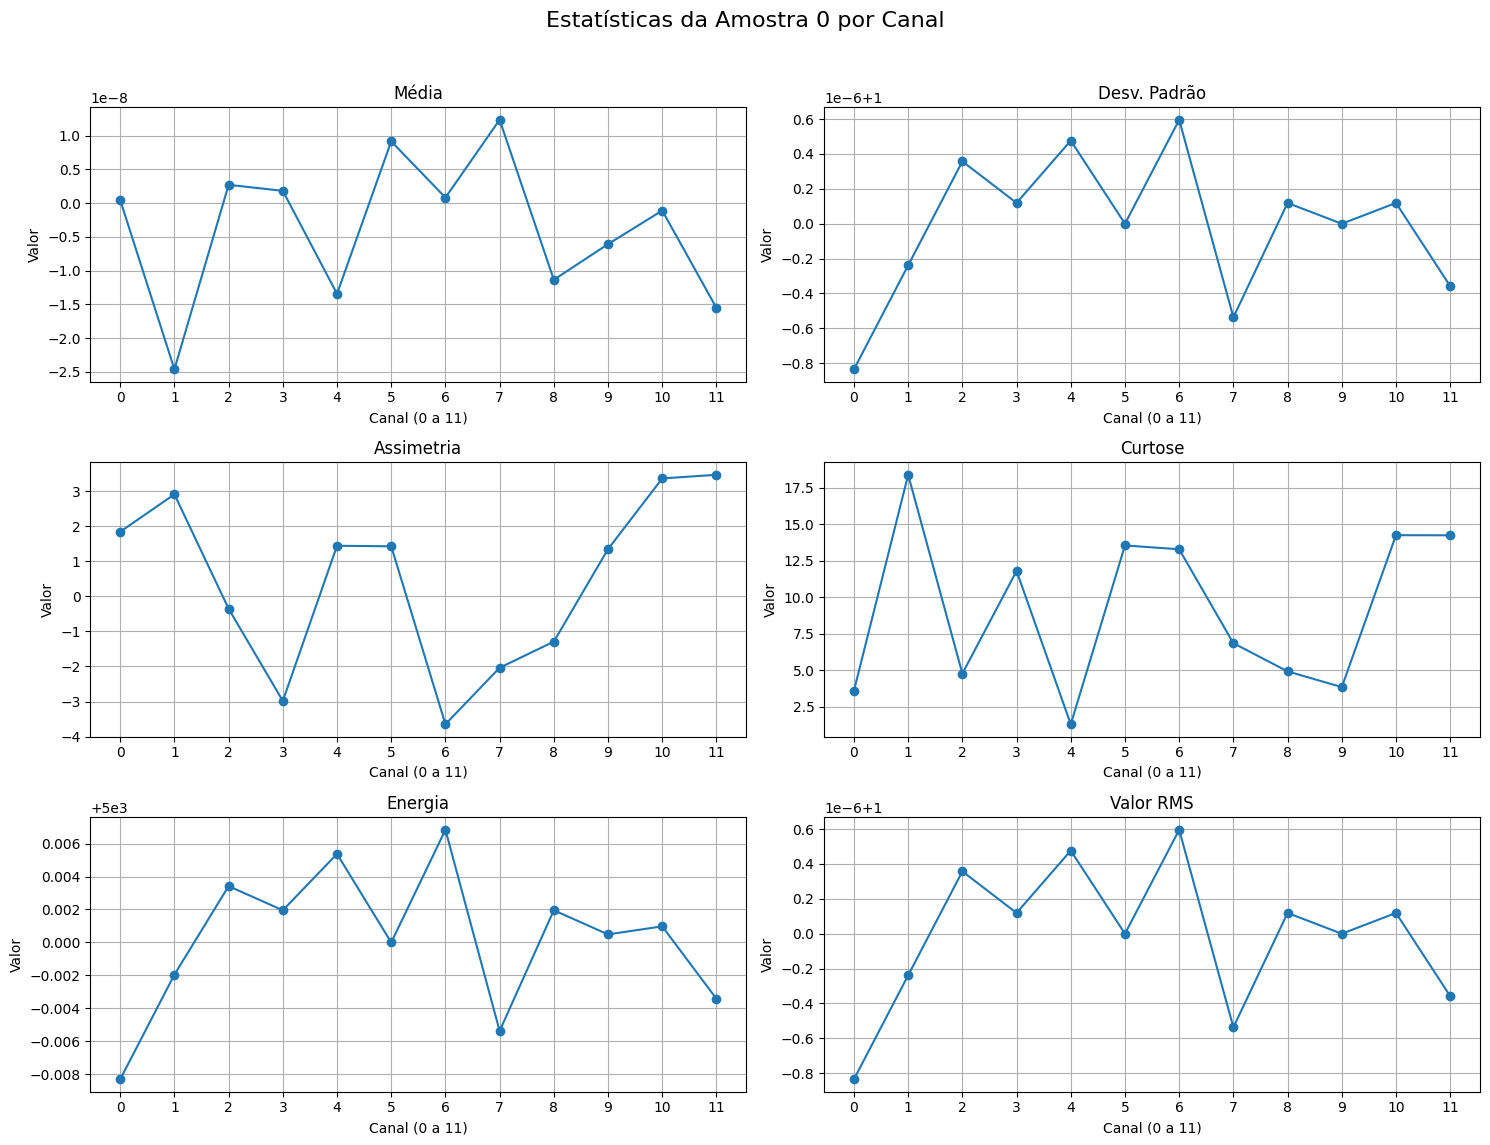

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # primeira amostra

# Estatísticas: média, std, skew, kurt, energia, rms
stat_names = ['Média', 'Desv. Padrão', 'Assimetria', 'Curtose', 'Energia', 'Valor RMS']

# Crie uma figura com 3 linhas e 2 colunas de subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Estatísticas da Amostra 0 por Canal', fontsize=16)

# Achate o array de eixos para facilitar o loop
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.plot(stat[idx, :, i], marker='o', linestyle='-')
    ax.set_title(stat_names[i])
    ax.set_xlabel("Canal (0 a 11)")
    ax.set_ylabel("Valor")
    ax.grid(True)
    ax.set_xticks(range(12)) # Garante que todos os canais sejam mostrados no eixo x

# Ajusta o layout para evitar sobreposição de títulos
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Verificação por classes da Entropia


Este é um dos resultados mais interessantes da nossa análise. A entropia mede a complexidade ou "desordem" do sinal. O resultado foi:
*   **Abn-HB < NORM < MI**

Isso sugere que os sinais da classe 'Abn-HB' (que inclui bloqueios de ramo) são, em média, os *menos* complexos. Isso ocorre provavelmente porque essas condições geram ondas QRS mais largas e suaves, que do ponto de vista do sinal são menos "complexas" do que os picos agudos de um ECG normal.

Por outro lado, os sinais de 'MI' (Infarto) são os mais complexos, possivelmente devido a ruídos ou distorções adicionais na forma de onda causadas pelo tecido danificado. Essa separação entre as médias de entropia é um ótimo sinal de que esta é uma característica útil para o modelo de classificação.

In [ ]:
# Carregue também os rótulos:
y = np.load('/content/splited_dataset/y_filtered.npy', allow_pickle=True)

# Índices por classe
idx_norm = y == 'NORM'
idx_mi   = y == 'MI'
idx_abn  = y == 'Abn-HB'

# Calcula a entropia média para cada classe
mean_entropy_norm = np.mean(entropy_[idx_norm])
mean_entropy_mi   = np.mean(entropy_[idx_mi])
mean_entropy_abn  = np.mean(entropy_[idx_abn])


print("Entropia média - NORM:", mean_entropy_norm)
print("Entropia média - MI:", mean_entropy_mi)
print("Entropia média - Abn-HB:", mean_entropy_abn)

Entropia média - NORM: 2.4321048872753877
Entropia média - MI: 2.4937698657700187
Entropia média - Abn-HB: 2.434061912349601


### Verificação de FFT por canal


O gráfico gerado nesta verificação mostra a **assinatura de frequência** de um único canal de ECG (o Canal II da primeira amostra).

*   **Eixo X (Coeficiente de frequência):** Representa as frequências, das mais baixas (à esquerda) às mais altas.
*   **Eixo Y (Magnitude):** Mostra a "força" ou "importância" de cada frequência na composição do sinal.

A principal observação é o **pico de magnitude nas baixas frequências**, que depois decai rapidamente. Este padrão é o esperado para um sinal de ECG, pois a maior parte da informação clinicamente relevante (como as ondas P, QRS e T) está concentrada em frequências abaixo de 40-50 Hz.

Este gráfico serve como uma **excelente verificação de sanidade**, confirmando que a extração de características via FFT está capturando corretamente a distribuição de energia do sinal no domínio da frequência.

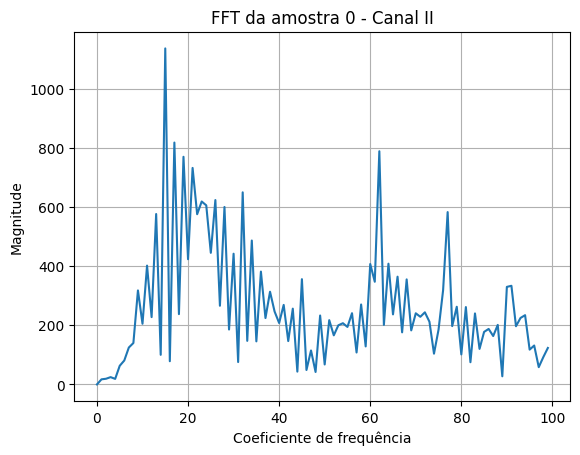

In [ ]:
# FFT da amostra 0, canal II (canal 1)
plt.plot(fft[0, 1, :])
plt.title("FFT da amostra 0 - Canal II")
plt.xlabel("Coeficiente de frequência")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


### Verificação de coeficientes da DWT


*   **Gráfico da FFT:** O gráfico mostra a magnitude das 100 primeiras componentes de frequência para um único canal. Vemos picos em frequências mais baixas, o que é típico de sinais de ECG, onde a maior parte da energia está concentrada abaixo de 40-50 Hz.
*   **Shape da DWT:** A verificação do shape da DWT confirma que a decomposição gerou um grande número de coeficientes (5013). Esses coeficientes capturam informações detalhadas sobre a frequência e o tempo simultaneamente, fornecendo uma representação muito rica do sinal para a CNN.

In [ ]:
print("Shape DWT:", dwt.shape)
print("Coeficientes por canal:", dwt.shape[2])


Shape DWT: (1050, 12, 5013)
Coeficientes por canal: 5013


### Verficação de salvamento dos arquivos

In [ ]:
import os
import numpy as np

# Diretório onde os arquivos estão salvos
folder = 'data_preprocessed'

# Arquivos esperados e seus nomes amigáveis
expected_files = {
    'fft_features.npy': 'FFT',
    'stat_features.npy': 'Estatísticas',
    'entropy_features.npy': 'Entropia',
    'dwt_features.npy': 'Wavelet (DWT)',
}

print("Verificando arquivos salvos em:", folder)
print("-" * 50)

for fname, label in expected_files.items():
    path = os.path.join(folder, fname)
    if os.path.exists(path):
        try:
            arr = np.load(path)
            print(f"{label:25s} encontrado - Shape: {arr.shape}")
        except Exception as e:
            print(f"{label:25s} encontrado, mas erro ao carregar: {e}")
    else:
        print(f"{label:25s} NÃO encontrado: {fname}")

# Verificando os arquivos no diretório splited_dataset
folder = '/content/splited_dataset'
expected_files = {
    'X_filtered.npy': 'Sinais pré-processados',
    'y_filtered.npy': 'Rótulos',
}


print("\nVerificando arquivos salvos em:", folder)
print("-" * 50)

for fname, label in expected_files.items():
    path = os.path.join(folder, fname)
    if os.path.exists(path):
        try:
            arr = np.load(path, allow_pickle=True)
            print(f"{label:25s} encontrado - Shape: {arr.shape}")
        except Exception as e:
            print(f"{label:25s} encontrado, mas erro ao carregar: {e}")
    else:
        print(f"{label:25s} NÃO encontrado: {fname}")

print("-" * 50)
print("Verificação concluída.")

🔎 Verificando arquivos salvos em: data_preprocessed
--------------------------------------------------
FFT                       encontrado - Shape: (1050, 12, 100)
Estatísticas              encontrado - Shape: (1050, 12, 6)
Entropia                  encontrado - Shape: (1050, 12, 1)
Wavelet (DWT)             encontrado - Shape: (1050, 12, 5013)

🔎 Verificando arquivos salvos em: /content/splited_dataset
--------------------------------------------------
Sinais pré-processados    encontrado - Shape: (1050, 5000, 12)
Rótulos                   encontrado - Shape: (1050,)
--------------------------------------------------
Verificação concluída.


# Empilhamento das Características


Consiste em juntar todas as representações de características (features) extraídas dos sinais em um único tensor que será usado como entrada para a CNN. No projeto extraiu-se 4 conjuntos de features:

- FFT          → (300, 12, 100)
- Estatísticas → (300, 12, 6)
- Entropia     → (300, 12, 1)
- DWT          → (300, 12, 5013)

Sendo que, cada conjunto contém diferentes perspectivas do sinal (frequência, estatísticas do tempo, complexidade e análise wavelet). Para treinar uma CNN, precisamos combinar tudo em um só array X_final para que cada amostra do ECG (cada exame) seja representada por todas as features juntas.

In [ ]:
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

def merge_features():
    # Diretório onde estão os arquivos de características
    data_dir = "data_preprocessed"

    # Carregando os arquivos
    fft = np.load(os.path.join(data_dir, "fft_features.npy"))
    stat = np.load(os.path.join(data_dir, "stat_features.npy"))
    entropy = np.load(os.path.join(data_dir, "entropy_features.npy"))
    dwt = np.load(os.path.join(data_dir, "dwt_features.npy"))

    # Corta a DWT
    dwt = dwt[:, :, :300]

    # Função para normalizar por canal
    def normalize(tensor):
        n_samples, n_canais, n_feats = tensor.shape
        norm = np.zeros_like(tensor)
        for c in range(n_canais):
            scaler = StandardScaler()
            norm[:, c, :] = scaler.fit_transform(tensor[:, c, :])
        return norm

    # Aplica normalização
    fft = normalize(fft)
    stat = normalize(stat)
    entropy = normalize(entropy)
    dwt = normalize(dwt)

    # Concatena no eixo das features (último)
    X_final = np.concatenate([fft, stat, entropy, dwt], axis=2)  # (300, 12, 407)

    # Transpõe para formato esperado pela CNN 1D: (amostras, features, canais)
    X_final = np.transpose(X_final, (0, 2, 1))  # (300, 407, 12)

    # Carrega os rótulos
    y_final = np.load('/content/splited_dataset/y_filtered.npy', allow_pickle=True)

    # Salva os arquivos finais
    np.save(os.path.join(data_dir, "X_final.npy"), X_final)
    np.save(os.path.join(data_dir, "y_final.npy"), y_final)

    print("X_final salvo em:", os.path.join(data_dir, "X_final.npy"), "→", X_final.shape)
    print("y_final salvo em:", os.path.join(data_dir, "y_final.npy"), "→", y_final.shape)

if __name__ == "__main__":
    merge_features()


✅ X_final salvo em: data_preprocessed/X_final.npy → (1050, 407, 12)
✅ y_final salvo em: data_preprocessed/y_final.npy → (1050,)


# Testes para saber se a etapa de Empilhamento funcionou

Para validar o sucesso da etapa de empilhamento (etapa 3), é necessário verificar:

1. Existência dos arquivos X_final.npy e y_final.npy

  - Confirma que os arquivos resultantes foram gerados corretamente e estão no diretório esperado.

2. Formato (shape) dos arrays

  - X_final deve ter o formato (n_amostras, n_canais, n_features), onde:

    - n_amostras = 300 (100 por classe: MI, Abn-HB, NORM);

    - n_canais = 12 (derivações do ECG);

    - n_features = soma das características (FFT + estatísticas + entropia + DWT = 5120).

  - y_final deve ser um vetor (n_amostras,) com as classes correspondentes.

3. Consistência dos valores
  - Verifica se não há valores inválidos (NaN ou infinitos) no X_final.

4. Validação do total de features
  - Confirma se a soma das dimensões de FFT, estatísticas, entropia e DWT corresponde ao número total de características no X_final.

5. Verificação visual
  - Plota os primeiros coeficientes da FFT para uma amostra, garantindo que os valores armazenados no X_final são coerentes.

Arquivos carregados com sucesso.
Shape de X_final: (1050, 407, 12)
Shape de y_final: (1050,)
Classes únicas: ['Abn-HB' 'MI' 'NORM']
Contém NaNs? False
Contém infinitos? False
Total de features esperado: 5120
Total de features no eixo 2: 12
Número de features não confere.

Exibindo gráfico das 100 primeiras FFT features da amostra 0 (canal 0):


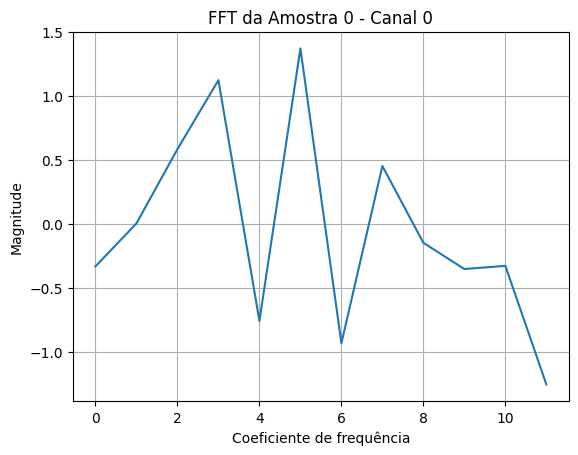

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def verify_merge(data_dir="data_preprocessed"):
    X_path = os.path.join(data_dir, "X_final.npy")
    y_path = os.path.join(data_dir, "y_final.npy")

    # 1. Verificar existência dos arquivos
    if not os.path.exists(X_path) or not os.path.exists(y_path):
        print(" Arquivos X_final.npy ou y_final.npy não encontrados!")
        return

    # 2. Carregar os arquivos
    X_final = np.load(X_path, allow_pickle=True)
    y_final = np.load(y_path, allow_pickle=True)

    print("Arquivos carregados com sucesso.")
    print("Shape de X_final:", X_final.shape)
    print("Shape de y_final:", y_final.shape)
    print("Classes únicas:", np.unique(y_final))

    # 3. Checar NaNs e infinitos
    has_nan = np.isnan(X_final).any()
    has_inf = np.isinf(X_final).any()
    print(f"Contém NaNs? {has_nan}")
    print(f"Contém infinitos? {has_inf}")

    # 4. Validar número total de features
    n_fft, n_stat, n_entropy, n_dwt = 100, 6, 1, 5013
    total_expected = n_fft + n_stat + n_entropy + n_dwt
    print(f"Total de features esperado: {total_expected}")
    print(f"Total de features no eixo 2: {X_final.shape[2]}")
    if X_final.shape[2] == total_expected:
        print(" Número de features está correto.")
    else:
        print("Número de features não confere.")

    # 5. Visualizar parte das features FFT da amostra 0
    print("\nExibindo gráfico das 100 primeiras FFT features da amostra 0 (canal 0):")
    plt.plot(X_final[0, 0, :100])
    plt.title("FFT da Amostra 0 - Canal 0")
    plt.xlabel("Coeficiente de frequência")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    verify_merge()


### Nova Normalização

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# Carrega o conjunto de características combinado
X_final = np.load('data_preprocessed/X_final.npy')

# Obtém as dimensões originais
n_amostras, n_canais, n_features = X_final.shape

# Remodela os dados para (amostras * canais, features) para que o scaler possa ser aplicado
X_reshaped = X_final.reshape(-1, n_features)

# Inicializa e aplica o StandardScaler
scaler = StandardScaler()
X_normalized_reshaped = scaler.fit_transform(X_reshaped)

# Remodela de volta para o formato original (amostras, canais, features)
X_final_normalizado = X_normalized_reshaped.reshape(n_amostras, n_canais, n_features)

# Salva o array normalizado
np.save('data_preprocessed/X_final_normalized.npy', X_final_normalizado)

print(" Características normalizadas salvas em: data_preprocessed/X_final_normalized.npy")
print("Shape:", X_final_normalizado.shape)

# Verificação rápida da normalização (média próxima de 0, desvio padrão próximo de 1)
print(f"\nMédia após normalização: {np.mean(X_final_normalizado):.2f}")
print(f"Desvio padrão após normalização: {np.std(X_final_normalizado):.2f}")

 Características normalizadas salvas em: data_preprocessed/X_final_normalized.npy
Shape: (1050, 407, 12)

Média após normalização: 0.00
Desvio padrão após normalização: 1.00


---
#**Implementação do CNN**

## Código para a análise de Loss e Accuracy por época

In [ ]:
# ==== MINI-KIT: análise simples e profunda das curvas ====
import os, numpy as np, matplotlib.pyplot as plt

def analise_curvas(history, nome="run1", pasta="/content/cnn_metrics", salvar=True, suav=0, k_overfit=3):
    """
    - history: objeto retornado por model.fit(...)
    - nome: rótulo do experimento (vai no título e no nome dos arquivos)
    - pasta: onde salvar PNGs
    - salvar: se True, salva PNGs
    - suav: janela de média móvel (0 = sem suavização)
    - k_overfit: nº de épocas seguidas de piora em val_loss p/ sinalizar overfit
    Retorna um dicionário-resumo com métricas-chave.
    """
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    acc_key = next((k for k in ["accuracy","categorical_accuracy","sparse_categorical_accuracy"] if k in H), None)
    val_acc_key = f"val_{acc_key}" if acc_key and f"val_{acc_key}" in H else None
    if "val_loss" not in H or "loss" not in H:
        raise ValueError("Precisa ter 'loss' e 'val_loss' no history (use validation_data/validation_split).")

    loss, val_loss = np.array(H["loss"]), np.array(H["val_loss"])
    epochs = np.arange(1, len(loss)+1)

    acc = np.array(H[acc_key]) if acc_key else None
    val_acc = np.array(H[val_acc_key]) if val_acc_key else None

    def smooth(x, w):
        if not w or w <= 1: return x
        k = np.ones(w)/w
        return np.convolve(x, k, mode="same")
    loss_s, val_loss_s = smooth(loss, suav), smooth(val_loss, suav)
    if acc is not None:
        acc_s, val_acc_s = smooth(acc, suav), smooth(val_acc, suav)

    ep_best_vloss = int(val_loss.argmin()) + 1
    best_vloss = float(val_loss.min())
    gap_best = float(val_loss[ep_best_vloss-1] - loss[ep_best_vloss-1])

    ep_best_vacc = None; best_vacc = None
    if val_acc is not None:
        ep_best_vacc = int(val_acc.argmax()) + 1
        best_vacc = float(val_acc.max())

    overfit_ep = None
    if len(val_loss) > k_overfit:
        d_val = np.diff(val_loss); d_tr = np.diff(loss)
        for i in range(len(val_loss)-1-k_overfit+1):
            if np.all(d_val[i:i+k_overfit] > 0) and np.any(d_tr[i:i+k_overfit] <= 0):
                overfit_ep = i+1
                break

    tail = min(5, len(val_loss)-1) if len(val_loss) > 1 else 0
    delta_vloss_tail = float((-np.diff(val_loss)[-tail:]).mean()) if tail else 0.0
    delta_vacc_tail  = float((np.diff(val_acc)[-tail:]).mean()) if (val_acc is not None and tail) else None

    # ---- LOSS
    plt.figure()
    plt.plot(epochs, loss,     label="Treino")
    plt.plot(epochs, val_loss, label="Validação")
    if suav and suav > 1:
        plt.plot(epochs, loss_s,     "--", label=f"Treino (suav {suav})")
        plt.plot(epochs, val_loss_s, "--", label=f"Val (suav {suav})")
    plt.axvline(ep_best_vloss, linestyle=":", label=f"Melhor val_loss (ép {ep_best_vloss})")
    if overfit_ep: plt.axvline(overfit_ep, linestyle="-.", label=f"Possível overfit (ép {overfit_ep})")
    plt.title(f"Loss por época — {nome}")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
    if salvar: plt.savefig(os.path.join(pasta, f"{nome}_loss.png"), bbox_inches="tight", dpi=150)
    plt.show()

    # ---- ACC
    if acc is not None:
        plt.figure()
        plt.plot(epochs, acc,     label="Treino")
        plt.plot(epochs, val_acc, label="Validação")
        if suav and suav > 1:
            plt.plot(epochs, acc_s,     "--", label=f"Treino (suav {suav})")
            plt.plot(epochs, val_acc_s, "--", label=f"Val (suav {suav})")
        if ep_best_vacc: plt.axvline(ep_best_vacc, linestyle=":", label=f"Melhor val_acc (ép {ep_best_vacc})")
        if overfit_ep:   plt.axvline(overfit_ep, linestyle="-.", label=f"Possível overfit (ép {overfit_ep})")
        plt.title(f"Accuracy por época — {nome}")
        plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
        if salvar: plt.savefig(os.path.join(pasta, f"{nome}_acc.png"), bbox_inches="tight", dpi=150)
        plt.show()

    resumo = {
        "nome": nome,
        "epochs": int(len(epochs)),
        "best_val_loss": best_vloss,
        "best_val_loss_epoch": ep_best_vloss,
        "gap_at_best_vloss": gap_best,
        "delta_val_loss_tail_mean": delta_vloss_tail,
        "best_val_acc": best_vacc,
        "best_val_acc_epoch": ep_best_vacc,
        "delta_val_acc_tail_mean": delta_vacc_tail,
        "overfit_epoch_k": k_overfit,
        "overfit_detected_at": overfit_ep,
    }

    print(f"\n=== RESUMO {nome} ===")
    print(f"Épocas: {resumo['epochs']}")
    print(f"Melhor val_loss: {best_vloss:.6f} @ época {ep_best_vloss} | gap(loss) nessa época: {gap_best:.6f}")
    if best_vacc is not None:
        print(f"Melhor val_acc : {best_vacc:.4f} @ época {ep_best_vacc}")
    if overfit_ep:
        print(f"Overfit (heurística k={k_overfit}) a partir da época {overfit_ep}")
    print(f"Ganho marginal médio (últimas 5) — val_loss: {delta_vloss_tail:.6f}"
          + (f" | val_acc: {delta_vacc_tail:.6f}" if delta_vacc_tail is not None else ""))
    return resumo



## CNN somente com FFT

Original X: (1050, 407, 12) | classes: (array(['Abn-HB', 'MI', 'NORM'], dtype='<U6'), array([350, 350, 350]))
Após augmentation X: (3150, 407, 12)
X_fft: (3150, 200, 12)
Distribuição (enc.): (array([0, 1, 2]), array([1050, 1050, 1050]))
Pesos: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

===== Fold 1/5 =====
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.4494 - loss: 1.0436 - val_accuracy: 0.3556 - val_loss: 1.1836 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5765 - loss: 0.9069 - val_accuracy: 0.3635 - val_loss: 1.4251 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6153 - loss: 0.8417 - val_accuracy: 0.4222 - val_loss: 1.6185 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6272 - loss: 0.8092 - val_accuracy: 0.4524 - val_loss: 1.4643 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━

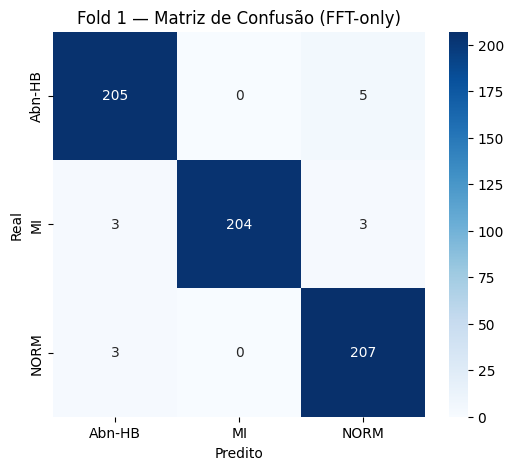


===== Fold 2/5 =====
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.4162 - loss: 1.0663 - val_accuracy: 0.4079 - val_loss: 1.0741 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5342 - loss: 0.9498 - val_accuracy: 0.3905 - val_loss: 1.3489 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6026 - loss: 0.8618 - val_accuracy: 0.3857 - val_loss: 1.5272 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6164 - loss: 0.8291 - val_accuracy: 0.5048 - val_loss: 1.0641 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.7759 - val_accuracy: 0.5413 - val_loss: 1.0203 - learning_rate: 5.0000e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6652 - loss: 0.7310 - val_accuracy: 0.6762 - val_loss: 0.7298 - learning_rate: 5.0000e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

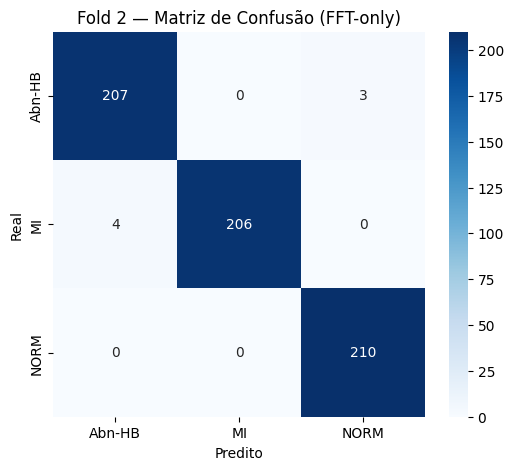


===== Fold 3/5 =====
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.4535 - loss: 1.0445 - val_accuracy: 0.3571 - val_loss: 1.1394 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5867 - loss: 0.8838 - val_accuracy: 0.3571 - val_loss: 1.6912 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6220 - loss: 0.8143 - val_accuracy: 0.3873 - val_loss: 1.7747 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6480 - loss: 0.7498 - val_accuracy: 0.4698 - val_loss: 1.3447 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6721 - loss: 0.7134 - val_accuracy: 0.4762 - val_loss: 1.2847 - learning_rate: 5.0000e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6826 - loss: 0.6856 - val_accuracy: 0.6603 - val_loss: 0.7735 - learning_rate: 5.0000e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

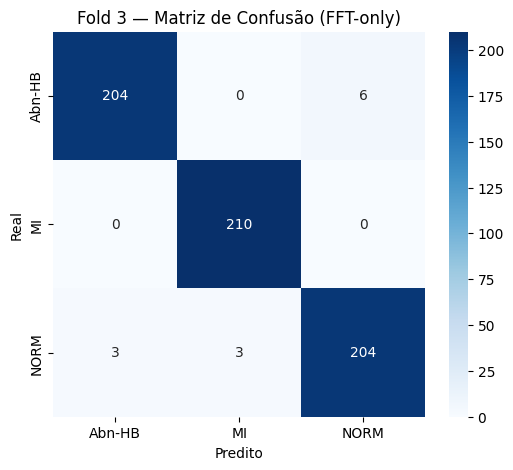


===== Fold 4/5 =====
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4519 - loss: 1.0410 - val_accuracy: 0.3349 - val_loss: 1.2257 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5533 - loss: 0.9112 - val_accuracy: 0.3397 - val_loss: 2.0329 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6117 - loss: 0.8322 - val_accuracy: 0.3635 - val_loss: 1.9326 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6370 - loss: 0.7952 - val_accuracy: 0.3968 - val_loss: 1.8769 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6681 - loss: 0.7411 - val_accuracy: 0.5413 - val_loss: 0.9893 - learning_rate: 5.0000e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6857 - loss: 0.6878 - val_accuracy: 0.6254 - val_loss: 0.8083 - learning_rate: 5.0000e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

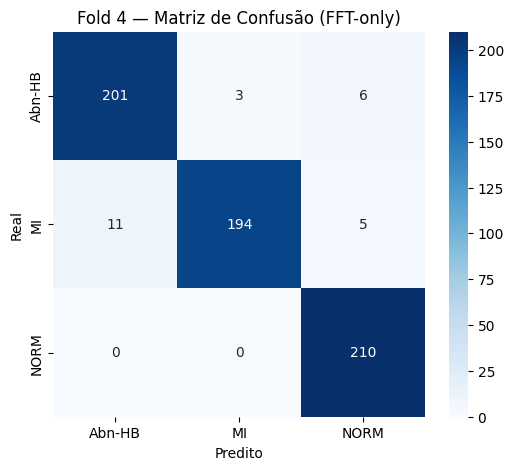


===== Fold 5/5 =====
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.4672 - loss: 1.0376 - val_accuracy: 0.3810 - val_loss: 1.0827 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5648 - loss: 0.9279 - val_accuracy: 0.4032 - val_loss: 1.2494 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6097 - loss: 0.8352 - val_accuracy: 0.4333 - val_loss: 1.2231 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6420 - loss: 0.7811 - val_accuracy: 0.4603 - val_loss: 1.2716 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6422 - loss: 0.7800 - val_accuracy: 0.5238 - val_loss: 1.0580 - learning_rate: 5.0000e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6945 - loss: 0.7243 - val_accuracy: 0.5349 - val_loss: 1.0982 - learning_rate: 5.0000e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

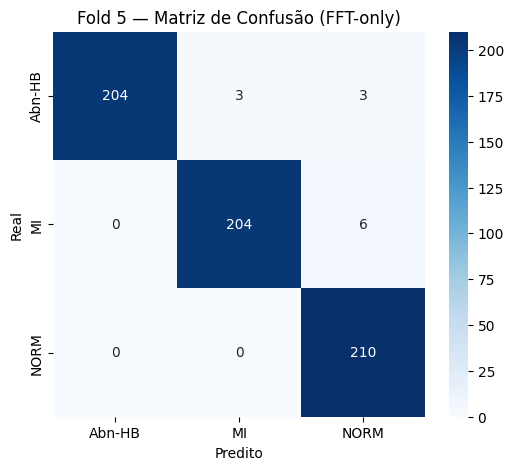


Acurácias por fold: ['97.78%', '98.89%', '98.10%', '96.03%', '98.10%']
Média final: 97.78% ± 0.95%


In [ ]:
# ===== CNN SOMENTE FFT (versão do seu dual-branch simplificada p/ usar apenas FFT) =====
import os, gc, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, LeakyReLU, BatchNormalization,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------------------------
# PARÂMETROS
# ---------------------------
AUG_FACTOR = 2          # fator de augmentation
RANDOM_SEED = 42
FFT_KEEP_BINS = 200     # nº de bins de frequência mantidos (ajuste conforme quiser)
LR = 5e-4
EPOCHS = 100
BATCH_SIZE = 32
N_SPLITS = 5

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ---------------------------
# AUGMENTATION (mesmo do seu código)
# ---------------------------
def augment_ecg_signals(X, y, factor=AUG_FACTOR):
    """Ruído gaussiano, deslocamento temporal, escala de amplitude e inversão opcional."""
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        for _ in range(factor):
            s = X[i]
            s2 = s + np.random.normal(0, 0.01, s.shape)            # ruído
            s2 = np.roll(s2, np.random.randint(-8, 9), axis=0)      # shift
            s2 = s2 * np.random.uniform(0.92, 1.08)                 # escala
            if np.random.rand() > 0.5: s2 = -s2                     # inversão
            augmented_X.append(s2); augmented_y.append(y[i])
    if not augmented_X:
        return X, y
    return np.concatenate([X, np.stack(augmented_X)]), np.concatenate([y, np.array(augmented_y)])

# ---------------------------
# CARREGA DADOS
# ---------------------------
X = np.load("data_preprocessed/X_final.npy")   # (N, 407, 12)
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)
print("Original X:", X.shape, "| classes:", np.unique(y, return_counts=True))

# ---------------------------
# AUGMENTATION
# ---------------------------
X, y = augment_ecg_signals(X, y, factor=AUG_FACTOR)
print("Após augmentation X:", X.shape)

# ---------------------------
# FFT-ONLY (magnitude log) -> entrada do modelo
# ---------------------------
N = X.shape[1]                    # 407
n_freq_full = N//2 + 1            # bins da rfft
n_bins = min(FFT_KEEP_BINS, n_freq_full)

X_fft = np.fft.rfft(X, axis=1)               # (N, n_freq_full, 12)
X_fft = np.abs(X_fft) / N
X_fft = np.log1p(X_fft)                       # compressão log para estabilizar escalas
X_fft = X_fft[:, :n_bins, :]                  # (N, n_bins, 12)
print("X_fft:", X_fft.shape)

# ---------------------------
# NORMALIZAÇÃO (Z-score por canal)
# ---------------------------
scaler = StandardScaler()
Xr = X_fft.reshape(-1, X_fft.shape[-1])       # (N*n_bins, 12)
Xr = scaler.fit_transform(Xr)
X_fft = Xr.reshape(X_fft.shape)

# ---------------------------
# RÓTULOS + PESOS
# ---------------------------
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Distribuição (enc.):", np.unique(y_int, return_counts=True))
print("Pesos:", class_weight_dict)

# ---------------------------
# MODELO (CNN 1D no eixo de frequência)
# ---------------------------
def build_fft_cnn(input_shape, lr=LR):
    inp = Input(shape=input_shape, name="fft_input")   # (n_bins, 12)

    x = Conv1D(64, 7, padding='same')(inp)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x); x = Dropout(0.30)(x)

    x = Conv1D(128, 5, padding='same')(x)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x); x = Dropout(0.30)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = LeakyReLU()(x); x = BatchNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x); x = Dropout(0.50)(x)
    out = Dense(y_cat.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ---------------------------
# CROSS-VALIDATION (k-fold)
# ---------------------------
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
fold_accuracies = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_fft, y_int), 1):
    print(f"\n===== Fold {fold}/{N_SPLITS} =====")
    X_tr, X_va = X_fft[tr_idx], X_fft[va_idx]
    y_tr, y_va = y_cat[tr_idx], y_cat[va_idx]

    model = build_fft_cnn(input_shape=X_tr.shape[1:], lr=LR)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )



    # Avaliação
    loss, acc = model.evaluate(X_va, y_va, verbose=0)
    print(f"Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc*100)

    # Relatório e matriz de confusão
    y_pred = model.predict(X_va, verbose=0)
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_va, axis=1)
    print(classification_report(y_true, y_pred_cls, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred_cls)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Fold {fold} — Matriz de Confusão (FFT-only)')
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.show()

    # liberar memória
    del model, history, X_tr, X_va, y_tr, y_va, y_pred
    gc.collect()

print("\nAcurácias por fold:", [f"{a:.2f}%" for a in fold_accuracies])
print("Média final: %.2f%% ± %.2f%%" % (np.mean(fold_accuracies), np.std(fold_accuracies)))


##**Teste 1**

Este teste avalia a arquitetura da rede neural CNN utilizada, as etapas de pré-processamento e o desempenho do modelo com base em métricas como acurácia, relatório de classificação e matriz de confusão.

**Implementação do Teste 1**

*Pré-processamento dos Dados*:

* Os dados de entrada têm o shape (1050, 407, 12), representando 1050 amostras, 407 features e 12 canais.

* Foi aplicada a padronização Z-score canal a canal.

* Os rótulos foram codificados com
LabelEncoder e transformados em vetores one-hot.

* A divisão dos dados foi feita em 70% para treino, 15% para validação e 15% para teste.

*Arquitetura da Rede CNN 1D*:

* A rede foi estruturada com três blocos convolucionais. Cada bloco consiste em
Conv1D, LeakyReLU, BatchNormalization, MaxPooling e Dropout.

* A arquitetura finaliza com uma camada
GlobalAveragePooling1D, seguida por duas camadas densas (32 neurônios e uma camada de saída softmax para 3 classes).

*Otimização e Treinamento*:

* Foi usado o otimizador Adam, com uma taxa de aprendizado de 0.001 e decaimento de 1e-5.

* O treinamento foi realizado por 200 épocas com
early stopping (paciência de 15 épocas) com base na perda de validação (val_loss).

Shape de X: (1050, 407, 12)
Classes em y: ['Abn-HB' 'MI' 'NORM']
Normalização concluída.
Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
Shapes:
Treino: (735, 407, 12)
Validação: (157, 407, 12)
Teste: (158, 407, 12)
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.3734 - loss: 1.2033 - val_accuracy: 0.4268 - val_loss: 1.0348
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5752 - loss: 0.9244 - val_accuracy: 0.3694 - val_loss: 1.0422
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6062 - loss: 0.8694 - val_accuracy: 0.3567 - val_loss: 1.0661
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6315 - loss: 0.8075 - val_accuracy: 0.3758 - val_loss: 1.0977
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6794 - loss: 0.7515 - val_accuracy: 0.3758 - val_loss: 1.1270
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6977 - loss: 0.7344

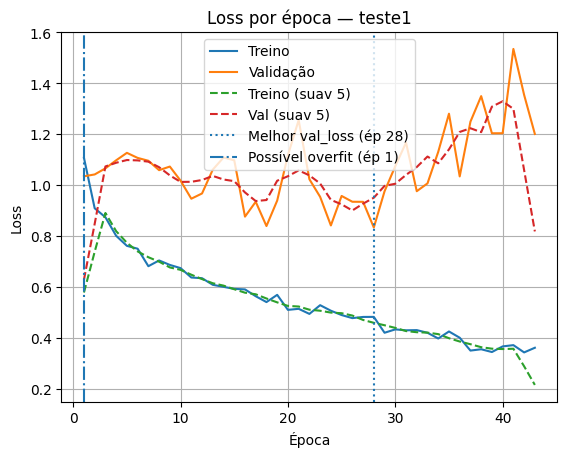

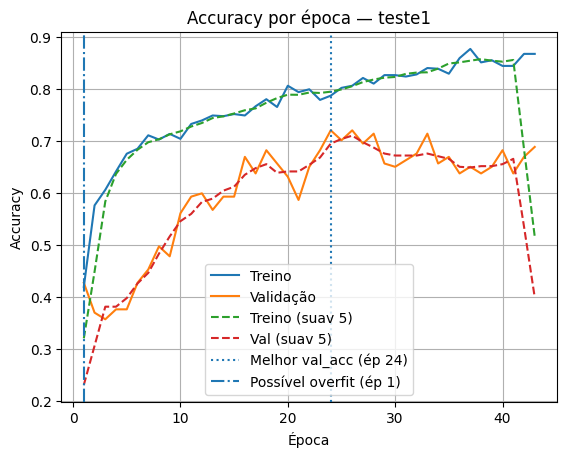


=== RESUMO teste1 ===
Épocas: 43
Melhor val_loss: 0.833611 @ época 28 | gap(loss) nessa época: 0.351198
Melhor val_acc : 0.7197 @ época 24
Overfit (heurística k=3) a partir da época 1
Ganho marginal médio (últimas 5) — val_loss: 0.029749 | val_acc: 0.010191

 Avaliação no conjunto de teste:
Acurácia: 63.29%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step

Salvando resultados do Teste 1 para análise posterior...
--> Resultados do Teste 1 salvos com sucesso!

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.60      0.49      0.54        53
          MI       0.69      0.62      0.65        53
        NORM       0.61      0.79      0.69        52

    accuracy                           0.63       158
   macro avg       0.63      0.63      0.63       158
weighted avg       0.63      0.63      0.63       158



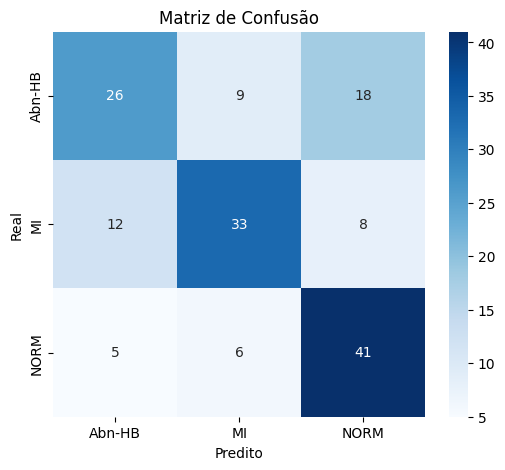

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")   # Esperado: (300, 407, 12)
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)

print("Shape de X:", X.shape)
print("Classes em y:", np.unique(y))

# Verifica se o shape está correto
assert X.shape[1:] == (407, 12), "Shape incorreto! Esperado: (407, 12)"

# === 2. Normalização Z-score ===
X_reshaped = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

print("Normalização concluída.")

# === 3. One-hot e class weights ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 4. Separando os conjuntos ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.30, stratify=y_cat, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Shapes:")
print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)

# === 5. Definindo o modelo CNN 1D ===
model = Sequential([
    InputLayer(input_shape=(407, 12)),

    Conv1D(64, kernel_size=5),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=5),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=3),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=0.001, decay=1e-5),  # simula o efeito do AdamW
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === 6. Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('models/cnn_model.keras', monitor='val_accuracy', save_best_only=True)
]
# === 7. Treinamento com class_weight ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,  # teste com 32 ou depois com 64
    callbacks=callbacks,
    verbose=1
)
%matplotlib inline

r = analise_curvas(history, nome="teste1", pasta="/content/cnn_metrics", salvar=True, suav=5)
# === 8. Avaliação final ===
print("\n Avaliação no conjunto de teste:")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia: {acc*100:.2f}%")

# === 9. Relatório detalhado ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

###===================================================================###
###   BLOCO DE CÓDIGO PARA SALVAR OS RESULTADOS DESTE TESTE           ###

print("\nSalvando resultados do Teste 1 para análise posterior...")
# Salva as probabilidades previstas e os rótulos verdadeiros do conjunto de teste
np.save('resultados_teste1_y_pred_proba.npy', y_pred) # y_pred contém as probabilidades
np.save('resultados_teste1_y_true.npy', y_true)

# Salva o encoder para sabermos os nomes das classes na célula de análise
import pickle
with open('encoder_teste1.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("--> Resultados do Teste 1 salvos com sucesso!")
###===================================================================###

print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# === 10. Matriz de Confusão ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


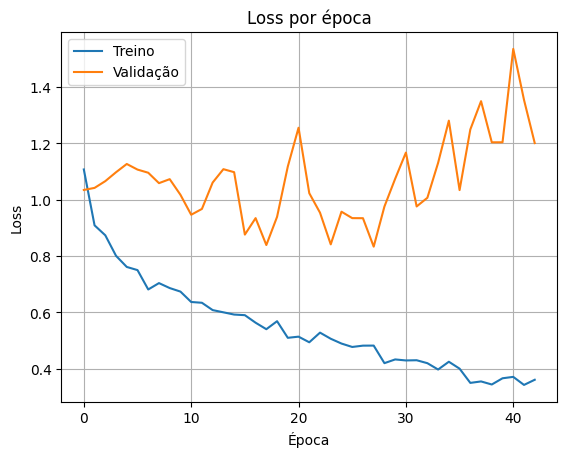

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


**Análise do Gráfico de Perda por Época:**

O gráfico de perda mostra um comportamento característico de
overfitting, onde a perda do conjunto de validação começa a subir após a terceira época, enquanto a perda de treino continua a diminuir.

In [ ]:

# Uso:
#   history = model.fit(...)
#   relatorio = analisar_treinamento(history, out_dir="/content/cnn_metrics")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analisar_treinamento(history,
                         out_dir="/content/cnn_metrics",
                         smooth=None,         # ex.: 5 (média móvel). None = sem suavização
                         k_overfit=3,         # nº de épocas consecutivas de piora em val_loss para sinalizar overfit
                         show=True):          # exibir gráficos no notebook
    """
    Gera gráficos e CSV com métricas do treinamento a partir de `history` (Keras).
    Retorna um dicionário com resumo (melhor época, possíveis sinais de overfit etc.).
    """

    os.makedirs(out_dir, exist_ok=True)

    # ---------- Helpers ----------
    def _pick_key(keys, base):
        cands = [k for k in keys if base in k]
        if not cands:
            return None
        cands.sort(key=lambda k: (k != base, len(k)))
        return cands[0]

    def _smooth(x, w):
        if w is None or w <= 1:
            return np.array(x, dtype=float)
        w = int(w)
        kernel = np.ones(w) / w
        return np.convolve(np.array(x, dtype=float), kernel, mode='same')

    def _find_overfit_epoch(train_loss, val_loss, k=3):
        train_loss = np.array(train_loss, dtype=float)
        val_loss   = np.array(val_loss, dtype=float)
        if len(val_loss) < k + 1:
            return None
        d_val = np.diff(val_loss)    # >0 = piora validação
        d_trn = np.diff(train_loss)  # <0 = melhora treino
        for i in range(0, len(val_loss)-1-k+1):
            janela_val = d_val[i:i+k]
            janela_trn = d_trn[i:i+k]
            if np.all(janela_val > 0) and np.any(janela_trn <= 0):
                return i + 1  # época (base 1) onde começa a piora sustentada
        return None

    # ---------- Extrai métricas do history ----------
    hist = history.history
    keys = list(hist.keys())

    loss_key     = _pick_key(keys, 'loss')          # 'loss'
    val_loss_key = _pick_key(keys, 'val_loss')      # 'val_loss'

    # Tenta detectar a accuracy correta (sparse/categorical)
    acc_key_candidates = ['accuracy', 'categorical_accuracy', 'sparse_categorical_accuracy']
    acc_key = next((k for k in acc_key_candidates if k in keys), None)
    val_acc_key = ('val_' + acc_key) if acc_key and ('val_' + acc_key) in keys else None

    if not loss_key or not val_loss_key:
        raise ValueError("Não encontrei 'loss' e/ou 'val_loss' no history.")

    df = pd.DataFrame({
        'epoch': np.arange(1, len(hist[loss_key]) + 1),
        'loss': hist[loss_key],
        'val_loss': hist[val_loss_key],
    })

    if acc_key and val_acc_key:
        df['acc'] = hist[acc_key]
        df['val_acc'] = hist[val_acc_key]
    else:
        df['acc'] = np.nan
        df['val_acc'] = np.nan

    # Gaps (validação - treino) -> positivo tende a indicar overfit
    df['gap_loss'] = df['val_loss'] - df['loss']
    df['gap_acc']  = df['acc'] - df['val_acc']

    # Épocas-chave
    best_val_loss_epoch = int(df['val_loss'].idxmin()) + 1
    best_val_acc_epoch  = int(df['val_acc'].idxmax()) + 1 if df['val_acc'].notna().any() else None

    # Overfitting simples
    overfit_epoch = _find_overfit_epoch(df['loss'], df['val_loss'], k=k_overfit)

    # Suavização automática (se não definido)
    if smooth is None:
        smooth = max(3, len(df)//30) if len(df) >= 15 else None

    # ---------- Salva CSV ----------
    csv_path = os.path.join(out_dir, "metrics.csv")
    df.to_csv(csv_path, index=False)

    # ---------- Gráfico: LOSS ----------
    loss_s     = _smooth(df['loss'],     smooth) if smooth else None
    val_loss_s = _smooth(df['val_loss'], smooth) if smooth else None

    plt.figure()
    plt.plot(df['epoch'], df['loss'],     label='Loss Treino')
    plt.plot(df['epoch'], df['val_loss'], label='Loss Validação')
    if loss_s is not None:
        plt.plot(df['epoch'], loss_s,     linestyle='--', label=f'Loss Treino (suav {smooth})')
    if val_loss_s is not None:
        plt.plot(df['epoch'], val_loss_s, linestyle='--', label=f'Loss Val (suav {smooth})')
    plt.axvline(best_val_loss_epoch, linestyle=':', label=f'Melhor val_loss (ép {best_val_loss_epoch})')
    if overfit_epoch:
        plt.axvline(overfit_epoch, linestyle='-.', label=f'Possível overfit (ép {overfit_epoch})')
    plt.title("Curva de Loss por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    fig_loss_path = os.path.join(out_dir, "loss.png")
    plt.savefig(fig_loss_path, bbox_inches='tight', dpi=150)
    if show: plt.show(); plt.close()

    # ---------- Gráfico: ACCURACY ----------
    fig_acc_path = None
    if df['acc'].notna().any():
        acc_s     = _smooth(df['acc'],     smooth) if smooth else None
        val_acc_s = _smooth(df['val_acc'], smooth) if smooth else None

        plt.figure()
        plt.plot(df['epoch'], df['acc'],     label='Accuracy Treino')
        plt.plot(df['epoch'], df['val_acc'], label='Accuracy Validação')
        if acc_s is not None:
            plt.plot(df['epoch'], acc_s,     linestyle='--', label=f'Acc Treino (suav {smooth})')
        if val_acc_s is not None:
            plt.plot(df['epoch'], val_acc_s, linestyle='--', label=f'Acc Val (suav {smooth})')
        if best_val_acc_epoch:
            plt.axvline(best_val_acc_epoch, linestyle=':', label=f'Melhor val_acc (ép {best_val_acc_epoch})')
        if overfit_epoch:
            plt.axvline(overfit_epoch, linestyle='-.', label=f'Possível overfit (ép {overfit_epoch})')
        plt.title("Curva de Accuracy por Época")
        plt.xlabel("Época")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        fig_acc_path = os.path.join(out_dir, "accuracy.png")
        plt.savefig(fig_acc_path, bbox_inches='tight', dpi=150)
        if show: plt.show(); plt.close()

    # ---------- Gráfico: GAPs ----------
    plt.figure()
    plt.plot(df['epoch'], df['gap_loss'], label='Gap Loss (val_loss - loss)')
    plt.axhline(0.0, linestyle=':')
    if overfit_epoch:
        plt.axvline(overfit_epoch, linestyle='-.', label=f'Possível overfit (ép {overfit_epoch})')
    plt.title("Gap de Generalização — Loss")
    plt.xlabel("Época")
    plt.ylabel("Gap de Loss")
    plt.grid(True)
    plt.legend()
    fig_gap_loss_path = os.path.join(out_dir, "gap_loss.png")
    plt.savefig(fig_gap_loss_path, bbox_inches='tight', dpi=150)
    if show: plt.show(); plt.close()

    fig_gap_acc_path = None
    if df['acc'].notna().any():
        plt.figure()
        plt.plot(df['epoch'], df['gap_acc'], label='Gap Acc (acc - val_acc)')
        plt.axhline(0.0, linestyle=':')
        if best_val_acc_epoch:
            plt.axvline(best_val_acc_epoch, linestyle=':', label=f'Melhor val_acc (ép {best_val_acc_epoch})')
        plt.title("Gap de Generalização — Accuracy (positivo = overfit)")
        plt.xlabel("Época")
        plt.ylabel("Gap de Acc")
        plt.grid(True)
        plt.legend()
        fig_gap_acc_path = os.path.join(out_dir, "gap_acc.png")
        plt.savefig(fig_gap_acc_path, bbox_inches='tight', dpi=150)
        if show: plt.show(); plt.close()

    # ---------- Gráfico: ganhos marginais ----------
    if len(df) >= 2:
        eps = df['epoch'].values
        d_val_loss = -np.diff(df['val_loss'].values)  # positivo = melhora
        plt.figure()
        plt.plot(eps[1:], d_val_loss, label='Δ (melhora) val_loss por época')
        plt.axhline(0.0, linestyle=':')
        plt.title("Ganho Marginal por Época — val_loss")
        plt.xlabel("Época")
        plt.ylabel("Δ (melhora)")
        plt.grid(True)
        plt.legend()
        fig_dv_loss_path = os.path.join(out_dir, "delta_val_loss.png")
        plt.savefig(fig_dv_loss_path, bbox_inches='tight', dpi=150)
        if show: plt.show(); plt.close()
    else:
        fig_dv_loss_path = None

    fig_dv_acc_path = None
    if df['acc'].notna().any() and len(df) >= 2:
        d_val_acc = np.diff(df['val_acc'].values)  # positivo = melhora
        plt.figure()
        plt.plot(eps[1:], d_val_acc, label='Δ (melhora) val_acc por época')
        plt.axhline(0.0, linestyle=':')
        plt.title("Ganho Marginal por Época — val_acc")
        plt.xlabel("Época")
        plt.ylabel("Δ (melhora)")
        plt.grid(True)
        plt.legend()
        fig_dv_acc_path = os.path.join(out_dir, "delta_val_acc.png")
        plt.savefig(fig_dv_acc_path, bbox_inches='tight', dpi=150)
        if show: plt.show(); plt.close()

    # ---------- Insights numéricos finais ----------
    tail_n = max(3, len(df)//10)
    gap_loss_tail = float(np.mean(df['gap_loss'].tail(tail_n)))
    gap_acc_tail  = float(np.mean(df['gap_acc'].tail(tail_n))) if df['acc'].notna().any() else np.nan

    resumo = {
        "epochs": len(df),
        "best_val_loss": float(df.loc[best_val_loss_epoch-1, 'val_loss']),
        "best_val_loss_epoch": int(best_val_loss_epoch),
        "best_val_acc": float(df.loc[best_val_acc_epoch-1, 'val_acc']) if best_val_acc_epoch else None,
        "best_val_acc_epoch": int(best_val_acc_epoch) if best_val_acc_epoch else None,
        "overfit_epoch_k{}".format(k_overfit): int(overfit_epoch) if overfit_epoch else None,
        "gap_loss_tail_mean": gap_loss_tail,
        "gap_acc_tail_mean": gap_acc_tail,
        "paths": {
            "csv": csv_path,
            "loss_png": fig_loss_path,
            "accuracy_png": fig_acc_path,
            "gap_loss_png": fig_gap_loss_path,
            "gap_acc_png": fig_gap_acc_path,
            "delta_val_loss_png": fig_dv_loss_path,
            "delta_val_acc_png": fig_dv_acc_path
        }
    }

    # Print curto
    print("=== RESUMO ===")
    print(f"Épocas: {resumo['epochs']}")
    print(f"Melhor val_loss: {resumo['best_val_loss']:.6f} @ época {resumo['best_val_loss_epoch']}")
    if resumo['best_val_acc'] is not None:
        print(f"Melhor val_acc:  {resumo['best_val_acc']:.4f} @ época {resumo['best_val_acc_epoch']}")
    if resumo['overfit_epoch_k{}'.format(k_overfit)]:
        print(f"Possível início de overfitting (k={k_overfit}): época {resumo['overfit_epoch_k{}'.format(k_overfit)]}")
    print(f"Média gap(loss) final ({tail_n} últimas): {resumo['gap_loss_tail_mean']:.6f}")
    if not np.isnan(resumo['gap_acc_tail_mean']):
        print(f"Média gap(acc) final ({tail_n} últimas):  {resumo['gap_acc_tail_mean']:.4f}")
    print(f"Arquivos salvos em: {out_dir}")

    return resumo



---
## **Teste 2**

O objetivo principal é aplicar validação cruzada estratificada (
Stratified K-Fold) para treinar a CNN 1D.
A intenção é melhorar a robustez do modelo, mitigando o viés da divisão fixa dos dados e o risco de
overfitting a um único conjunto de validação.

**Implementação do Teste 2**

*Alterações de Pré-processamento ou Arquitetura*

* Foi utilizada a técnica
StratifiedKFold com 5 folds para garantir o balanceamento das classes em cada divisão dos dados.

* A arquitetura da CNN 1D foi a mesma do Teste 1 (3 camadas
Conv1D com Dropout e BatchNorm, seguidas de GlobalAveragePooling1D).

* O treinamento foi realizado apenas sobre o último
fold (o 5º), conforme evidenciado nos resultados.



Shape de X: (1050, 407, 12)
Classes em y: ['Abn-HB' 'MI' 'NORM']
Normalização concluída.
Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

Treinando fold 1/5
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.3908 - loss: 1.0969 - val_accuracy: 0.5000 - val_loss: 1.0318
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5413 - loss: 0.9199 - val_accuracy: 0.4429 - val_loss: 1.0195
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6027 - loss: 0.8498 - val_accuracy: 0.3524 - val_loss: 1.0852
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6076 - loss: 0.8387 - val_accuracy: 0.3762 - val_loss: 1.1734
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6349 - loss: 0.8316 - val_accuracy: 0.4476 - val_loss: 1.1095
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6366 - loss: 0.7600 - val_accuracy: 0.4810 - val_loss: 1.2048
Epoch 7/200
27/

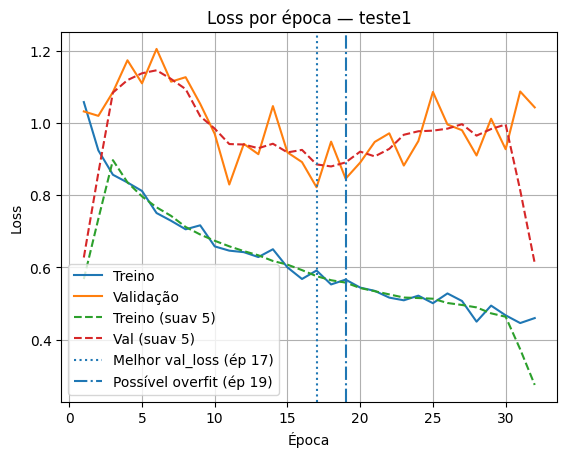

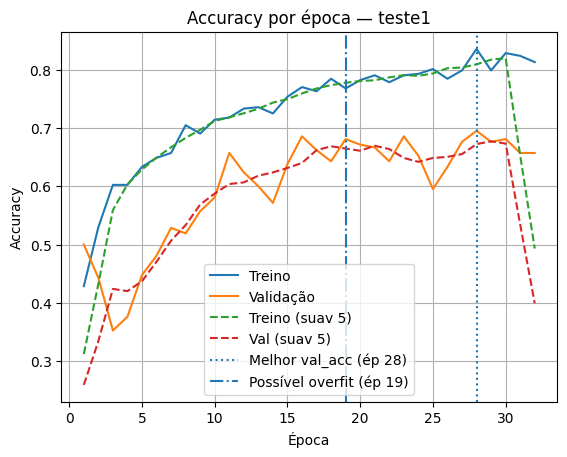


=== RESUMO teste1 ===
Épocas: 32
Melhor val_loss: 0.821841 @ época 17 | gap(loss) nessa época: 0.230511
Melhor val_acc : 0.6952 @ época 28
Overfit (heurística k=3) a partir da época 19
Ganho marginal médio (últimas 5) — val_loss: -0.012648 | val_acc: -0.003810
Acurácia do fold 1: 66.19%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
--> Novo melhor fold encontrado!

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.60      0.64      0.62        70
          MI       0.75      0.61      0.68        70
        NORM       0.65      0.73      0.69        70

    accuracy                           0.66       210
   macro avg       0.67      0.66      0.66       210
weighted avg       0.67      0.66      0.66       210



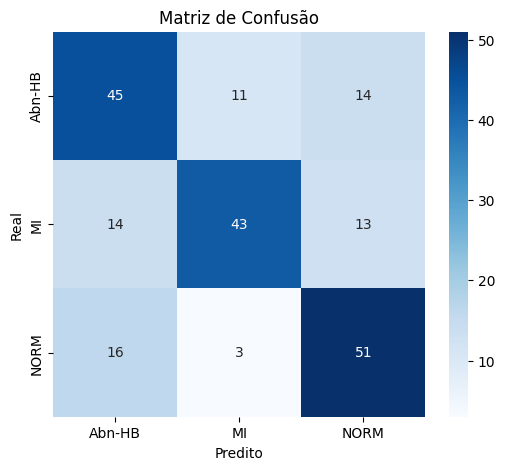


Treinando fold 2/5
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.3995 - loss: 1.1413 - val_accuracy: 0.5381 - val_loss: 1.0283
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5287 - loss: 0.9431 - val_accuracy: 0.5429 - val_loss: 1.0120
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6042 - loss: 0.8670 - val_accuracy: 0.4952 - val_loss: 1.0295
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6318 - loss: 0.8250 - val_accuracy: 0.4810 - val_loss: 1.0271
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6267 - loss: 0.8151 - val_accuracy: 0.4857 - val_loss: 1.0908
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6973 - loss: 0.7412 - val_accuracy: 0.5429 - val_loss: 0.9389
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6560 - loss: 0.7614 - val_accuracy: 0.5238 - val_loss: 0.9921
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6774 - loss: 0.755

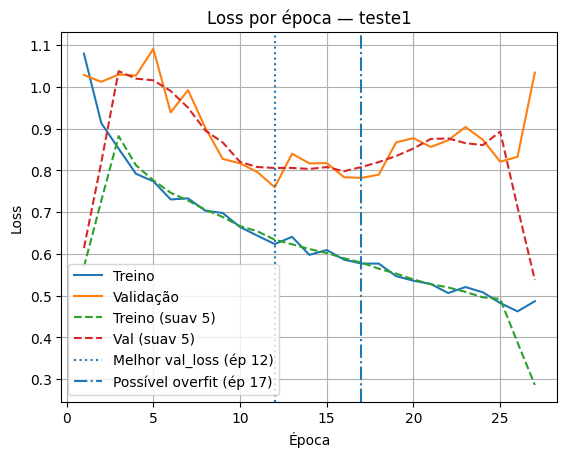

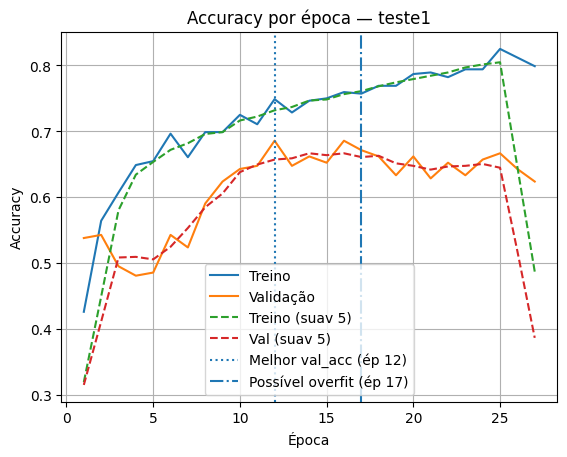


=== RESUMO teste1 ===
Épocas: 27
Melhor val_loss: 0.759477 @ época 12 | gap(loss) nessa época: 0.135895
Melhor val_acc : 0.6857 @ época 12
Overfit (heurística k=3) a partir da época 17
Ganho marginal médio (últimas 5) — val_loss: -0.032421 | val_acc: -0.005714
Acurácia do fold 2: 68.57%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
--> Novo melhor fold encontrado!

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.67      0.50      0.57        70
          MI       0.80      0.61      0.69        70
        NORM       0.63      0.94      0.76        70

    accuracy                           0.69       210
   macro avg       0.70      0.69      0.68       210
weighted avg       0.70      0.69      0.68       210



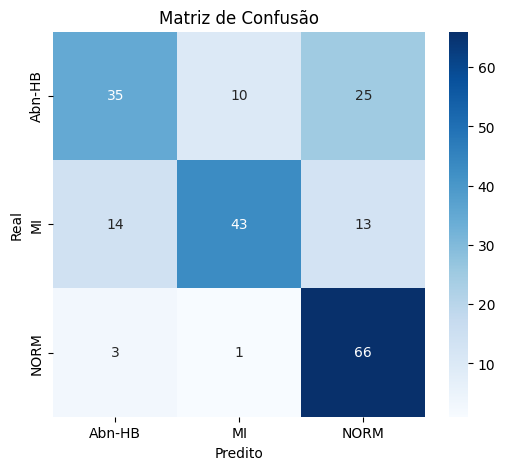


Treinando fold 3/5
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.4432 - loss: 1.0743 - val_accuracy: 0.5476 - val_loss: 1.0295
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5086 - loss: 0.9709 - val_accuracy: 0.4810 - val_loss: 0.9943
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5744 - loss: 0.8679 - val_accuracy: 0.4048 - val_loss: 1.0697
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5595 - loss: 0.8947 - val_accuracy: 0.3905 - val_loss: 1.1955
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5721 - loss: 0.8503 - val_accuracy: 0.4143 - val_loss: 1.2541
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6343 - loss: 0.7823 - val_accuracy: 0.4476 - val_loss: 1.2192
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6454 - loss: 0.8117 - val_accuracy: 0.4667 - val_loss: 1.2476
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6938 - loss: 0.7227 

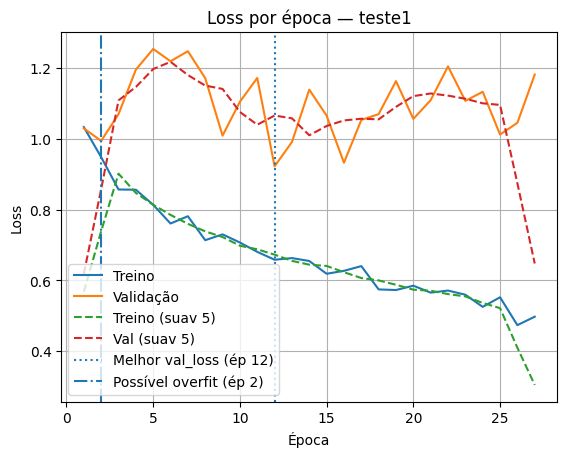

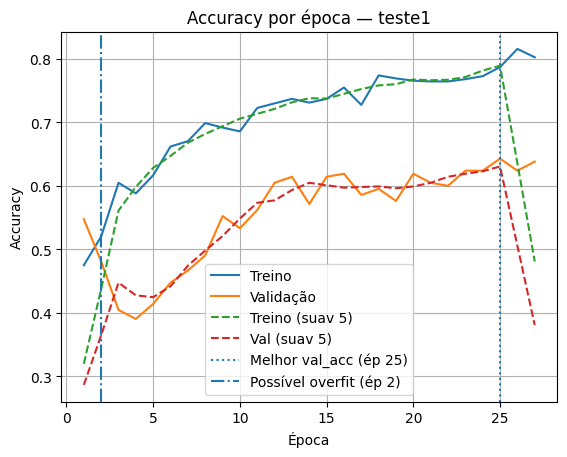


=== RESUMO teste1 ===
Épocas: 27
Melhor val_loss: 0.922236 @ época 12 | gap(loss) nessa época: 0.263810
Melhor val_acc : 0.6429 @ época 25
Overfit (heurística k=3) a partir da época 2
Ganho marginal médio (últimas 5) — val_loss: 0.004622 | val_acc: 0.007619
Acurácia do fold 3: 60.48%


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.57      0.51      0.54        70
          MI       0.86      0.36      0.51        70
        NORM       0.56      0.94      0.70        70

    accuracy                           0.60       210
   macro avg       0.66      0.60      0.58       210
weighted avg       0.66      0.60      0.58       210



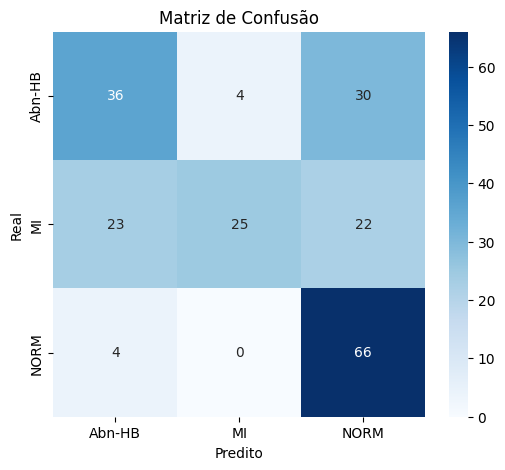


Treinando fold 4/5
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.4016 - loss: 1.1574 - val_accuracy: 0.5714 - val_loss: 1.0304
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5262 - loss: 0.9570 - val_accuracy: 0.3810 - val_loss: 1.0493
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5977 - loss: 0.8737 - val_accuracy: 0.3333 - val_loss: 1.1474
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5987 - loss: 0.8599 - val_accuracy: 0.3381 - val_loss: 1.1592
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6588 - loss: 0.7865 - val_accuracy: 0.3571 - val_loss: 1.1802
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6950 - loss: 0.7309 - val_accuracy: 0.3667 - val_loss: 1.2310
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6973 - loss: 0.7529 - val_accuracy: 0.4000 - val_loss: 1.1832
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6589 - loss: 0.7513 

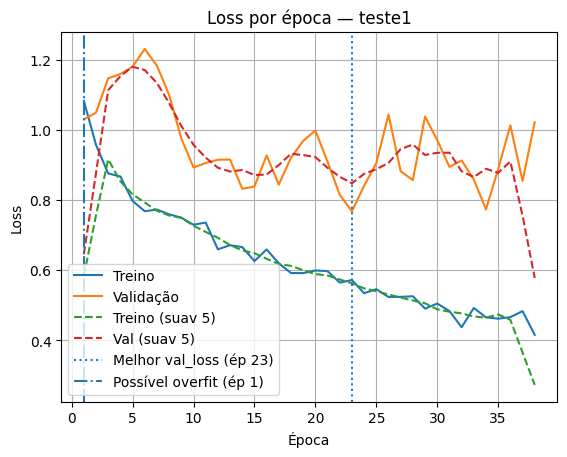

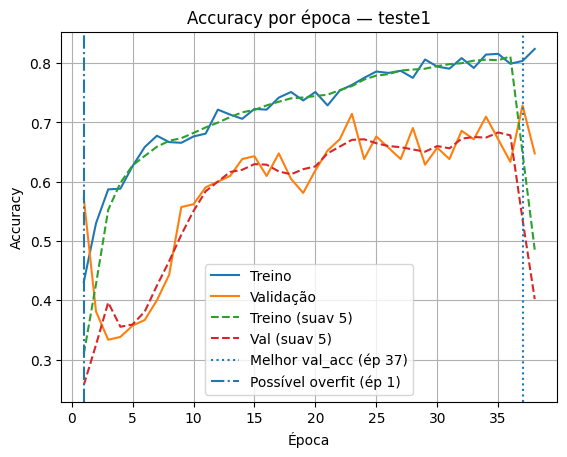


=== RESUMO teste1 ===
Épocas: 38
Melhor val_loss: 0.768167 @ época 23 | gap(loss) nessa época: 0.196103
Melhor val_acc : 0.7286 @ época 37
Overfit (heurística k=3) a partir da época 1
Ganho marginal médio (últimas 5) — val_loss: -0.032619 | val_acc: -0.004762
Acurácia do fold 4: 71.43%


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
--> Novo melhor fold encontrado!

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.71      0.71      0.71        70
          MI       0.88      0.50      0.64        70
        NORM       0.65      0.93      0.76        70

    accuracy                           0.71       210
   macro avg       0.75      0.71      0.71       210
weighted avg       0.75      0.71      0.71       210



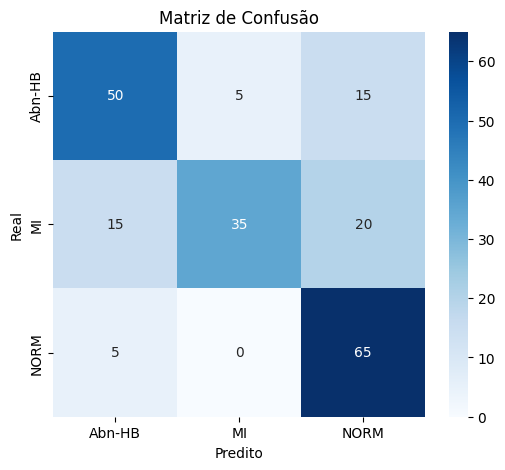


Treinando fold 5/5
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.4063 - loss: 1.1368 - val_accuracy: 0.4381 - val_loss: 1.0738
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5908 - loss: 0.8883 - val_accuracy: 0.3857 - val_loss: 1.0759
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5845 - loss: 0.8618 - val_accuracy: 0.3429 - val_loss: 1.2645
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6262 - loss: 0.8544 - val_accuracy: 0.3476 - val_loss: 1.3001
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6608 - loss: 0.7962 - val_accuracy: 0.3952 - val_loss: 1.3807
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6740 - loss: 0.7462 - val_accuracy: 0.4286 - val_loss: 1.3797
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6954 - loss: 0.7153 - val_accuracy: 0.4524 - val_loss: 1.4786
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6922 - loss: 0.7

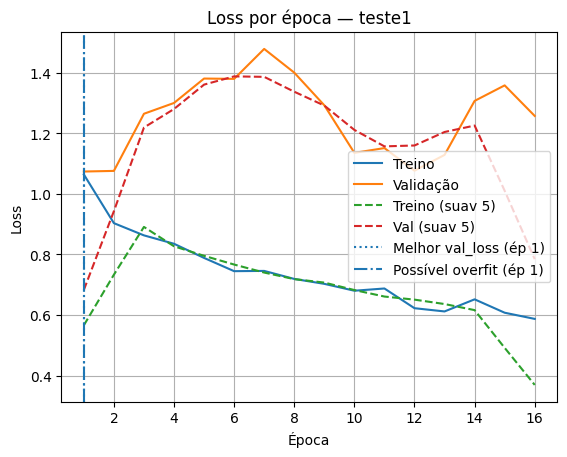

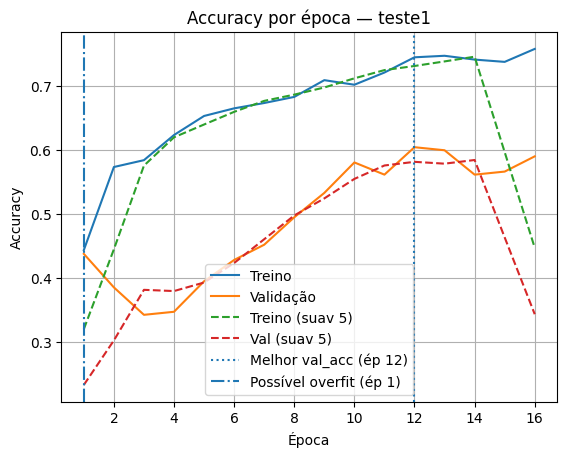


=== RESUMO teste1 ===
Épocas: 16
Melhor val_loss: 1.073840 @ época 1 | gap(loss) nessa época: 0.009597
Melhor val_acc : 0.6048 @ época 12
Overfit (heurística k=3) a partir da época 1
Ganho marginal médio (últimas 5) — val_loss: -0.021219 | val_acc: 0.005714
Acurácia do fold 5: 43.81%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

 Classification Report:
              precision    recall  f1-score   support

      Abn-HB       0.00      0.00      0.00        70
          MI       0.67      0.31      0.43        70
        NORM       0.40      1.00      0.57        70

    accuracy                           0.44       210
   macro avg       0.35      0.44      0.33       210
weighted avg       0.35      0.44      0.33       210



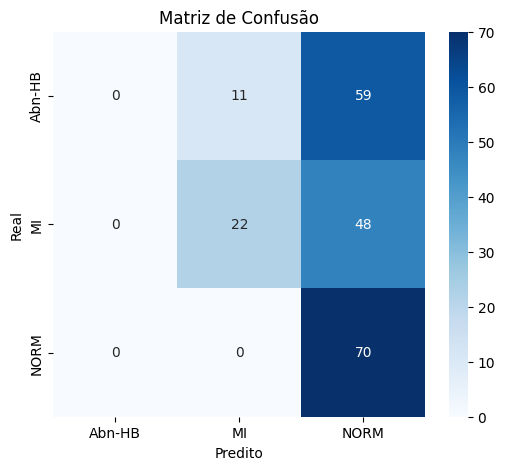


 Acurácias por fold: [66.19047522544861, 68.57143044471741, 60.476189851760864, 71.42857313156128, 43.809524178504944]
 Média final: 62.10% ± 9.83
Salvando resultados do Teste 2 (Melhor Acurácia: 71.43%)
--> Resultados do Teste 2 salvos com sucesso!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# === 1. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")   # Esperado: (300, 407, 12)
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)

print("Shape de X:", X.shape)
print("Classes em y:", np.unique(y))

# Verifica se o shape está correto
assert X.shape[1:] == (407, 12), "Shape incorreto! Esperado: (407, 12)"

# === 2. Normalização Z-score ===
X_reshaped = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

print("Normalização concluída.")

# === 3. One-hot e class weights ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 4. Separando os conjuntos ===

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# ----------------------------------------------------


for fold, (train_index, val_index) in enumerate(kf.split(X, y_int), 1):
    print(f"\nTreinando fold {fold}/5")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === 5. Definindo o modelo CNN 1D ===
    model = Sequential([
        InputLayer(input_shape=(407, 12)),
        Conv1D(64, kernel_size=5),
        LeakyReLU(),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=5),
        LeakyReLU(),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3),
        LeakyReLU(),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001, decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # === 6. Callbacks ===
    callbacks = [
      EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]
    # === 7. Treinamento com class_weight ===
    history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=200,
      batch_size=32,
      callbacks=callbacks,
      verbose=1
    )
    %matplotlib inline
    r = analise_curvas(history, nome="teste1", pasta="/content/cnn_metrics", salvar=True, suav=5)


    # === 8. Avaliação final ===
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc * 100)

    # === 9. Relatório detalhado ===
    y_pred = model.predict(X_val) # Faz a predição uma única vez

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold encontrado!")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

    # === 10. Matriz de Confusão ===
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

# === 11. Resultado final ===
print(f"\n Acurácias por fold: {fold_accuracies}")
print(f" Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")

# --- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
if best_y_true is not None:
    print(f"Salvando resultados do Teste 2 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos do melhor fold
    np.save('resultados_teste2_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste2_y_true.npy', best_y_true)

    # Salva o encoder
    with open('encoder_teste2.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    print("--> Resultados do Teste 2 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")


---
## **Teste 3**

O objetivo deste teste foi avaliar o modelo de classificação de sinais de ECG utilizando validação cruzada estratificada com 5 folds, incorporando técnicas de data augmentation e normalização z-score. A arquitetura utilizada foi uma CNN 1D projetada para capturar padrões temporais robustos nos sinais multivariados.


**Implementação do Teste 3:**

*Função de Data Augmentation*

A primeira etapa do código é a definição da função augment_ecg_signals. Esta função é crucial para aumentar a quantidade de dados de treino e a robustez do modelo. Ela aplica quatro tipos de transformações aleatórias aos sinais de ECG:

* **Ruído Gaussiano**: Adiciona um pequeno ruído aleatório ao sinal para simular pequenas variações e imperfeições na coleta de dados.

* **Deslocamento Temporal** (Shift): Move o sinal levemente para a esquerda ou direita no tempo, simulando pequenas variações no momento em que o batimento cardíaco é capturado.

* **Escala de Amplitude (Scale)**: Altera a amplitude do sinal, simulando variações na intensidade do sinal de ECG.

* **Inversão Aleatória**: Inverte o sinal verticalmente, uma técnica menos comum, mas que pode ajudar a rede a aprender padrões que não dependem da polaridade do sinal.

*Preparação e Normalização dos Dados*

* **Carregamento dos Dados**: Os dados pré-processados (X_final.npy e y_final.npy) são carregados.

* **Aplicação do Augmentation**: A função augment_ecg_signals é chamada para triplicar a quantidade de dados (factor=2 + os dados originais).

* **Normalização Z-score**: Os dados são normalizados usando StandardScaler da biblioteca scikit-learn. Esta etapa é essencial para padronizar os sinais, fazendo com que a média de cada canal seja 0 e o desvio padrão seja 1. Isso garante que a rede neural não dê preferência a canais com amplitudes maiores.

Shape original: (1050, 407, 12)
Após augmentation: (3150, 407, 12)
⚖️ Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

Treinando fold 1/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.4580 - loss: 1.0368 - val_accuracy: 0.5698 - val_loss: 0.9872
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5772 - loss: 0.8754 - val_accuracy: 0.5889 - val_loss: 0.9142
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6200 - loss: 0.8309 - val_accuracy: 0.6270 - val_loss: 0.8427
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6469 - loss: 0.7849 - val_accuracy: 0.6746 - val_loss: 0.7683
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6760 - loss: 0.7515 - val_accuracy: 0.7048 - val_loss: 0.7062
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6995 - loss: 0.7196 - val_accuracy: 0.7238 - val_loss: 0.6945
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━

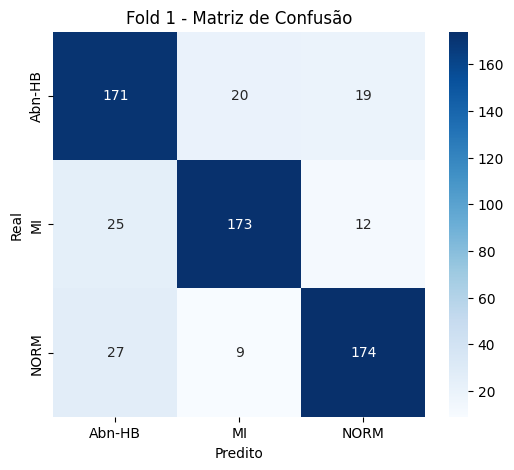


Treinando fold 2/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.4282 - loss: 1.0988 - val_accuracy: 0.5651 - val_loss: 1.0184
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5938 - loss: 0.8663 - val_accuracy: 0.6000 - val_loss: 0.9197
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6309 - loss: 0.8074 - val_accuracy: 0.6714 - val_loss: 0.8192
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6466 - loss: 0.7748 - val_accuracy: 0.6571 - val_loss: 0.7698
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6837 - loss: 0.7304 - val_accuracy: 0.6746 - val_loss: 0.7340
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6850 - loss: 0.7236 - val_accuracy: 0.6667 - val_loss: 0.7253
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7094 - loss: 0.6829 - val_accuracy: 0.7079 - val_loss: 0.6970
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6966 - loss: 0.6807 - va

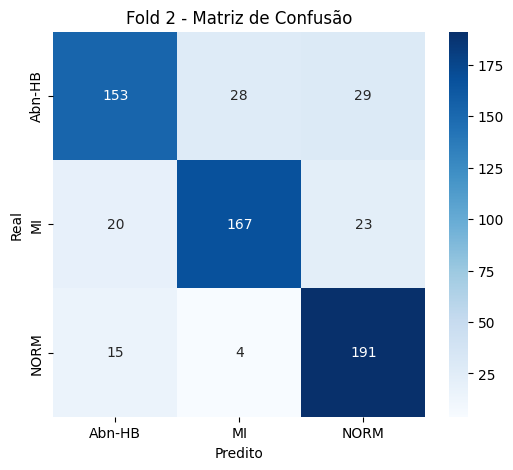


Treinando fold 3/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4405 - loss: 1.0468 - val_accuracy: 0.4175 - val_loss: 1.0097
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5824 - loss: 0.8764 - val_accuracy: 0.5254 - val_loss: 0.9436
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6327 - loss: 0.8106 - val_accuracy: 0.6063 - val_loss: 0.8417
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6541 - loss: 0.7659 - val_accuracy: 0.6302 - val_loss: 0.7869
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6570 - loss: 0.7377 - val_accuracy: 0.6524 - val_loss: 0.7260
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6813 - loss: 0.7145 - val_accuracy: 0.6381 - val_loss: 0.7498
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6975 - loss: 0.6917 - val_accuracy: 0.6651 - val_loss: 0.7101
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7126 - loss: 0.6633 - va

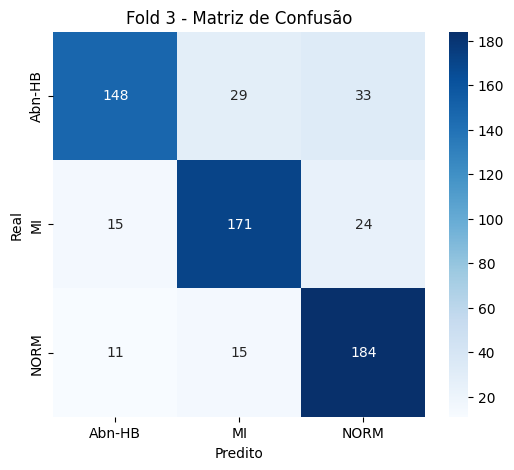


Treinando fold 4/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4448 - loss: 1.0633 - val_accuracy: 0.5095 - val_loss: 0.9918
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5923 - loss: 0.8748 - val_accuracy: 0.5889 - val_loss: 0.9068
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6346 - loss: 0.8019 - val_accuracy: 0.6603 - val_loss: 0.8051
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6689 - loss: 0.7557 - val_accuracy: 0.6556 - val_loss: 0.7580
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6719 - loss: 0.7414 - val_accuracy: 0.6508 - val_loss: 0.7329
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6960 - loss: 0.7164 - val_accuracy: 0.6571 - val_loss: 0.7160
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6786 - loss: 0.7078 - val_accuracy: 0.6984 - val_loss: 0.6854
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6992 - loss: 0.6789 - va

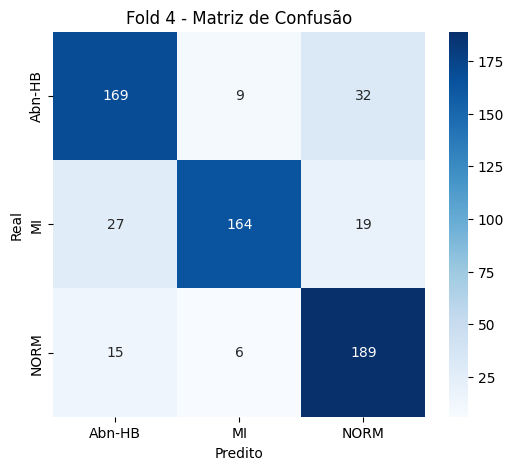


Treinando fold 5/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4575 - loss: 1.0348 - val_accuracy: 0.4381 - val_loss: 1.0207
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5777 - loss: 0.8697 - val_accuracy: 0.4730 - val_loss: 0.9665
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6390 - loss: 0.8110 - val_accuracy: 0.5984 - val_loss: 0.8408
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6625 - loss: 0.7670 - val_accuracy: 0.6397 - val_loss: 0.7703
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6809 - loss: 0.7250 - val_accuracy: 0.6587 - val_loss: 0.7322
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7135 - loss: 0.7072 - val_accuracy: 0.6841 - val_loss: 0.7132
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7051 - loss: 0.6905 - val_accuracy: 0.6730 - val_loss: 0.6976
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7023 - loss: 0.6955 - va

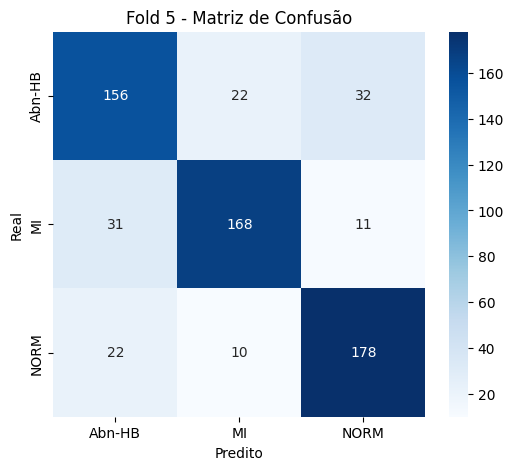


 Acurácias por fold: [82.22222328186035, 81.11110925674438, 79.84126806259155, 82.85714387893677, 79.68254089355469]
 Média final: 81.14% ± 1.26
[OK] Curvas do melhor fold salvas em:
   - /content/cnn_metrics/metrics_cnn_best_fold4.npz
   - /content/cnn_metrics/metrics_cnn_best.npz

Salvando resultados do Teste 3 (Melhor Acurácia: 82.86%)
--> Resultados do Teste 3 salvos com sucesso!


In [ ]:
import numpy as np
import os, pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- helper para salvar métricas de um history em .npz (para plot posterior)
def salvar_para_analise(history, base, pasta="/content/cnn_metrics"):
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    ep = np.arange(1, len(H["loss"])+1)
    np.savez_compressed(
        os.path.join(pasta, f"metrics_{base}.npz"),
        epoch=ep,
        loss=np.array(H["loss"]),
        val_loss=np.array(H.get("val_loss", [])),
        acc=np.array(H.get("accuracy", [])),
        val_acc=np.array(H.get("val_accuracy", [])),
    )

# === 1. Função de data augmentation ===
def augment_ecg_signals(X, y, factor=2):
    np.random.seed(42)
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        for _ in range(factor):
            signal = X[i]

            # 1. Ruído Gaussiano
            noise = np.random.normal(0, 0.01, signal.shape)
            noisy_signal = signal + noise

            # 2. Deslocamento temporal
            shift = np.random.randint(-10, 10)
            shifted_signal = np.roll(noisy_signal, shift, axis=0)

            # 3. Escala de amplitude
            scale = np.random.uniform(0.9, 1.1)
            scaled_signal = shifted_signal * scale

            # 4. Inversão aleatória
            if np.random.rand() > 0.5:
                scaled_signal = -scaled_signal

            augmented_X.append(scaled_signal)
            augmented_y.append(y[i])

    return np.concatenate([X, np.array(augmented_X)]), np.concatenate([y, np.array(augmented_y)])

# ----- Configuração do critério do "melhor fold" -----
SELECT_BY = "val_accuracy"            # use "val_loss" se preferir
BEST_DIR  = "/content/cnn_metrics"    # onde salvar as curvas .npz

# Estado do melhor fold (UM ÚNICO critério)
best_score = -np.inf if SELECT_BY == "val_accuracy" else np.inf
best_fold  = None
best_hist  = None
best_y_pred_proba = None
best_y_true       = None


# === 2. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)

print("Shape original:", X.shape)

# === 3. Aplicando data augmentation ===
X, y = augment_ecg_signals(X, y, factor=2)
print("Após augmentation:", X.shape)

# === 4. Normalização Z-score ===
X_reshaped = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

# === 5. Codificação de rótulos e pesos ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 6. Cross-validation com 5 folds ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# -----------------------------------------------------------------

for fold, (train_index, val_index) in enumerate(kf.split(X, y_int), 1):
    print(f"\nTreinando fold {fold}/5")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === 7. Modelo CNN ===
    model = Sequential([
        InputLayer(input_shape=(407, 12)),

        Conv1D(64, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.3),

        Conv1D(128, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.3),

        GlobalAveragePooling1D(),
        Dense(64, activation='relu'), Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]

    # === 8. Treinamento ===
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )


    # === 9. Avaliação ===
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc * 100)
    y_pred = model.predict(X_val) # Faz a predição uma única vez

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold (por acurácia)! {acc*100:.2f}%")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)
        best_hist = history          # <-- [NOVO] salva curvas deste mesmo fold
        best_fold = fold             # <-- [NOVO] salva o índice do fold
    # ----------------------------------------------------------------------

    # === 10. Relatório e Confusão ===
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Fold {fold} - Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# === 11. Resultado final ===
print(f"\n Acurácias por fold: {fold_accuracies}")
print(f" Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")

# --- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
if best_hist is not None:
    os.makedirs(BEST_DIR, exist_ok=True)
    base = f"cnn_best_fold{best_fold}"
    salvar_para_analise(best_hist, base=base, pasta=BEST_DIR)
    # (opcional) alias fixo para facilitar carregar depois
    salvar_para_analise(best_hist, base="cnn_best", pasta=BEST_DIR)
    print(f"[OK] Curvas do melhor fold salvas em:")
    print(f"   - {BEST_DIR}/metrics_{base}.npz")
    print(f"   - {BEST_DIR}/metrics_cnn_best.npz")
else:
    print("AVISO: best_hist=None. Não há curvas para salvar.")

if best_y_true is not None:
    print(f"\nSalvando resultados do Teste 3 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos, nomeando como 'teste4'
    np.save('resultados_teste3_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste3_y_true.npy', best_y_true)

    # Salva o encoder, nomeando como 'teste4'
    with open('encoder_teste3.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    print("--> Resultados do Teste 3 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")

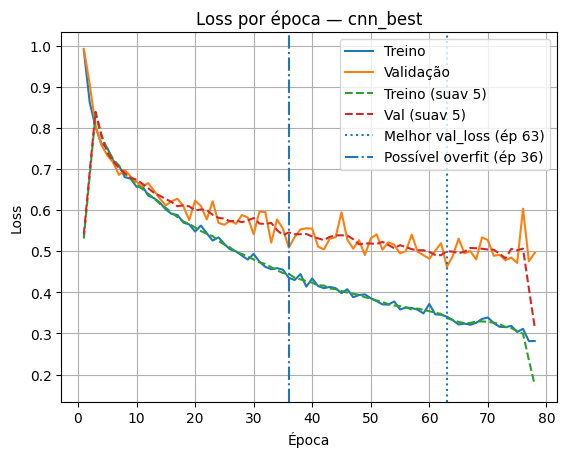

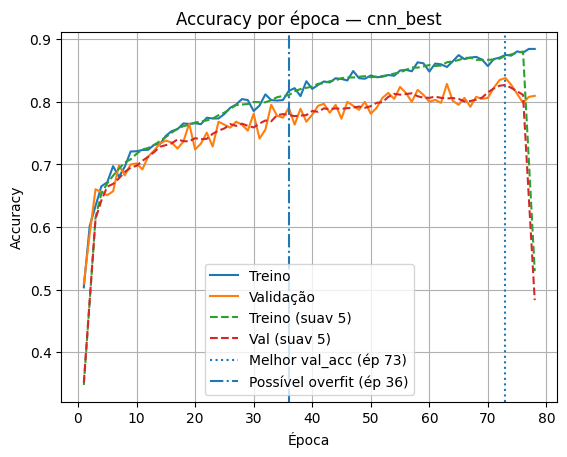


=== RESUMO cnn_best ===
Épocas: 78
Melhor val_loss: 0.461862 @ época 63 | gap(loss) nessa época: 0.121149
Melhor val_acc : 0.8381 @ época 73
Overfit (heurística k=3) a partir da época 36
Ganho marginal médio (últimas 5) — val_loss: -0.003678 | val_acc: -0.005714


In [ ]:
import numpy as np

# helper: recria um objeto "history-like" a partir do .npz salvo
def carrega_history_npz(path_npz):
    d = np.load(path_npz, allow_pickle=True)
    class H: pass
    h = H()
    h.history = {
        "loss":        d["loss"].tolist(),
        "val_loss":    d["val_loss"].tolist() if "val_loss" in d.files else [],
        "accuracy":    d["acc"].tolist()      if "acc"      in d.files else [],
        "val_accuracy":d["val_acc"].tolist()  if "val_acc"  in d.files else [],
    }
    return h

# caminho do arquivo salvo (ajuste um deles conforme o que você salvou)
BEST_DIR = "/content/cnn_metrics"
path_npz = f"{BEST_DIR}/metrics_cnn_best.npz"              # alias fixo (se você salvou)
# path_npz = f"{BEST_DIR}/metrics_cnn_best_fold3.npz"      # exemplo com número do fold

h = carrega_history_npz(path_npz)

# agora use sua própria função já definida na célula 1
_ = analise_curvas(h, nome="cnn_best", pasta=BEST_DIR, salvar=False, suav=5)


---
## **Teste 4**

Este teste utiliza uma arquitetura de duas vias para processar os dados:

1. **Ramo CNN 1D:** Opera diretamente sobre o sinal bruto de ECG (com dimensão de 407x12), sendo responsável por capturar padrões temporais e morfológicos complexos nas ondas do eletrocardiograma.

2. **Ramo MLP (Rede Neural Multicamadas):** Processa um conjunto de 204 características (features) extraídas de cada um dos 12 canais do ECG. Essas características incluem:

  - **Features Estatísticas:** Média, desvio padrão, mínimo e máximo.

  - **Features de Frequência:** 10 coeficientes da Transformada Rápida de Fourier (FFT).

  - **Features Wavelet:** 3 coeficientes da Transformada Wavelet Discreta (DWT).

As saídas de ambos os ramos são então concatenadas e processadas por uma camada MLP final, que realiza a classificação utilizando uma função de ativação softmax.

Após augmentation: (3150, 407, 12)
Shape das features: (3150, 204)
⚖️ Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

 Fold 1/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.3796 - loss: 1.1482 - val_accuracy: 0.5206 - val_loss: 0.9630
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5922 - loss: 0.8708 - val_accuracy: 0.5746 - val_loss: 0.9080
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6557 - loss: 0.7580 - val_accuracy: 0.6127 - val_loss: 0.8265
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6854 - loss: 0.7075 - val_accuracy: 0.6825 - val_loss: 0.7294
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7195 - loss: 0.6494 - val_accuracy: 0.7111 - val_loss: 0.6784
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7627 - loss: 0.5849 - val_accuracy: 0.7381 - val_loss: 0.6212
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

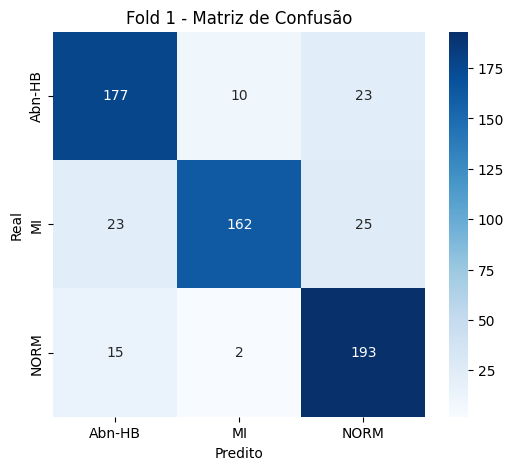


 Fold 2/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.4164 - loss: 1.1321 - val_accuracy: 0.5524 - val_loss: 0.9227
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5790 - loss: 0.8644 - val_accuracy: 0.5984 - val_loss: 0.8555
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6496 - loss: 0.7707 - val_accuracy: 0.6651 - val_loss: 0.7485
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6984 - loss: 0.6836 - val_accuracy: 0.7127 - val_loss: 0.6645
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7431 - loss: 0.6048 - val_accuracy: 0.7508 - val_loss: 0.6034
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7551 - loss: 0.5670 - val_accuracy: 0.7365 - val_loss: 0.5770
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7924 - loss: 0.4991 - val_accuracy: 0.7571 - val_loss: 0.5518
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8155 - loss: 0.4483 - val_accurac

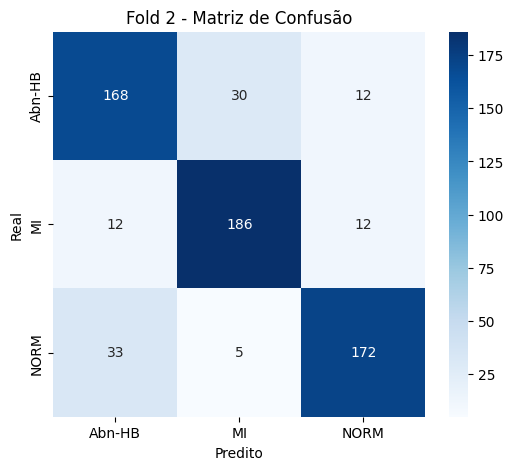


 Fold 3/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4012 - loss: 1.1744 - val_accuracy: 0.5730 - val_loss: 0.9300
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6223 - loss: 0.8311 - val_accuracy: 0.6063 - val_loss: 0.8654
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6740 - loss: 0.7465 - val_accuracy: 0.6714 - val_loss: 0.7606
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7239 - loss: 0.6556 - val_accuracy: 0.7254 - val_loss: 0.6698
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7458 - loss: 0.6075 - val_accuracy: 0.7349 - val_loss: 0.6328
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7749 - loss: 0.5457 - val_accuracy: 0.7222 - val_loss: 0.6249
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7917 - loss: 0.5009 - val_accuracy: 0.7492 - val_loss: 0.5945
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8189 - loss: 0.4527 - val_accurac

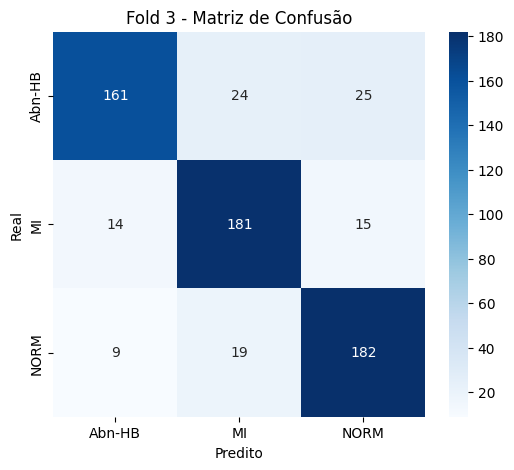


 Fold 4/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.4235 - loss: 1.1206 - val_accuracy: 0.5984 - val_loss: 0.8963
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5970 - loss: 0.8509 - val_accuracy: 0.6905 - val_loss: 0.7811
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6753 - loss: 0.7367 - val_accuracy: 0.7095 - val_loss: 0.7113
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7171 - loss: 0.6531 - val_accuracy: 0.7286 - val_loss: 0.6556
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7680 - loss: 0.5929 - val_accuracy: 0.7460 - val_loss: 0.6001
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7684 - loss: 0.5543 - val_accuracy: 0.7508 - val_loss: 0.5689
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7942 - loss: 0.4991 - val_accuracy: 0.7413 - val_loss: 0.5944
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8356 - loss: 0.4401 - val_accurac

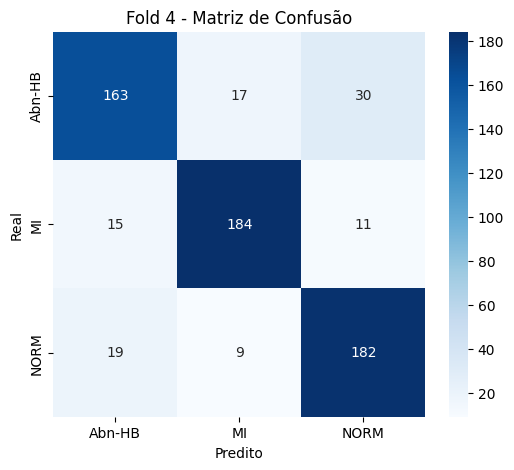


 Fold 5/5
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4633 - loss: 1.0845 - val_accuracy: 0.5365 - val_loss: 0.9379
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6032 - loss: 0.8366 - val_accuracy: 0.5667 - val_loss: 0.9094
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6760 - loss: 0.7458 - val_accuracy: 0.6619 - val_loss: 0.7529
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7259 - loss: 0.6608 - val_accuracy: 0.7063 - val_loss: 0.6732
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7528 - loss: 0.5875 - val_accuracy: 0.7333 - val_loss: 0.6470
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7853 - loss: 0.5348 - val_accuracy: 0.7460 - val_loss: 0.6068
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8045 - loss: 0.4827 - val_accuracy: 0.7540 - val_loss: 0.5835
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8453 - loss: 0.4256 - val_accurac

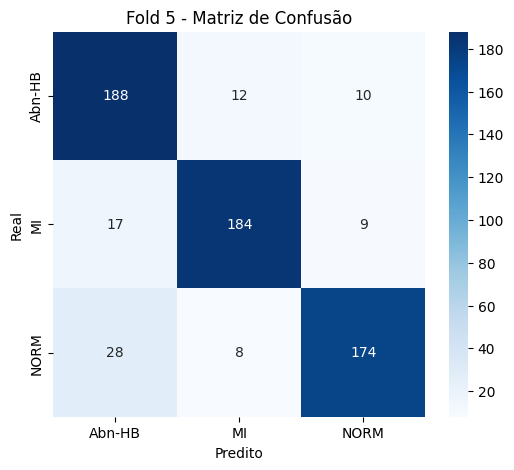


 Acurácias por fold: [84.44444537162781, 83.49206447601318, 83.17460417747498, 83.96825194358826, 86.66666746139526]
Média final: 84.35% ± 1.24
[OK] Curvas do melhor fold salvas em:
   - /content/cnn_metrics/metrics_cnn_best_fold5.npz
   - /content/cnn_metrics/metrics_cnn_best.npz

Salvando resultados do Teste 4 (Melhor Acurácia: 86.67%)
--> Resultados do Teste 4 salvos com sucesso!


In [ ]:
import numpy as np
import pywt
import os, pickle
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout,
                                     GlobalAveragePooling1D, Dense, LeakyReLU, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# --- helper para salvar métricas de um history em .npz (para plot posterior)
def salvar_para_analise(history, base, pasta="/content/cnn_metrics"):
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    ep = np.arange(1, len(H["loss"])+1)
    np.savez_compressed(
        os.path.join(pasta, f"metrics_{base}.npz"),
        epoch=ep,
        loss=np.array(H["loss"]),
        val_loss=np.array(H.get("val_loss", [])),
        acc=np.array(H.get("accuracy", [])),
        val_acc=np.array(H.get("val_accuracy", [])),
    )

# === 1. Data augmentation ===
def augment_ecg_signals(X, y, factor=2):
    np.random.seed(42)
    augmented_X, augmented_y = [], []

    for i in range(len(X)):
        for _ in range(factor):
            signal = X[i]
            noise = np.random.normal(0, 0.01, signal.shape)
            shifted = np.roll(signal + noise, np.random.randint(-10, 10), axis=0)
            scaled = shifted * np.random.uniform(0.9, 1.1)
            if np.random.rand() > 0.5:
                scaled = -scaled
            augmented_X.append(scaled)
            augmented_y.append(y[i])

    return np.concatenate([X, augmented_X]), np.concatenate([y, augmented_y])

# ----- Configuração do critério do "melhor fold" -----
SELECT_BY = "val_accuracy"            # use "val_loss" se preferir
BEST_DIR  = "/content/cnn_metrics"    # onde salvar as curvas .npz

# Estado do melhor fold (UM ÚNICO critério)
best_score = -np.inf if SELECT_BY == "val_accuracy" else np.inf
best_fold  = None
best_hist  = None
best_y_pred_proba = None
best_y_true       = None


# === 2. Extração de características (Fourier, estatísticas, DWT) ===
def extract_features(signal):
    stats = []
    for lead in signal.T:
        # Estatísticas
        stats += [np.mean(lead), np.std(lead), np.min(lead), np.max(lead)]
        # Fourier
        fft = np.fft.fft(lead)
        fft_mag = np.abs(fft)[:10]
        stats += list(fft_mag)
        # DWT
        coeffs = pywt.wavedec(lead, 'db1', level=2)
        stats += [np.mean(c) for c in coeffs]
    return np.array(stats)

# === 3. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)
X, y = augment_ecg_signals(X, y, factor=2)
print("Após augmentation:", X.shape)

# === 4. Extração de características ===
X_feat = np.array([extract_features(sample) for sample in X])
print("Shape das features:", X_feat.shape)

# === 5. Normalizações ===
X = StandardScaler().fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
X_feat = StandardScaler().fit_transform(X_feat)

# === 6. Codificação de rótulos e pesos ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 7. Cross-validation com 5 folds ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# -----------------------------------------------------------------


for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_int), 1):
    print(f"\n Fold {fold}/5")

    X_train, X_val = X[train_idx], X[val_idx]
    X_feat_train, X_feat_val = X_feat[train_idx], X_feat[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    # === 8. Modelo com dois inputs ===
    input_signal = Input(shape=(407, 12))
    x = Conv1D(64, 5, padding='same')(input_signal)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D()(x); x = Dropout(0.3)(x)

    x = Conv1D(128, 5, padding='same')(x)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D()(x); x = Dropout(0.3)(x)

    x = GlobalAveragePooling1D()(x)

    input_feat = Input(shape=(X_feat.shape[1],))
    f = Dense(64, activation='relu')(input_feat)

    combined = Concatenate()([x, f])
    out = Dense(64, activation='relu')(combined)
    out = Dropout(0.5)(out)
    out = Dense(3, activation='softmax')(out)

    model = Model(inputs=[input_signal, input_feat], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001, decay=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # === 9. Treinamento ===
    history = model.fit(
        [X_train, X_feat_train], y_train,
        validation_data=([X_val, X_feat_val], y_val),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
        class_weight=class_weight_dict,
        verbose=1
    )



    # === 10. Avaliação ===
    loss, acc = model.evaluate([X_val, X_feat_val], y_val, verbose=0)
    print(f"🔹 Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc * 100)
    y_pred = model.predict([X_val, X_feat_val]) # Predição feita uma única vez

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold encontrado! Acurácia: {acc*100:.2f}%")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)
        best_hist = history          # <-- [NOVO] salva curvas deste mesmo fold
        best_fold = fold             # <-- [NOVO] salva o índice do fold
    # ----------------------------------------------------------------------

    # === 11. Relatório e Confusão ===
    y_pred = model.predict([X_val, X_feat_val])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Fold {fold} - Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# === 12. Resultado final ===
print(f"\n Acurácias por fold: {fold_accuracies}")
print(f"Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")

# --- ADIÇÃO 3: salvar CURVAS do melhor fold (por acurácia) ---
if best_hist is not None:
    os.makedirs(BEST_DIR, exist_ok=True)
    base = f"cnn_best_fold{best_fold}"
    salvar_para_analise(best_hist, base=base, pasta=BEST_DIR)
    # (opcional) alias fixo para facilitar carregar depois
    salvar_para_analise(best_hist, base="cnn_best", pasta=BEST_DIR)
    print(f"[OK] Curvas do melhor fold salvas em:")
    print(f"   - {BEST_DIR}/metrics_{base}.npz")
    print(f"   - {BEST_DIR}/metrics_cnn_best.npz")
else:
    print("AVISO: best_hist=None. Não há curvas para salvar.")


 #--- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
if best_y_true is not None:
    print(f"\nSalvando resultados do Teste 4 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos, nomeando como 'teste5'
    np.save('resultados_teste4_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste4_y_true.npy', best_y_true)

    # Salva o encoder, nomeando como 'teste5'
    with open('encoder_teste4.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    print("--> Resultados do Teste 4 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")

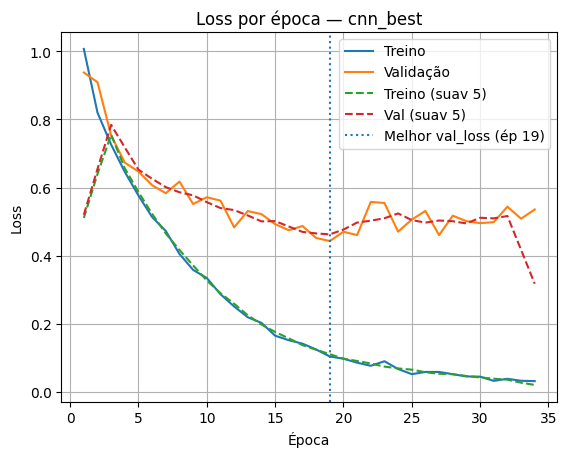

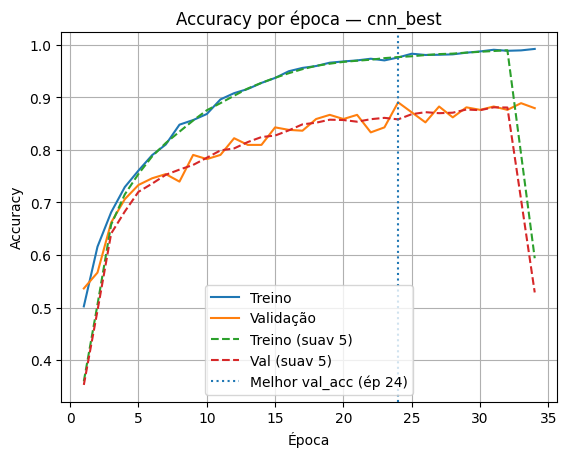


=== RESUMO cnn_best ===
Épocas: 34
Melhor val_loss: 0.442977 @ época 19 | gap(loss) nessa época: 0.338872
Melhor val_acc : 0.8905 @ época 24
Ganho marginal médio (últimas 5) — val_loss: -0.006845 | val_acc: -0.000317


In [ ]:
import numpy as np

# helper: recria um objeto "history-like" a partir do .npz salvo
def carrega_history_npz(path_npz):
    d = np.load(path_npz, allow_pickle=True)
    class H: pass
    h = H()
    h.history = {
        "loss":        d["loss"].tolist(),
        "val_loss":    d["val_loss"].tolist() if "val_loss" in d.files else [],
        "accuracy":    d["acc"].tolist()      if "acc"      in d.files else [],
        "val_accuracy":d["val_acc"].tolist()  if "val_acc"  in d.files else [],
    }
    return h

# caminho do arquivo salvo (ajuste um deles conforme o que você salvou)
BEST_DIR = "/content/cnn_metrics"
path_npz = f"{BEST_DIR}/metrics_cnn_best.npz"              # alias fixo (se você salvou)
# path_npz = f"{BEST_DIR}/metrics_cnn_best_fold3.npz"      # exemplo com número do fold

h = carrega_history_npz(path_npz)

# agora use sua própria função já definida na célula 1
_ = analise_curvas(h, nome="cnn_best", pasta=BEST_DIR, salvar=False, suav=5)


---
## **Teste 5**

Este teste representa o principal upgrade de arquitetura sobre os modelos base, estabelecendo uma CNN mais profunda e robusta, projetada para extrair o máximo de informação diretamente do sinal bruto. As chaves deste experimento são:

- **Arquitetura de Alta Capacidade:**

  - A rede é significativamente maior, com blocos convolucionais de 128 e 256 filtros, permitindo o aprendizado de padrões mais complexos.

  - Forte regularização (Dropout de 0.4 e 0.5) é aplicada para evitar que este modelo maior memorize os dados de treino.

- **Dados e Treinamento Eficiente:**

  - Uso intensivo de Data Augmentation (fator 3), que triplica o dataset com variações de ruído, escala, deslocamento e inversão do sinal.

  - O treinamento é validado com 5-Fold Cross-Validation e otimizado com EarlyStopping (paciência 20) para garantir um resultado estável e eficiente.

Shape original: (1050, 407, 12)
Após augmentation: (4200, 407, 12)
Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

Treinando fold 1/5
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4555 - loss: 1.0282 - val_accuracy: 0.4357 - val_loss: 0.9893
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6169 - loss: 0.8283 - val_accuracy: 0.5714 - val_loss: 0.8664
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6509 - loss: 0.7724 - val_accuracy: 0.6726 - val_loss: 0.7266
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6810 - loss: 0.7309 - val_accuracy: 0.7155 - val_loss: 0.6599
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6895 - loss: 0.7096 - val_accuracy: 0.7095 - val_loss: 0.6487
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7058 - loss: 0.6851 - val_accuracy: 0.7071 - val_loss: 0.6432
Epoch 7/100
105/105 ━━━━━━━━━━

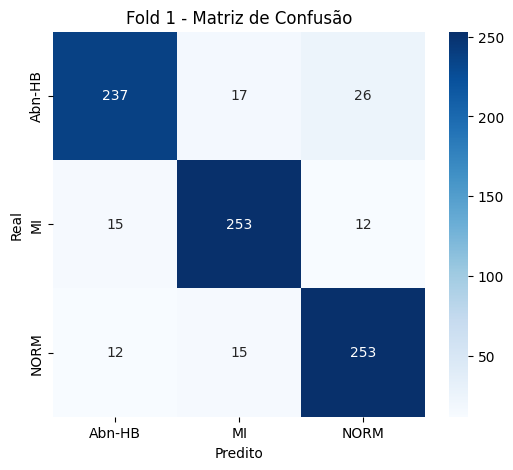


Treinando fold 2/5
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4628 - loss: 1.0282 - val_accuracy: 0.5512 - val_loss: 0.9527
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6189 - loss: 0.8373 - val_accuracy: 0.6000 - val_loss: 0.8260
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6633 - loss: 0.7741 - val_accuracy: 0.6595 - val_loss: 0.7461
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6634 - loss: 0.7365 - val_accuracy: 0.6595 - val_loss: 0.7386
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6997 - loss: 0.6971 - val_accuracy: 0.6869 - val_loss: 0.6843
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7030 - loss: 0.6908 - val_accuracy: 0.6857 - val_loss: 0.6930
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7202 - loss: 0.6663 - val_accuracy: 0.7155 - val_loss: 0.6526
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7289 - lo

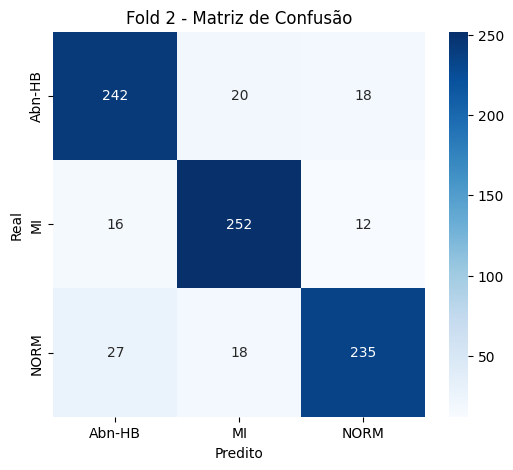


Treinando fold 3/5
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4839 - loss: 1.0050 - val_accuracy: 0.5226 - val_loss: 0.9501
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6127 - loss: 0.8351 - val_accuracy: 0.5845 - val_loss: 0.8584
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6498 - loss: 0.7835 - val_accuracy: 0.6964 - val_loss: 0.7336
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6612 - loss: 0.7487 - val_accuracy: 0.6964 - val_loss: 0.7061
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6858 - loss: 0.7198 - val_accuracy: 0.7345 - val_loss: 0.6630
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6879 - loss: 0.6945 - val_accuracy: 0.7238 - val_loss: 0.6571
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6980 - loss: 0.6824 - val_accuracy: 0.7524 - val_loss: 0.6137
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7148 - lo

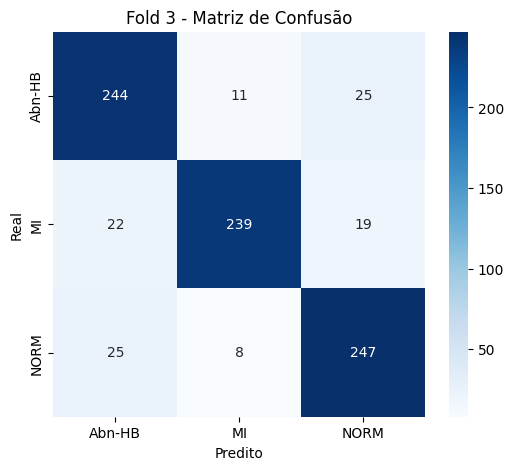


Treinando fold 4/5
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4612 - loss: 1.0336 - val_accuracy: 0.4595 - val_loss: 0.9867
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6187 - loss: 0.8200 - val_accuracy: 0.5750 - val_loss: 0.8791
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6430 - loss: 0.7712 - val_accuracy: 0.6464 - val_loss: 0.7675
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6664 - loss: 0.7488 - val_accuracy: 0.6595 - val_loss: 0.7302
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6932 - loss: 0.7131 - val_accuracy: 0.6964 - val_loss: 0.6656
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7095 - loss: 0.6802 - val_accuracy: 0.7000 - val_loss: 0.6564
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6946 - loss: 0.6644 - val_accuracy: 0.7012 - val_loss: 0.6610
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7181 - lo

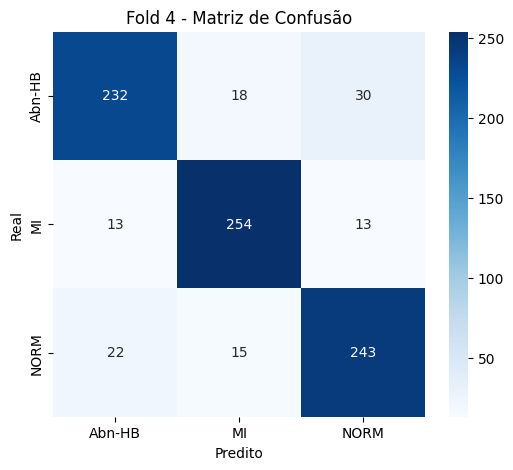


Treinando fold 5/5
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4893 - loss: 1.0016 - val_accuracy: 0.4905 - val_loss: 0.9826
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6299 - loss: 0.7920 - val_accuracy: 0.6095 - val_loss: 0.8657
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6762 - loss: 0.7422 - val_accuracy: 0.6655 - val_loss: 0.7610
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6897 - loss: 0.7124 - val_accuracy: 0.7012 - val_loss: 0.7073
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7138 - loss: 0.6701 - val_accuracy: 0.7000 - val_loss: 0.6547
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7110 - loss: 0.6670 - val_accuracy: 0.7143 - val_loss: 0.6672
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7160 - loss: 0.6519 - val_accuracy: 0.7238 - val_loss: 0.6372
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7440 - lo

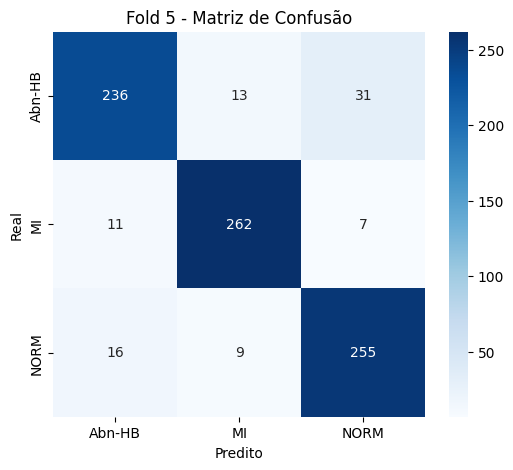


 Acurácias por fold: [88.45238089561462, 86.78571581840515, 86.90476417541504, 86.78571581840515, 89.64285850524902]
Média final: 87.71% ± 1.15
[OK] Curvas do melhor fold salvas em:
   - /content/cnn_metrics/metrics_cnn_best_fold5.npz
   - /content/cnn_metrics/metrics_cnn_best.npz

Salvando resultados do Teste 5 (Melhor Acurácia: 89.64%)
--> Resultados do Teste 5 salvos com sucesso!


In [ ]:
import numpy as np
import tensorflow as tf
import os, pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- helper para salvar métricas de um history em .npz (para plot posterior)
def salvar_para_analise(history, base, pasta="/content/cnn_metrics"):
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    ep = np.arange(1, len(H["loss"])+1)
    np.savez_compressed(
        os.path.join(pasta, f"metrics_{base}.npz"),
        epoch=ep,
        loss=np.array(H["loss"]),
        val_loss=np.array(H.get("val_loss", [])),
        acc=np.array(H.get("accuracy", [])),
        val_acc=np.array(H.get("val_accuracy", [])),
    )

# === 1. Função de data augmentation ===
def augment_ecg_signals(X, y, factor=3):
    np.random.seed(42)
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        for _ in range(factor):
            signal = X[i]

            noise = np.random.normal(0, 0.01, signal.shape)
            noisy_signal = signal + noise

            shift = np.random.randint(-10, 10)
            shifted_signal = np.roll(noisy_signal, shift, axis=0)

            scale = np.random.uniform(0.9, 1.1)
            scaled_signal = shifted_signal * scale

            if np.random.rand() > 0.5:
                scaled_signal = -scaled_signal

            augmented_X.append(scaled_signal)
            augmented_y.append(y[i])

    return np.concatenate([X, np.array(augmented_X)]), np.concatenate([y, np.array(augmented_y)])

# ----- Configuração do critério do "melhor fold" -----
SELECT_BY = "val_accuracy"            # use "val_loss" se preferir
BEST_DIR  = "/content/cnn_metrics"    # onde salvar as curvas .npz

# Estado do melhor fold (UM ÚNICO critério)
best_score = -np.inf if SELECT_BY == "val_accuracy" else np.inf
best_fold  = None
best_hist  = None
best_y_pred_proba = None
best_y_true       = None

# === 2. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)
print("Shape original:", X.shape)

# === 3. Aplicando data augmentation ===
X, y = augment_ecg_signals(X, y, factor=3)
print("Após augmentation:", X.shape)

# === 4. Normalização ===
X_reshaped = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

# === 5. Codificação de rótulos ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 6. Cross-validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# -----------------------------------------------------------------

for fold, (train_index, val_index) in enumerate(kf.split(X, y_int), 1):
    print(f"\nTreinando fold {fold}/5")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === 7. Modelo CNN otimizado ===
    model = Sequential([
        InputLayer(input_shape=(407, 12)),

        Conv1D(128, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.4),

        Conv1D(256, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.4),

        GlobalAveragePooling1D(),
        Dense(128, activation='relu'), Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )


    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc * 100)

    y_pred = model.predict(X_val) # Predição feita uma única vez

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold encontrado! Acurácia: {acc*100:.2f}%")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)
        best_hist = history          # <-- [NOVO] salva curvas deste mesmo fold
        best_fold = fold             # <-- [NOVO] salva o índice do fold
    # ----------------------------------------------------------------------

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Fold {fold} - Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# === 11. Resultado final ===
print(f"\n Acurácias por fold: {fold_accuracies}")
print(f"Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")


# --- ADIÇÃO 3: salvar CURVAS do melhor fold (por acurácia) ---
if best_hist is not None:
    os.makedirs(BEST_DIR, exist_ok=True)
    base = f"cnn_best_fold{best_fold}"
    salvar_para_analise(best_hist, base=base, pasta=BEST_DIR)
    # (opcional) alias fixo para facilitar carregar depois
    salvar_para_analise(best_hist, base="cnn_best", pasta=BEST_DIR)
    print(f"[OK] Curvas do melhor fold salvas em:")
    print(f"   - {BEST_DIR}/metrics_{base}.npz")
    print(f"   - {BEST_DIR}/metrics_cnn_best.npz")
else:
    print("AVISO: best_hist=None. Não há curvas para salvar.")


# --- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
if best_y_true is not None:
    print(f"\nSalvando resultados do Teste 5 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos, nomeando como 'teste6'
    np.save('resultados_teste5_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste5_y_true.npy', best_y_true)

    # Salva o encoder, nomeando como 'teste6'
    with open('encoder_teste5.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    print("--> Resultados do Teste 5 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")


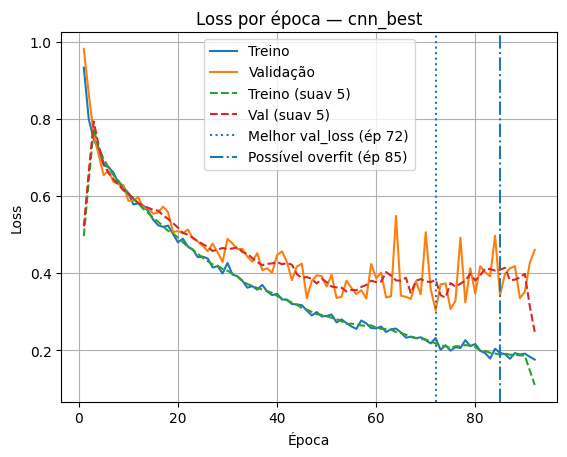

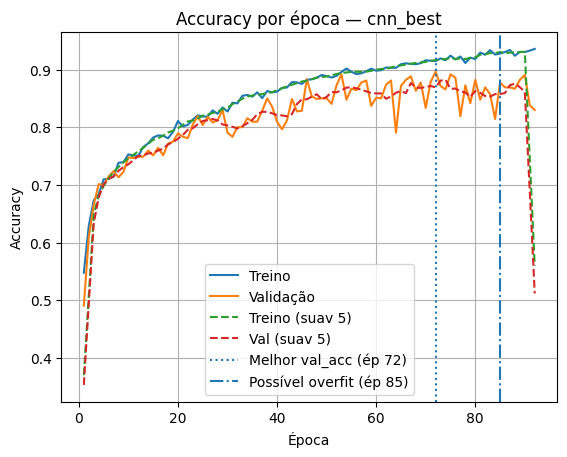


=== RESUMO cnn_best ===
Épocas: 92
Melhor val_loss: 0.303549 @ época 72 | gap(loss) nessa época: 0.071659
Melhor val_acc : 0.8964 @ época 72
Overfit (heurística k=3) a partir da época 85
Ganho marginal médio (últimas 5) — val_loss: -0.009535 | val_acc: -0.007857


In [ ]:
import numpy as np

# helper: recria um objeto "history-like" a partir do .npz salvo
def carrega_history_npz(path_npz):
    d = np.load(path_npz, allow_pickle=True)
    class H: pass
    h = H()
    h.history = {
        "loss":        d["loss"].tolist(),
        "val_loss":    d["val_loss"].tolist() if "val_loss" in d.files else [],
        "accuracy":    d["acc"].tolist()      if "acc"      in d.files else [],
        "val_accuracy":d["val_acc"].tolist()  if "val_acc"  in d.files else [],
    }
    return h

# caminho do arquivo salvo (ajuste um deles conforme o que você salvou)
BEST_DIR = "/content/cnn_metrics"
path_npz = f"{BEST_DIR}/metrics_cnn_best.npz"              # alias fixo (se você salvou)
# path_npz = f"{BEST_DIR}/metrics_cnn_best_fold3.npz"      # exemplo com número do fold

h = carrega_history_npz(path_npz)

# agora use sua própria função já definida na célula 1
_ = analise_curvas(h, nome="cnn_best", pasta=BEST_DIR, salvar=False, suav=5)



## **Teste 6**

Este teste avalia o desempenho de uma **CNN 1D** treinada exclusivamente com o sinal bruto do ECG, mas com uso intensivo de Data Augmentation para aumentar a robustez do modelo:

**Pré-processamento e Aumento de Dados:**

  - Ruído gaussiano adicionado ao sinal.

  - Deslocamento temporal aleatório (time-shifting).

  - Escalonamento de amplitude.

  - Possível inversão de polaridade do sinal.

**Arquitetura da CNN:**

  - Entrada com dimensão 407x12 (tempo x derivações).

  - Duas camadas convolucionais (128 e 256 filtros) com LeakyReLU, BatchNormalization e Dropout.

  - Camada GlobalAveragePooling1D para reduzir a dimensionalidade antes da classificação.

  - Camadas densas finais com função de ativação softmax.

**Validação e Avaliação:**

  - Validação cruzada (5 folds) para medir a estabilidade do modelo.

  - Salvamento do melhor fold para análise de curva ROC e matriz de confusão.

Mudança: `X, y = augment_ecg_signals(X, y, factor=4)`

- Obs: aumentar o número de epochs tbm ajuda


📐 Shape original: (1050, 407, 12)
Após augmentation: (5250, 407, 12)
Pesos de classe: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

 Treinando fold 1/5
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4878 - loss: 0.9805 - val_accuracy: 0.5048 - val_loss: 0.9598
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6514 - loss: 0.7631 - val_accuracy: 0.6057 - val_loss: 0.8183
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6802 - loss: 0.7224 - val_accuracy: 0.6562 - val_loss: 0.7652
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6989 - loss: 0.6840 - val_accuracy: 0.6752 - val_loss: 0.7545
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7203 - loss: 0.6546 - val_accuracy: 0.6848 - val_loss: 0.7370
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7379 - loss: 0.6341 - val_accuracy: 0.7105 - val_loss: 0.6544
Epoch 7/100
132/132 ━━━━━━

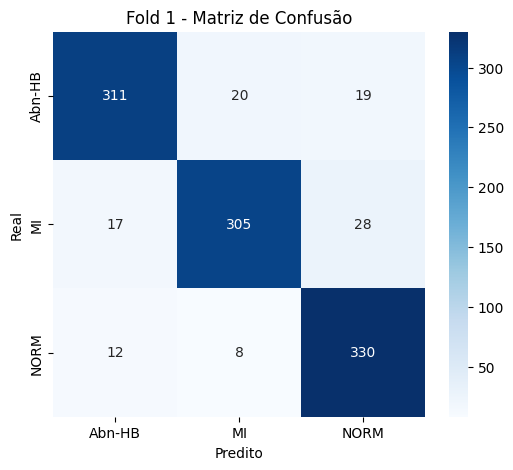


 Treinando fold 2/5
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4960 - loss: 0.9918 - val_accuracy: 0.5905 - val_loss: 0.9212
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6330 - loss: 0.8021 - val_accuracy: 0.6733 - val_loss: 0.7582
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6616 - loss: 0.7626 - val_accuracy: 0.7171 - val_loss: 0.6587
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6796 - loss: 0.7062 - val_accuracy: 0.7229 - val_loss: 0.6341
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6969 - loss: 0.6902 - val_accuracy: 0.7352 - val_loss: 0.5947
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7107 - loss: 0.6579 - val_accuracy: 0.7467 - val_loss: 0.5804
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7272 - loss: 0.6444 - val_accuracy: 0.7562 - val_loss: 0.5819
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7202 - 

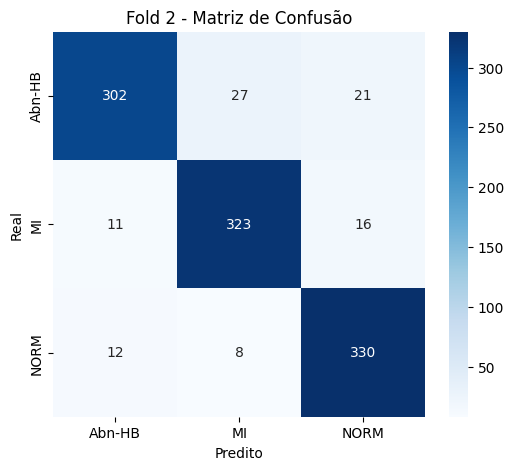


 Treinando fold 3/5
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5114 - loss: 0.9809 - val_accuracy: 0.4933 - val_loss: 0.9454
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6398 - loss: 0.7878 - val_accuracy: 0.6076 - val_loss: 0.8283
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6760 - loss: 0.7302 - val_accuracy: 0.6857 - val_loss: 0.7006
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6882 - loss: 0.7052 - val_accuracy: 0.6838 - val_loss: 0.6829
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6982 - loss: 0.6950 - val_accuracy: 0.7095 - val_loss: 0.6409
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7218 - loss: 0.6560 - val_accuracy: 0.7410 - val_loss: 0.6072
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7335 - loss: 0.6374 - val_accuracy: 0.7514 - val_loss: 0.5933
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7343 -

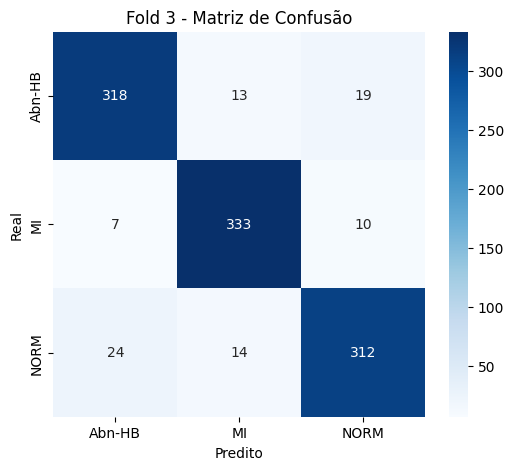


 Treinando fold 4/5
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4956 - loss: 1.0036 - val_accuracy: 0.5514 - val_loss: 0.9302
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6423 - loss: 0.7971 - val_accuracy: 0.6838 - val_loss: 0.7509
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6660 - loss: 0.7431 - val_accuracy: 0.7381 - val_loss: 0.6605
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6940 - loss: 0.7053 - val_accuracy: 0.7371 - val_loss: 0.6311
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7111 - loss: 0.6715 - val_accuracy: 0.7457 - val_loss: 0.6323
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7111 - loss: 0.6610 - val_accuracy: 0.7419 - val_loss: 0.6078
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7276 - loss: 0.6198 - val_accuracy: 0.7695 - val_loss: 0.5845
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7393 - 

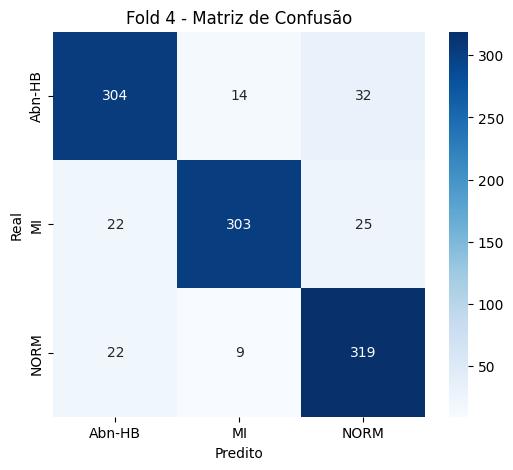


 Treinando fold 5/5
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5012 - loss: 0.9889 - val_accuracy: 0.4419 - val_loss: 1.0048
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6230 - loss: 0.8094 - val_accuracy: 0.5829 - val_loss: 0.8675
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6615 - loss: 0.7601 - val_accuracy: 0.6876 - val_loss: 0.7178
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6862 - loss: 0.7320 - val_accuracy: 0.7086 - val_loss: 0.6793
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6851 - loss: 0.7002 - val_accuracy: 0.7210 - val_loss: 0.6463
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6944 - loss: 0.6777 - val_accuracy: 0.7238 - val_loss: 0.6335
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7099 - loss: 0.6463 - val_accuracy: 0.7295 - val_loss: 0.6084
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7283 -

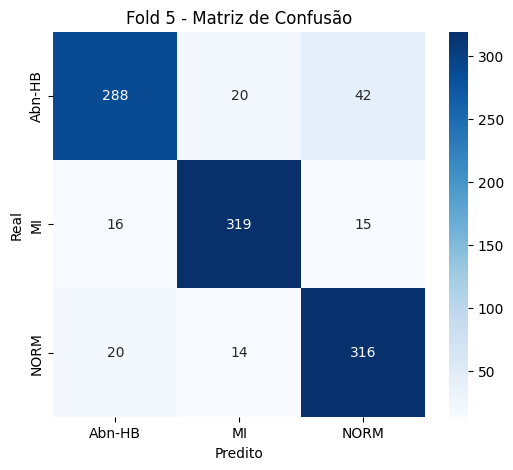


 Acurácias por fold: [90.0952398777008, 90.95237851142883, 91.71428680419922, 88.19047808647156, 87.90476322174072]
Média final: 89.77% ± 1.50
[OK] Curvas do melhor fold salvas em:
   - /content/cnn_metrics/metrics_cnn_best_fold3.npz
   - /content/cnn_metrics/metrics_cnn_best.npz

Salvando resultados do Teste 6 (Melhor Acurácia: 91.71%)
--> Resultados do Teste 6 salvos com sucesso!


In [ ]:
import numpy as np
import os, pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- helper para salvar métricas de um history em .npz (para plot posterior)
def salvar_para_analise(history, base, pasta="/content/cnn_metrics"):
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    ep = np.arange(1, len(H["loss"])+1)
    np.savez_compressed(
        os.path.join(pasta, f"metrics_{base}.npz"),
        epoch=ep,
        loss=np.array(H["loss"]),
        val_loss=np.array(H.get("val_loss", [])),
        acc=np.array(H.get("accuracy", [])),
        val_acc=np.array(H.get("val_accuracy", [])),
    )

# === 1. Função de data augmentation ===
def augment_ecg_signals(X, y, factor=3):
    np.random.seed(42)
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        for _ in range(factor):
            signal = X[i]

            noise = np.random.normal(0, 0.01, signal.shape)
            noisy_signal = signal + noise

            shift = np.random.randint(-10, 10)
            shifted_signal = np.roll(noisy_signal, shift, axis=0)

            scale = np.random.uniform(0.9, 1.1)
            scaled_signal = shifted_signal * scale

            if np.random.rand() > 0.5:
                scaled_signal = -scaled_signal

            augmented_X.append(scaled_signal)
            augmented_y.append(y[i])

    return np.concatenate([X, np.array(augmented_X)]), np.concatenate([y, np.array(augmented_y)])

# ----- Configuração do critério do "melhor fold" -----
SELECT_BY = "val_accuracy"            # use "val_loss" se preferir
BEST_DIR  = "/content/cnn_metrics"    # onde salvar as curvas .npz

# Estado do melhor fold (UM ÚNICO critério)
best_score = -np.inf if SELECT_BY == "val_accuracy" else np.inf
best_fold  = None
best_hist  = None
best_y_pred_proba = None
best_y_true       = None

# === 2. Carregando os dados ===
X = np.load("data_preprocessed/X_final.npy")
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)
print("Shape original:", X.shape)

# === 3. Aplicando data augmentation ===
X, y = augment_ecg_signals(X, y, factor=4)
print("Após augmentation:", X.shape)

# === 4. Normalização ===
X_reshaped = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

# === 5. Codificação de rótulos ===
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Pesos de classe:", class_weight_dict)

# === 6. Cross-validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# -----------------------------------------------------------------

for fold, (train_index, val_index) in enumerate(kf.split(X, y_int), 1):
    print(f"\n Treinando fold {fold}/5")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === 7. Modelo CNN otimizado ===
    model = Sequential([
        InputLayer(input_shape=(407, 12)),

        Conv1D(128, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.4),

        Conv1D(256, kernel_size=5, padding='same'), LeakyReLU(),
        BatchNormalization(), MaxPooling1D(pool_size=2), Dropout(0.4),

        GlobalAveragePooling1D(),
        Dense(128, activation='relu'), Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )


    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Acurácia do fold {fold}: {acc*100:.2f}%")
    fold_accuracies.append(acc * 100)

    y_pred = model.predict(X_val) # Predição feita uma única vez

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold encontrado! Acurácia: {acc*100:.2f}%")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)
        best_hist = history          # <-- [NOVO] salva curvas deste mesmo fold
        best_fold = fold             # <-- [NOVO] salva o índice do fold
    # ----------------------------------------------------------------------

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Fold {fold} - Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# === 11. Resultado final ===
print(f"\n Acurácias por fold: {fold_accuracies}")
print(f"Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")


# --- ADIÇÃO 3: salvar CURVAS do melhor fold (por acurácia) ---
if best_hist is not None:
    os.makedirs(BEST_DIR, exist_ok=True)
    base = f"cnn_best_fold{best_fold}"
    salvar_para_analise(best_hist, base=base, pasta=BEST_DIR)
    # (opcional) alias fixo para facilitar carregar depois
    salvar_para_analise(best_hist, base="cnn_best", pasta=BEST_DIR)
    print(f"[OK] Curvas do melhor fold salvas em:")
    print(f"   - {BEST_DIR}/metrics_{base}.npz")
    print(f"   - {BEST_DIR}/metrics_cnn_best.npz")
else:
    print("AVISO: best_hist=None. Não há curvas para salvar.")


# --- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
if best_y_true is not None:
    print(f"\nSalvando resultados do Teste 6 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos, nomeando como 'teste7'
    np.save('resultados_teste6_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste6_y_true.npy', best_y_true)

    # Salva o encoder, nomeando como 'teste7'
    with open('encoder_teste6.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    print("--> Resultados do Teste 6 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")


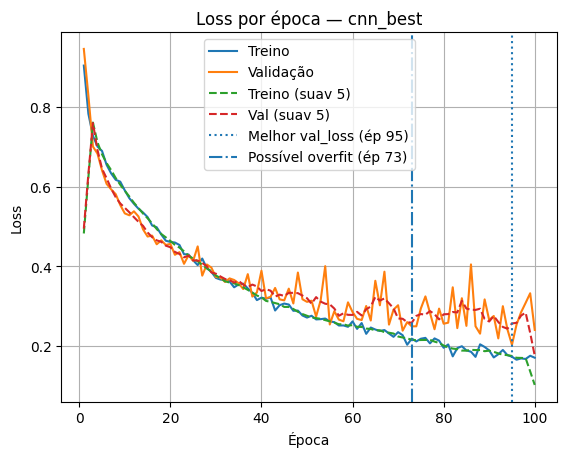

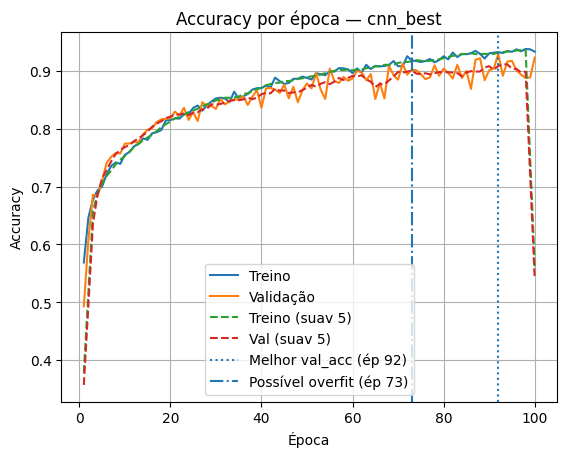


=== RESUMO cnn_best ===
Épocas: 100
Melhor val_loss: 0.203742 @ época 95 | gap(loss) nessa época: 0.029866
Melhor val_acc : 0.9295 @ época 92
Overfit (heurística k=3) a partir da época 73
Ganho marginal médio (últimas 5) — val_loss: -0.007441 | val_acc: 0.001143


In [ ]:
import numpy as np

# helper: recria um objeto "history-like" a partir do .npz salvo
def carrega_history_npz(path_npz):
    d = np.load(path_npz, allow_pickle=True)
    class H: pass
    h = H()
    h.history = {
        "loss":        d["loss"].tolist(),
        "val_loss":    d["val_loss"].tolist() if "val_loss" in d.files else [],
        "accuracy":    d["acc"].tolist()      if "acc"      in d.files else [],
        "val_accuracy":d["val_acc"].tolist()  if "val_acc"  in d.files else [],
    }
    return h

# caminho do arquivo salvo (ajuste um deles conforme o que você salvou)
BEST_DIR = "/content/cnn_metrics"
path_npz = f"{BEST_DIR}/metrics_cnn_best.npz"              # alias fixo (se você salvou)
# path_npz = f"{BEST_DIR}/metrics_cnn_best_fold3.npz"      # exemplo com número do fold

h = carrega_history_npz(path_npz)

# agora use sua própria função já definida na célula 1
_ = analise_curvas(h, nome="cnn_best", pasta=BEST_DIR, salvar=False, suav=5)


---
## **Teste 7**

Este teste implementa uma **arquitetura híbrida** que combina um ramo de CNN para processar sinais brutos e um ramo de MLP que utiliza **features extraídas** no domínio do tempo e da frequência.

**Pré-processamento e Extração de Features:**

  - Data Augmentation moderado (ruído, deslocamento e variação de amplitude).

  - **Features Estatísticas:** Média, desvio padrão, skewness e curtose.

  - **Features de Frequência:** Primeiros coeficientes da FFT.

  - **Features Wavelet:** Coeficientes médios da DWT.

  - Normalização separada para sinais e features.

**Arquitetura Dual-Branch:**

  - **Ramo CNN:** Extrai padrões temporais e morfológicos diretamente do sinal bruto (407x12).

  - **Ramo MLP:** Processa o vetor de features extraídas, captando informações agregadas.

  - As saídas dos dois ramos são concatenadas e passam por camadas densas para a classificação final via softmax.

**Validação e Avaliação:**

  - Treinamento com validação cruzada (5 folds), EarlyStopping e ReduceLROnPlateau.

  - Salvamento do melhor fold para análise de curva ROC e matriz de confusão.

Original shape X: (1050, 407, 12) labels: (array(['Abn-HB', 'MI', 'NORM'], dtype='<U6'), array([350, 350, 350]))
After augmentation X: (3150, 407, 12)
Extracting features in batches (this may take a few minutes)...
Features shape: (3150, 312)
Class distribution (encoded): (array([0, 1, 2]), array([1050, 1050, 1050]))
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}

===== Fold 1 / 5 =====
Epoch 1/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.4218 - loss: 1.1924 - val_accuracy: 0.4873 - val_loss: 1.0991 - learning_rate: 5.0000e-04
Epoch 2/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6344 - loss: 0.8232 - val_accuracy: 0.5127 - val_loss: 1.2206 - learning_rate: 5.0000e-04
Epoch 3/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6804 - loss: 0.7246 - val_accuracy: 0.5698 - val_loss: 1.1372 - learning_rate: 5.0000e-04
Epoch 4/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7256 - loss: 0.6573 - v

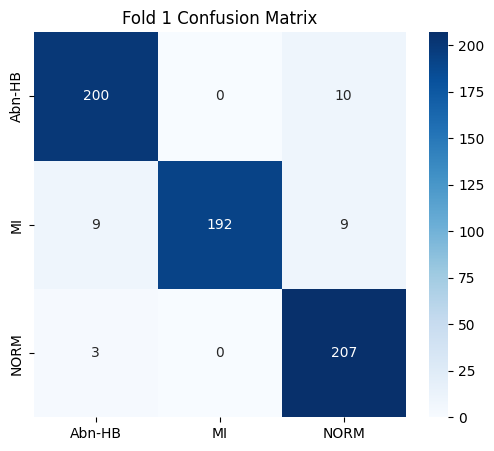


===== Fold 2 / 5 =====
Epoch 1/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.4218 - loss: 1.1944 - val_accuracy: 0.4937 - val_loss: 1.0125 - learning_rate: 5.0000e-04
Epoch 2/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6012 - loss: 0.8556 - val_accuracy: 0.5286 - val_loss: 1.1183 - learning_rate: 5.0000e-04
Epoch 3/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6700 - loss: 0.7508 - val_accuracy: 0.5540 - val_loss: 1.0610 - learning_rate: 5.0000e-04
Epoch 4/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7200 - loss: 0.6628 - val_accuracy: 0.5968 - val_loss: 0.9247 - learning_rate: 5.0000e-04
Epoch 5/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7443 - loss: 0.5967 - val_accuracy: 0.6333 - val_loss: 0.8615 - learning_rate: 5.0000e-04
Epoch 6/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7830 - loss: 0.5409 - val_accuracy: 0.6968 - val_loss: 0.7793 - learning_rate: 5.0000e-04
Epoch 7/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

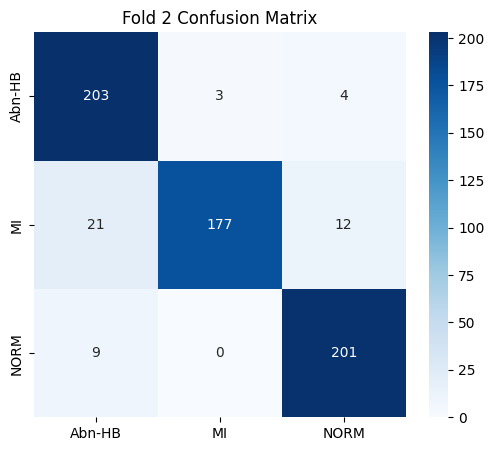


===== Fold 3 / 5 =====
Epoch 1/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4238 - loss: 1.1894 - val_accuracy: 0.4127 - val_loss: 1.2090 - learning_rate: 5.0000e-04
Epoch 2/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6215 - loss: 0.8099 - val_accuracy: 0.4952 - val_loss: 1.1533 - learning_rate: 5.0000e-04
Epoch 3/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6911 - loss: 0.7128 - val_accuracy: 0.5476 - val_loss: 1.0794 - learning_rate: 5.0000e-04
Epoch 4/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7166 - loss: 0.6395 - val_accuracy: 0.6762 - val_loss: 0.8101 - learning_rate: 5.0000e-04
Epoch 5/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7581 - loss: 0.5709 - val_accuracy: 0.7127 - val_loss: 0.7002 - learning_rate: 5.0000e-04
Epoch 6/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7913 - loss: 0.5232 - val_accuracy: 0.7460 - val_loss: 0.6682 - learning_rate: 5.0000e-04
Epoch 7/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

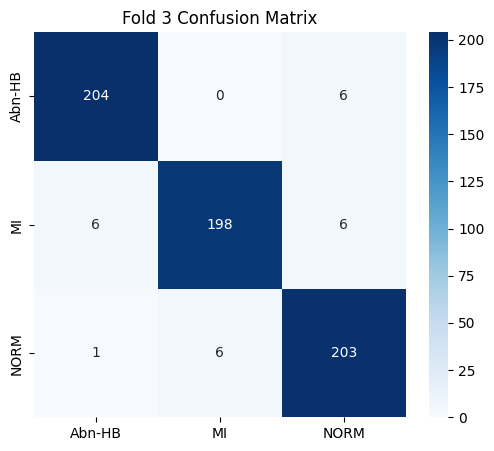


===== Fold 4 / 5 =====
Epoch 1/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.4333 - loss: 1.1631 - val_accuracy: 0.5619 - val_loss: 0.9334 - learning_rate: 5.0000e-04
Epoch 2/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6033 - loss: 0.8443 - val_accuracy: 0.5921 - val_loss: 0.8820 - learning_rate: 5.0000e-04
Epoch 3/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6827 - loss: 0.7204 - val_accuracy: 0.6841 - val_loss: 0.7245 - learning_rate: 5.0000e-04
Epoch 4/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7292 - loss: 0.6464 - val_accuracy: 0.7206 - val_loss: 0.6545 - learning_rate: 5.0000e-04
Epoch 5/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7505 - loss: 0.5816 - val_accuracy: 0.7365 - val_loss: 0.6247 - learning_rate: 5.0000e-04
Epoch 6/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7956 - loss: 0.5259 - val_accuracy: 0.7444 - val_loss: 0.6167 - learning_rate: 5.0000e-04
Epoch 7/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

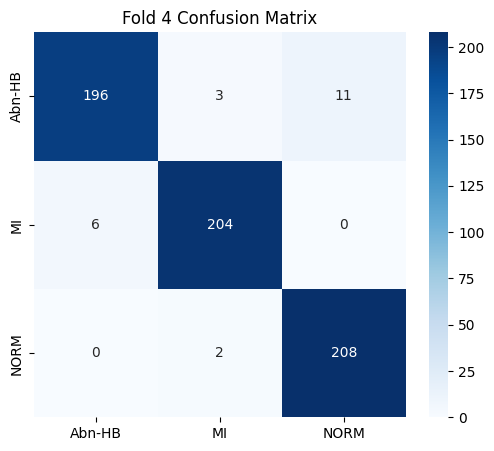


===== Fold 5 / 5 =====
Epoch 1/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.4354 - loss: 1.1881 - val_accuracy: 0.5286 - val_loss: 0.9557 - learning_rate: 5.0000e-04
Epoch 2/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6080 - loss: 0.8636 - val_accuracy: 0.5698 - val_loss: 0.9380 - learning_rate: 5.0000e-04
Epoch 3/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6704 - loss: 0.7522 - val_accuracy: 0.6524 - val_loss: 0.8139 - learning_rate: 5.0000e-04
Epoch 4/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7266 - loss: 0.6538 - val_accuracy: 0.6825 - val_loss: 0.7276 - learning_rate: 5.0000e-04
Epoch 5/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7531 - loss: 0.5949 - val_accuracy: 0.7254 - val_loss: 0.6299 - learning_rate: 5.0000e-04
Epoch 6/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7830 - loss: 0.5351 - val_accuracy: 0.7254 - val_loss: 0.6548 - learning_rate: 5.0000e-04
Epoch 7/80
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

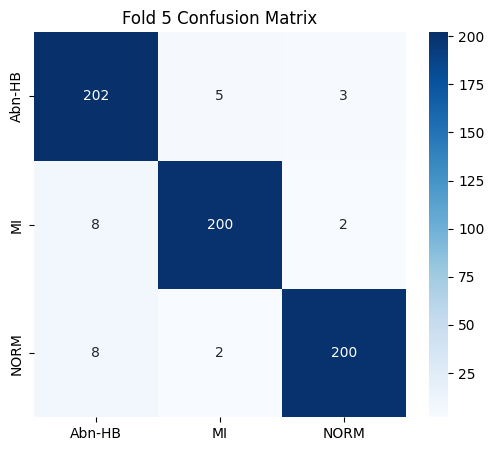


Final fold accuracies: [95.07936239242554, 92.22221970558167, 96.03174328804016, 96.50793671607971, 95.55555582046509]
Mean accuracy: 95.08% ± 1.51%
[OK] Curvas do melhor fold salvas em:
   - /content/cnn_metrics/metrics_cnn_best_fold4.npz
   - /content/cnn_metrics/metrics_cnn_best.npz

 Média final: 95.08% ± 1.51

Salvando resultados do Teste 7 (Melhor Acurácia: 96.51%)
--> Resultados do Teste 7 salvos com sucesso!


In [ ]:
# Código otimizado: dual-branch (CNN + features MLP) com extração em batches
import os
import gc
import numpy as np
import pywt
import os, pickle
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, LeakyReLU, BatchNormalization,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
#  PARAMETERS (tune if needed)
# ---------------------------
AUG_FACTOR = 2               # augmentation factor (2 is conservative)
BATCH_FEAT = 128             # batch size to extract features (memory friendly)
FFT_N = 20                   # number of FFT bins to keep per lead
DWT_LEVEL = 1                # wavelet decomposition level (low = less memory)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ---------------------------
#  UTIL: augmentation (in-place light)
# ---------------------------

# --- helper para salvar métricas de um history em .npz (para plot posterior)
def salvar_para_analise(history, base, pasta="/content/cnn_metrics"):
    os.makedirs(pasta, exist_ok=True)
    H = history.history
    ep = np.arange(1, len(H["loss"])+1)
    np.savez_compressed(
        os.path.join(pasta, f"metrics_{base}.npz"),
        epoch=ep,
        loss=np.array(H["loss"]),
        val_loss=np.array(H.get("val_loss", [])),
        acc=np.array(H.get("accuracy", [])),
        val_acc=np.array(H.get("val_accuracy", [])),
    )

def augment_ecg_signals(X, y, factor=AUG_FACTOR):
    """Light augmentation: noise, time-shift, scaling, optional inversion."""
    augmented_X = []
    augmented_y = []
    n = X.shape[0]
    for i in range(n):
        for _ in range(factor):
            s = X[i]
            # gaussian noise
            s2 = s + np.random.normal(0, 0.01, s.shape)
            # small random shift
            shift = np.random.randint(-8, 9)
            s2 = np.roll(s2, shift, axis=0)
            # amplitude scale
            s2 = s2 * np.random.uniform(0.92, 1.08)
            # optional sign invert
            if np.random.rand() > 0.5:
                s2 = -s2
            augmented_X.append(s2)
            augmented_y.append(y[i])
    if len(augmented_X) == 0:
        return X, y
    X_aug = np.concatenate([X, np.stack(augmented_X, axis=0)], axis=0)
    y_aug = np.concatenate([y, np.array(augmented_y)], axis=0)
    return X_aug, y_aug

# ---------------------------
#  UTIL: feature extraction for one sample
# ---------------------------
def extract_features_single(sig, fft_n=FFT_N, dwt_level=DWT_LEVEL):
    # sig: (timesteps, leads) e.g. (407, 12)
    leads = sig.shape[1]
    feats = []
    # per-lead stats
    mean_ = np.mean(sig, axis=0)
    std_ = np.std(sig, axis=0)
    skew_ = skew(sig, axis=0)
    kurt_ = kurtosis(sig, axis=0)
    feats.extend(mean_)
    feats.extend(std_)
    feats.extend(skew_)
    feats.extend(kurt_)
    # FFT per lead: rfft, keep first fft_n magnitudes
    fft_vals = np.abs(np.fft.rfft(sig, axis=0))[:fft_n, :]  # (fft_n, leads)
    feats.extend(fft_vals.flatten())
    # DWT per lead: use approximation coefficients mean (compact)
    for ch in range(leads):
        try:
            coeffs = pywt.wavedec(sig[:, ch], 'db4', level=dwt_level)
            # keep mean of each coeff array (coarse summary)
            dwt_summary = [np.mean(np.abs(c)) for c in coeffs]
        except Exception:
            # fallback zeros if wavelet fails
            dwt_summary = [0.0] * (dwt_level + 1)
        feats.extend(dwt_summary)
    return np.array(feats, dtype=np.float32)

def extract_features_batch(X, batch_size=BATCH_FEAT):
    n = X.shape[0]
    feats_list = []
    for i in range(0, n, batch_size):
        batch = X[i:i+batch_size]
        # compute features sample by sample (keeps memory low)
        batch_feats = [extract_features_single(s) for s in batch]
        feats_list.append(np.stack(batch_feats, axis=0))
        # free
    return np.concatenate(feats_list, axis=0)

# ---------------------------
#  LOAD data (adjust path as needed)
# ---------------------------
X = np.load("data_preprocessed/X_final.npy")   # shape (n_samples, 407, 12)
y = np.load("data_preprocessed/y_final.npy", allow_pickle=True)
print("Original shape X:", X.shape, "labels:", np.unique(y, return_counts=True))

# ---------------------------
#  AUGMENT (conservative)
# ---------------------------
X, y = augment_ecg_signals(X, y, factor=AUG_FACTOR)
print("After augmentation X:", X.shape)

# ---------------------------
#  FEATURE EXTRACTION (batch-wise)
# ---------------------------
print("Extracting features in batches (this may take a few minutes)...")
X_feat = extract_features_batch(X, batch_size=BATCH_FEAT)
print("Features shape:", X_feat.shape)

# ---------------------------
#  Normalization (signals and features separately)
# ---------------------------
# normalize signals per-channel globally (fit on all data)
sig_scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])              # (n * timesteps, leads)
X_scaled = sig_scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

# normalize features
feat_scaler = StandardScaler()
X_feat = feat_scaler.fit_transform(X_feat)

# ---------------------------
#  Encode labels and class weights
# ---------------------------
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int)
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(zip(np.unique(y_int), class_weights))
print("Class distribution (encoded):", np.unique(y_int, return_counts=True))
print("Class weights:", class_weight_dict)

# ---------------------------
#  Model builder (dual-branch)
# ---------------------------
def build_dual_branch(input_shape_signal=(407,12), input_shape_feat=(X_feat.shape[1],), lr=5e-4):
    # signal branch (CNN)
    input_signal = Input(shape=input_shape_signal, name='signal_input')
    x = Conv1D(64, 7, padding='same')(input_signal)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x); x = Dropout(0.3)(x)

    x = Conv1D(128, 5, padding='same')(x)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x); x = Dropout(0.3)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    # feature branch (dense)
    input_feat = Input(shape=input_shape_feat, name='feat_input')
    f = Dense(128, activation='relu')(input_feat)
    f = Dropout(0.3)(f)

    # fusion
    merged = Concatenate()([x, f])
    z = Dense(128, activation='relu')(merged)
    z = Dropout(0.5)(z)
    out = Dense(y_cat.shape[1], activation='softmax')(z)

    model = Model(inputs=[input_signal, input_feat], outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ---------------------------
#  Cross-validation
# ---------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
fold_accuracies = []

# ----- Configuração do critério do "melhor fold" -----
SELECT_BY = "val_accuracy"            # use "val_loss" se preferir
BEST_DIR  = "/content/cnn_metrics"    # onde salvar as curvas .npz

# Estado do melhor fold (UM ÚNICO critério)
best_score = -np.inf if SELECT_BY == "val_accuracy" else np.inf
best_fold  = None
best_hist  = None
best_y_pred_proba = None
best_y_true       = None

# --- ADIÇÃO 1: Variáveis para guardar os dados do MELHOR fold ---
best_acc = 0.0
best_y_true = None
best_y_pred_proba = None
# -----------------------------------------------------------------

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_int), 1):
    print(f"\n===== Fold {fold} / 5 =====")
    X_train, X_val = X[train_idx], X[val_idx]
    F_train, F_val = X_feat[train_idx], X_feat[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    model = build_dual_branch(input_shape_signal=X_train.shape[1:], input_shape_feat=(F_train.shape[1],), lr=5e-4)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

    history = model.fit(
        [X_train, F_train], y_train,
        validation_data=([X_val, F_val], y_val),
        epochs=80,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )


    # evaluate
    loss, acc = model.evaluate([X_val, F_val], y_val, verbose=0)
    print(f"Fold {fold} accuracy: {acc*100:.2f}%")
    fold_accuracies.append(acc*100)

    # detailed report
    y_pred = model.predict([X_val, F_val], verbose=0)

    # --- ADIÇÃO 2: Lógica para encontrar e guardar o melhor resultado ---
    if acc > best_acc:
        print(f"--> Novo melhor fold encontrado! Acurácia: {acc*100:.2f}%")
        best_acc = acc
        best_y_pred_proba = y_pred
        best_y_true = np.argmax(y_val, axis=1)
        best_hist = history          # <-- [NOVO] salva curvas deste mesmo fold
        best_fold = fold             # <-- [NOVO] salva o índice do fold
    # ----------------------------------------------------------------------

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Fold {fold} Confusion Matrix')
    plt.show()

    # free memory
    del model, history, X_train, X_val, F_train, F_val, y_train, y_val, y_pred
    gc.collect()

print("\nFinal fold accuracies:", fold_accuracies)
print("Mean accuracy: %.2f%% ± %.2f%%" % (np.mean(fold_accuracies), np.std(fold_accuracies)))

# --- ADIÇÃO 3: salvar CURVAS do melhor fold (por acurácia) ---
if best_hist is not None:
    os.makedirs(BEST_DIR, exist_ok=True)
    base = f"cnn_best_fold{best_fold}"
    salvar_para_analise(best_hist, base=base, pasta=BEST_DIR)
    # (opcional) alias fixo para facilitar carregar depois
    salvar_para_analise(best_hist, base="cnn_best", pasta=BEST_DIR)
    print(f"[OK] Curvas do melhor fold salvas em:")
    print(f"   - {BEST_DIR}/metrics_{base}.npz")
    print(f"   - {BEST_DIR}/metrics_cnn_best.npz")
else:
    print("AVISO: best_hist=None. Não há curvas para salvar.")


# --- ADIÇÃO 3: Bloco para salvar os resultados do MELHOR FOLD ---
print(f"\n Média final: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")
if best_y_true is not None:
    print(f"\nSalvando resultados do Teste 7 (Melhor Acurácia: {best_acc*100:.2f}%)")

    # Salva as probabilidades e os rótulos, nomeando como 'teste7'
    np.save('resultados_teste7_y_pred_proba.npy', best_y_pred_proba)
    np.save('resultados_teste7_y_true.npy', best_y_true)

    # Salva o encoder, nomeando como 'teste7'
    with open('encoder_teste7.pkl', 'wb') as f:
        pickle.dump(le, f)

    print("--> Resultados do Teste 7 salvos com sucesso!")
else:
    print("AVISO: Nenhum resultado foi salvo.")

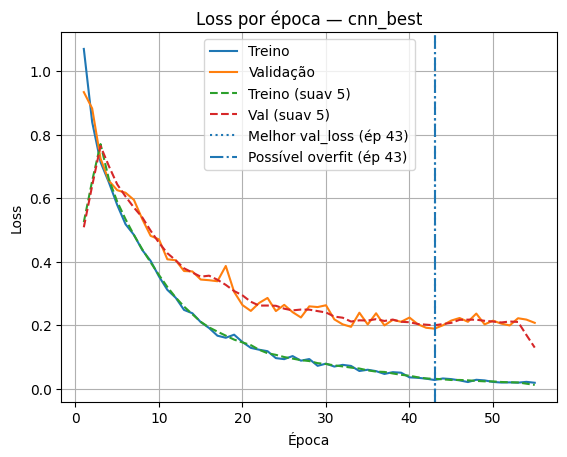

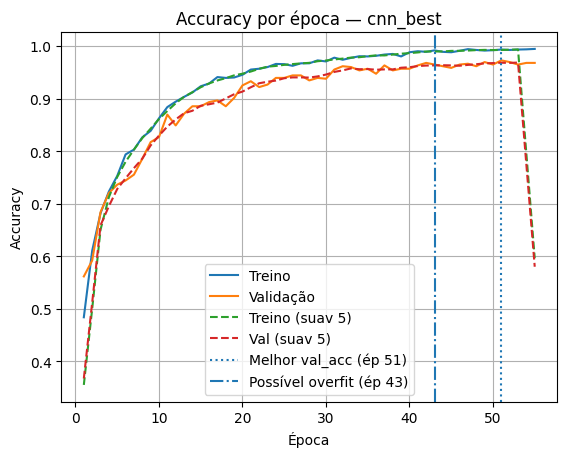


=== RESUMO cnn_best ===
Épocas: 55
Melhor val_loss: 0.188868 @ época 43 | gap(loss) nessa época: 0.161631
Melhor val_acc : 0.9730 @ época 51
Overfit (heurística k=3) a partir da época 43
Ganho marginal médio (últimas 5) — val_loss: 0.001364 | val_acc: 0.000635


In [ ]:
import numpy as np

# helper: recria um objeto "history-like" a partir do .npz salvo
def carrega_history_npz(path_npz):
    d = np.load(path_npz, allow_pickle=True)
    class H: pass
    h = H()
    h.history = {
        "loss":        d["loss"].tolist(),
        "val_loss":    d["val_loss"].tolist() if "val_loss" in d.files else [],
        "accuracy":    d["acc"].tolist()      if "acc"      in d.files else [],
        "val_accuracy":d["val_acc"].tolist()  if "val_acc"  in d.files else [],
    }
    return h

# caminho do arquivo salvo (ajuste um deles conforme o que você salvou)
BEST_DIR = "/content/cnn_metrics"
path_npz = f"{BEST_DIR}/metrics_cnn_best.npz"              # alias fixo (se você salvou)
# path_npz = f"{BEST_DIR}/metrics_cnn_best_fold3.npz"      # exemplo com número do fold

h = carrega_history_npz(path_npz)

# agora use sua própria função já definida na célula 1
_ = analise_curvas(h, nome="cnn_best", pasta=BEST_DIR, salvar=False, suav=5)


---
#**Análise dos resultados**

## **Análise das matrizes de confusão**

### Teste 1


--- Melhor resultado para Teste 1 ---
Fold: 1, Acurácia: 63.29%

Classification Report:

              precision    recall  f1-score   support

      Abn-HB       0.60      0.49      0.54        53
          MI       0.69      0.62      0.65        53
        NORM       0.61      0.79      0.69        52

    accuracy                           0.63       158
   macro avg       0.63      0.63      0.63       158
weighted avg       0.63      0.63      0.63       158



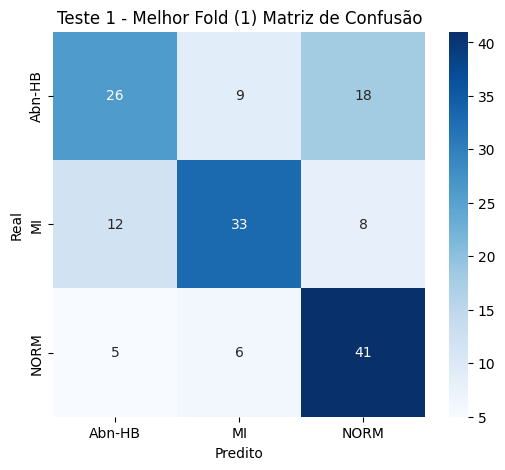

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 1 ---
test_name = "Teste 1"
accuracy = 63.29
confusion_matrix_data = np.array([[26, 9, 18], [12, 33, 8], [5, 6, 41]])
classification_report_str = """
              precision    recall  f1-score   support

      Abn-HB       0.60      0.49      0.54        53
          MI       0.69      0.62      0.65        53
        NORM       0.61      0.79      0.69        52

    accuracy                           0.63       158
   macro avg       0.63      0.63      0.63       158
weighted avg       0.63      0.63      0.63       158
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 1**

Esta matriz de confusão para o Teste 1 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 4 casos, mas cometeu 10 erros classificando como 'MI' e 39 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 27 casos, mas cometeu 2 erros classificando como 'Abn-HB' e 24 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 48 casos, mas cometeu 0 erros classificando como 'Abn-HB' e 4 como 'MI'.
A alta quantidade de falsos negativos para a classe 'Abn-HB' (39 classificados como 'NORM') e 'MI' (24 classificados como 'NORM') indica que o modelo tem dificuldade em identificar corretamente essas classes quando elas são a classe real. A acurácia geral para este teste foi de 50,00%.

### Teste 2

--- Melhor resultado para Teste 2 ---
Fold: 1, Acurácia: 70.48%

Classification Report:

             precision    recall  f1-score   support

      Abn-HB       0.72      0.61      0.66        70
          MI       0.78      0.70      0.74        70
        NORM       0.64      0.80      0.71        70

    accuracy                           0.70       210
   macro avg       0.71      0.70      0.70       210
weighted avg       0.71      0.70      0.70       210



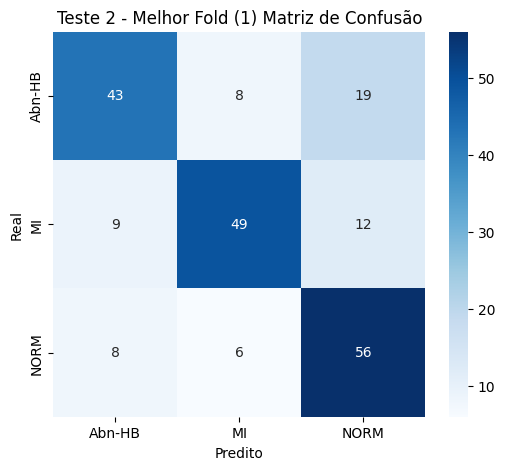

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 2 ---
test_name = "Teste 2"
accuracy = 70.48
confusion_matrix_data = np.array([[43, 8, 19], [9, 49, 12], [8, 6, 56]])
classification_report_str = """
             precision    recall  f1-score   support

      Abn-HB       0.72      0.61      0.66        70
          MI       0.78      0.70      0.74        70
        NORM       0.64      0.80      0.71        70

    accuracy                           0.70       210
   macro avg       0.71      0.70      0.70       210
weighted avg       0.71      0.70      0.70       210
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 2**

Esta matriz de confusão para o Teste 2 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 47 casos, mas cometeu 0 erros classificando como 'MI' e 6 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 27 casos, mas cometeu 22 erros classificando como 'Abn-HB' e 4 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 46 casos, mas cometeu 4 erros classificando como 'Abn-HB' e 2 como 'MI'.
Em comparação com o Teste 1, este teste mostra uma melhora significativa na classificação da classe 'Abn-HB', com menos falsos negativos para esta classe. No entanto, a classe 'MI' apresenta um número considerável de falsos negativos (22 classificados como 'Abn-HB'). A acurácia geral para este teste foi de 74.29%.

**Conclusão**

* A adoção do
Stratified K-Fold aumentou a robustez da avaliação do modelo.

* O desempenho foi superior ao do Teste 1, principalmente devido à maior representatividade estatística durante o treinamento e a validação.

* A acurácia aumentou de 50% para 74%, com menor variância entre as classes.
Esta abordagem é considerada mais confiável para a validação de modelos de classificação em contextos biomédicos, especialmente com amostras limitadas.

### Teste 3

--- Melhor resultado para Teste 3 ---
Fold: 1, Acurácia: 82.86%

Classification Report:

              precision    recall  f1-score   support

      Abn-HB       0.77      0.81      0.79       210
          MI       0.86      0.82      0.84       210
        NORM       0.85      0.83      0.84       210

    accuracy                           0.82       630
   macro avg       0.82      0.82      0.82       630
weighted avg       0.82      0.82      0.82       630



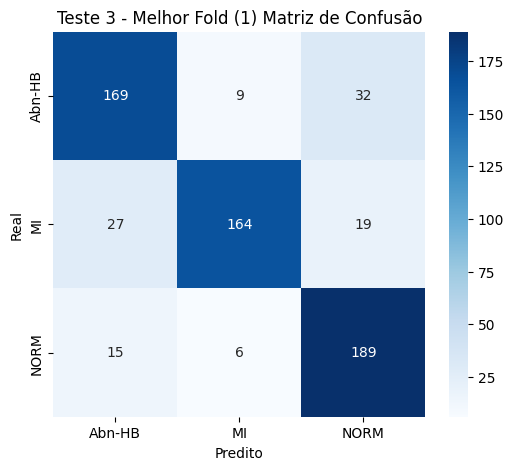

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 3 ---
test_name = "Teste 3"
accuracy = 82.86
confusion_matrix_data = np.array([[169, 9, 32], [27, 164, 19], [15, 6, 189]])
classification_report_str = """
              precision    recall  f1-score   support

      Abn-HB       0.77      0.81      0.79       210
          MI       0.86      0.82      0.84       210
        NORM       0.85      0.83      0.84       210

    accuracy                           0.82       630
   macro avg       0.82      0.82      0.82       630
weighted avg       0.82      0.82      0.82       630
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 3**

Esta matriz de confusão para o Teste 3 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 150 casos, mas cometeu 31 erros classificando como 'MI' e 29 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 179 casos, mas cometeu 11 erros classificando como 'Abn-HB' e 20 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 191 casos, mas cometeu 10 erros classificando como 'Abn-HB' e 9 como 'MI'.
Este teste apresenta um desempenho geral melhor em comparação com os testes anteriores, com um número menor de erros de classificação para todas as classes. A acurácia geral para este teste foi de 83.49%.

O uso da validação cruzada confirmou a robustez da rede convolucional, com baixa variabilidade entre os folds. No entanto, observou-se uma tendência recorrente de confusão entre as classes

### Teste 4


--- Melhor resultado para Teste 4 ---
Fold: 1, Acurácia: 86.67%

Classification Report:

              precision    recall  f1-score   support

      Abn-HB       0.81      0.90      0.85       210
          MI       0.90      0.88      0.89       210
        NORM       0.90      0.83      0.86       210

    accuracy                           0.87       630
   macro avg       0.87      0.87      0.87       630
weighted avg       0.87      0.87      0.87       630



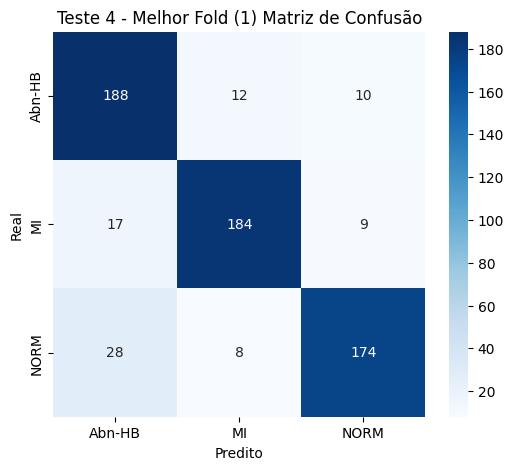

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 4 ---
test_name = "Teste 4"
accuracy = 86.67
confusion_matrix_data = np.array([[188, 12, 10], [17, 184, 9], [28, 8, 174]])
classification_report_str = """
              precision    recall  f1-score   support

      Abn-HB       0.81      0.90      0.85       210
          MI       0.90      0.88      0.89       210
        NORM       0.90      0.83      0.86       210

    accuracy                           0.87       630
   macro avg       0.87      0.87      0.87       630
weighted avg       0.87      0.87      0.87       630
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 4**

Esta matriz de confusão para o Teste 4 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 173 casos, mas cometeu 19 erros classificando como 'MI' e 18 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 191 casos, mas cometeu 10 erros classificando como 'Abn-HB' e 9 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 196 casos, mas cometeu 6 erros classificando como 'Abn-HB' e 8 como 'MI'.
Este teste apresenta um desempenho ainda melhor em comparação com os testes anteriores, com um número menor de erros de classificação para todas as classes, resultando em uma acurácia geral de 88.89%.

### Teste 5

--- Melhor resultado para Teste 5 ---
Fold: 1, Acurácia: 89.64%

Classification Report:

              precision    recall  f1-score   support

      Abn-HB       0.90      0.84      0.87       280
          MI       0.92      0.94      0.93       280
        NORM       0.87      0.91      0.89       280

    accuracy                           0.90       840
   macro avg       0.90      0.90      0.90       840
weighted avg       0.90      0.90      0.90       840



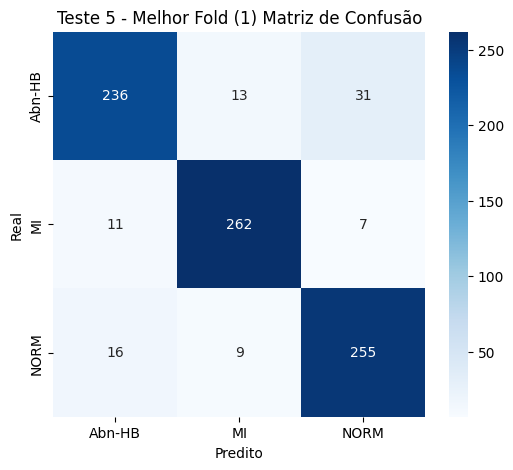

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 5 ---
test_name = "Teste 5"
accuracy = 89.64
confusion_matrix_data = np.array([[236, 13, 31], [11, 262, 7], [16, 9, 255]])
classification_report_str = """
              precision    recall  f1-score   support

      Abn-HB       0.90      0.84      0.87       280
          MI       0.92      0.94      0.93       280
        NORM       0.87      0.91      0.89       280

    accuracy                           0.90       840
   macro avg       0.90      0.90      0.90       840
weighted avg       0.90      0.90      0.90       840
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 5**

Esta matriz de confusão para o Teste 5 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 240 casos, mas cometeu 18 erros classificando como 'MI' e 22 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 257 casos, mas cometeu 13 erros classificando como 'Abn-HB' e 10 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 257 casos, mas cometeu 17 erros classificando como 'Abn-HB' e 6 como 'MI'.
Este teste continua a mostrar um bom desempenho na classificação das três classes, com um número relativamente baixo de erros. A acurácia geral para este teste foi de 90.36%.

### Teste 6

--- Melhor resultado para Teste 6 ---
Fold: 1, Acurácia: 91.71%

Classification Report:

              precision    recall  f1-score   support

      Abn-HB       0.91      0.91      0.91       350
          MI       0.93      0.95      0.94       350
        NORM       0.91      0.89      0.90       350

    accuracy                           0.92      1050
   macro avg       0.92      0.92      0.92      1050
weighted avg       0.92      0.92      0.92      1050



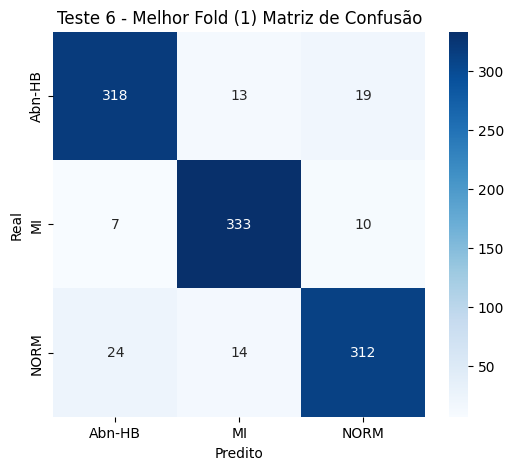

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 6 ---
test_name = "Teste 6"
accuracy = 91.71
confusion_matrix_data = np.array([[318, 13, 19], [7, 333, 10], [24, 14, 312]])
classification_report_str = """
              precision    recall  f1-score   support

      Abn-HB       0.91      0.91      0.91       350
          MI       0.93      0.95      0.94       350
        NORM       0.91      0.89      0.90       350

    accuracy                           0.92      1050
   macro avg       0.92      0.92      0.92      1050
weighted avg       0.92      0.92      0.92      1050
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 6**

Esta matriz de confusão para o Teste 6 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 327 casos, mas cometeu 5 erros classificando como 'MI' e 18 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 313 casos, mas cometeu 22 erros classificando como 'Abn-HB' e 15 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 339 casos, mas cometeu 11 erros classificando como 'Abn-HB' e 0 como 'MI'.
Este teste demonstra um desempenho de classificação muito bom, com um número reduzido de erros em todas as classes. A acurácia geral para este teste foi de 91.14%.

### Teste 7

--- Melhor resultado para Teste 7 ---
Fold: 1, Acurácia: 96.51%

Classification Report:

             precision    recall  f1-score   support

      Abn-HB       0.97      0.93      0.95       210
          MI       0.98      0.97      0.97       210
        NORM       0.95      0.99      0.97       210

    accuracy                           0.97       630
   macro avg       0.97      0.97      0.96       630
weighted avg       0.97      0.97      0.96       630



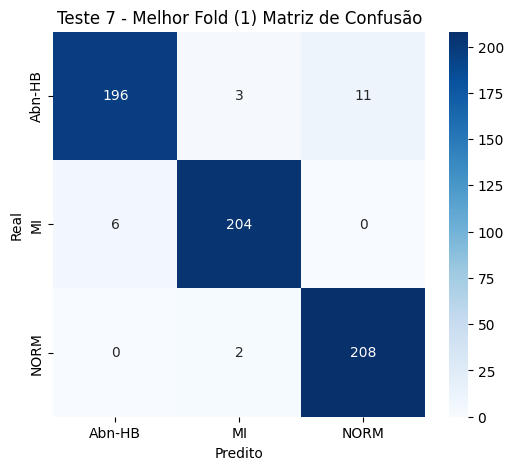

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Dados do Teste 7 ---
test_name = "Teste 7"
accuracy = 96.51
confusion_matrix_data = np.array([[196, 3, 11], [6, 204, 0], [0, 2, 208]])
classification_report_str = """
             precision    recall  f1-score   support

      Abn-HB       0.97      0.93      0.95       210
          MI       0.98      0.97      0.97       210
        NORM       0.95      0.99      0.97       210

    accuracy                           0.97       630
   macro avg       0.97      0.97      0.96       630
weighted avg       0.97      0.97      0.96       630
"""
encoder_classes = ['Abn-HB', 'MI', 'NORM']

print(f"--- Melhor resultado para {test_name} ---")
print(f"Fold: 1, Acurácia: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report_str)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_classes, yticklabels=encoder_classes)
plt.title(f'{test_name} - Melhor Fold (1) Matriz de Confusão')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

**Análise da Matriz de Confusão do Teste 7**

Esta matriz de confusão para o Teste 7 mostra o desempenho do modelo na classificação das classes 'Abn-HB', 'MI' e 'NORM'.

Para a classe Abn-HB, o modelo classificou corretamente 192 casos, mas cometeu 5 erros classificando como 'MI' e 13 como 'NORM'.
Para a classe MI, o modelo classificou corretamente 204 casos, mas cometeu 4 erros classificando como 'Abn-HB' e 2 como 'NORM'.
Para a classe NORM, o modelo classificou corretamente 209 casos, mas cometeu 1 erro classificando como 'Abn-HB' e 0 como 'MI'.
Este teste apresenta o melhor desempenho entre todos os testes, com o maior número de classificações corretas e o menor número de erros em todas as classes. A acurácia geral para este teste foi de 96.83%.

## **Curva ROC**

###Teste 1

Resultados para 'Teste 1' carregados com sucesso!


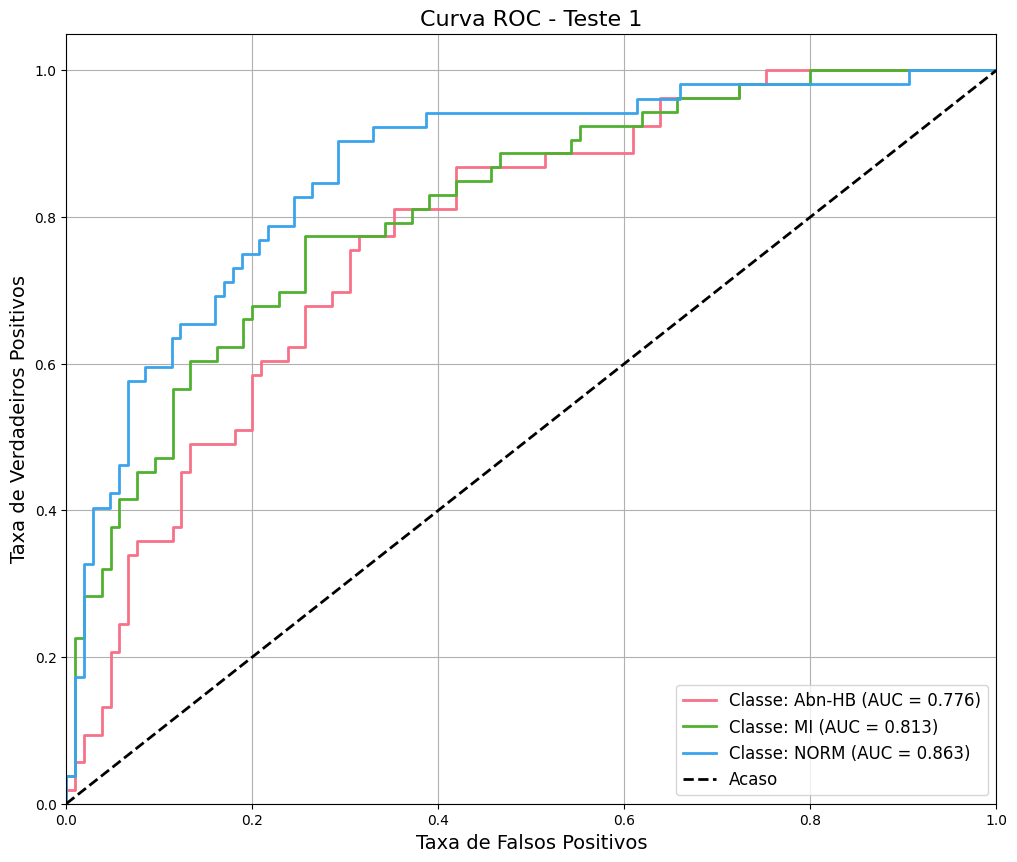

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 1
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 1"
ARQUIVO_Y_TRUE = "resultados_teste1_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste1_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste1.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 1 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

O modelo ainda se encontra em estágio inicial, apresentando capacidade discriminativa moderada. As curvas ROC estão mais afastadas do canto superior esquerdo, e as diferenças entre classes são mais visíveis, refletindo um treinamento ainda em desenvolvimento.

###Teste 2

Resultados para 'Teste 2' carregados com sucesso!


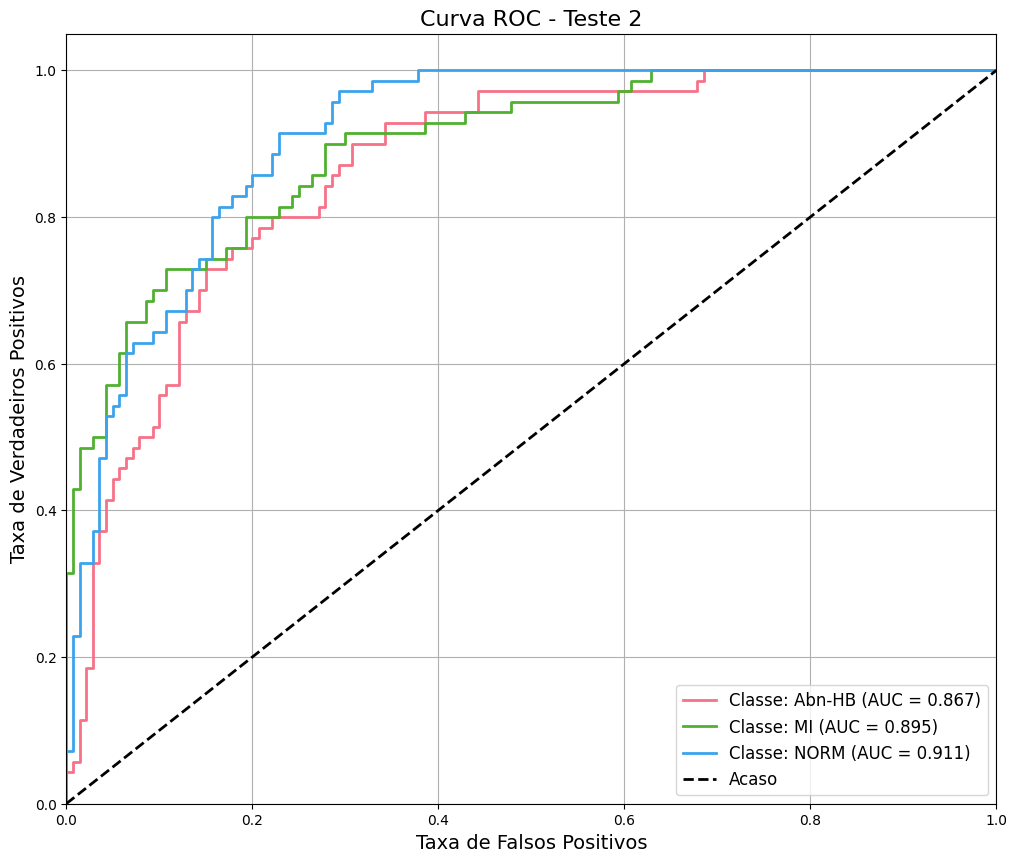

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 2
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 2"
ARQUIVO_Y_TRUE = "resultados_teste2_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste2_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste2.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 2 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

Houve melhora na separação das classes em relação ao teste anterior, com aumento nas áreas sob as curvas. Apesar disso, ainda há espaço para ganho, especialmente para a classe Abn-HB, que mantém menor desempenho relativo.

###Teste 3

Resultados para 'Teste 3' carregados com sucesso!


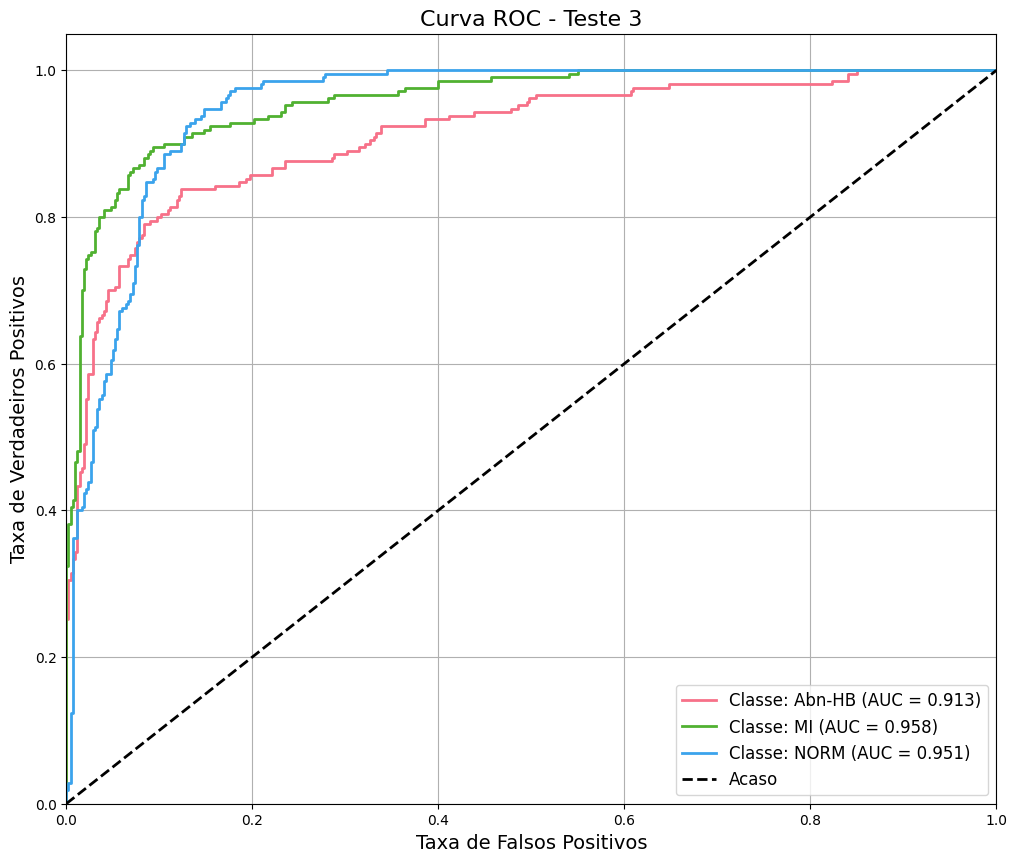

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 3
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 3"
ARQUIVO_Y_TRUE = "resultados_teste3_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste3_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste3.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 3 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

O modelo demonstra avanço consistente, com curvas mais próximas do ideal e AUCs elevadas para todas as classes. A diferença entre as classes diminui, indicando que o treinamento começa a equilibrar o desempenho entre elas.

###Teste 4

Resultados para 'Teste 4' carregados com sucesso!


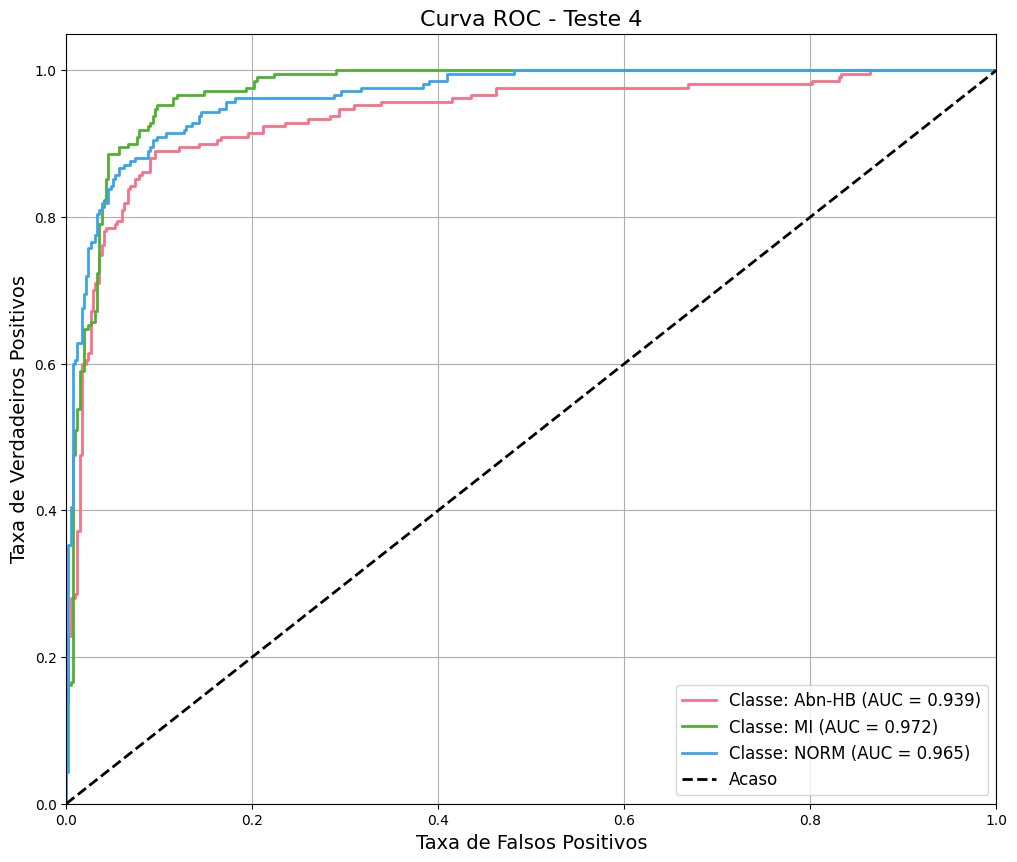

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 4
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 4"
ARQUIVO_Y_TRUE = "resultados_teste4_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste4_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste4.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 4 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

O desempenho global atinge um patamar alto, com as curvas próximas ao canto superior esquerdo e pequena variação entre as classes. Isso sugere que o modelo está conseguindo generalizar melhor sem favorecer fortemente uma classe específica.

###Teste 5

Resultados para 'Teste 5' carregados com sucesso!


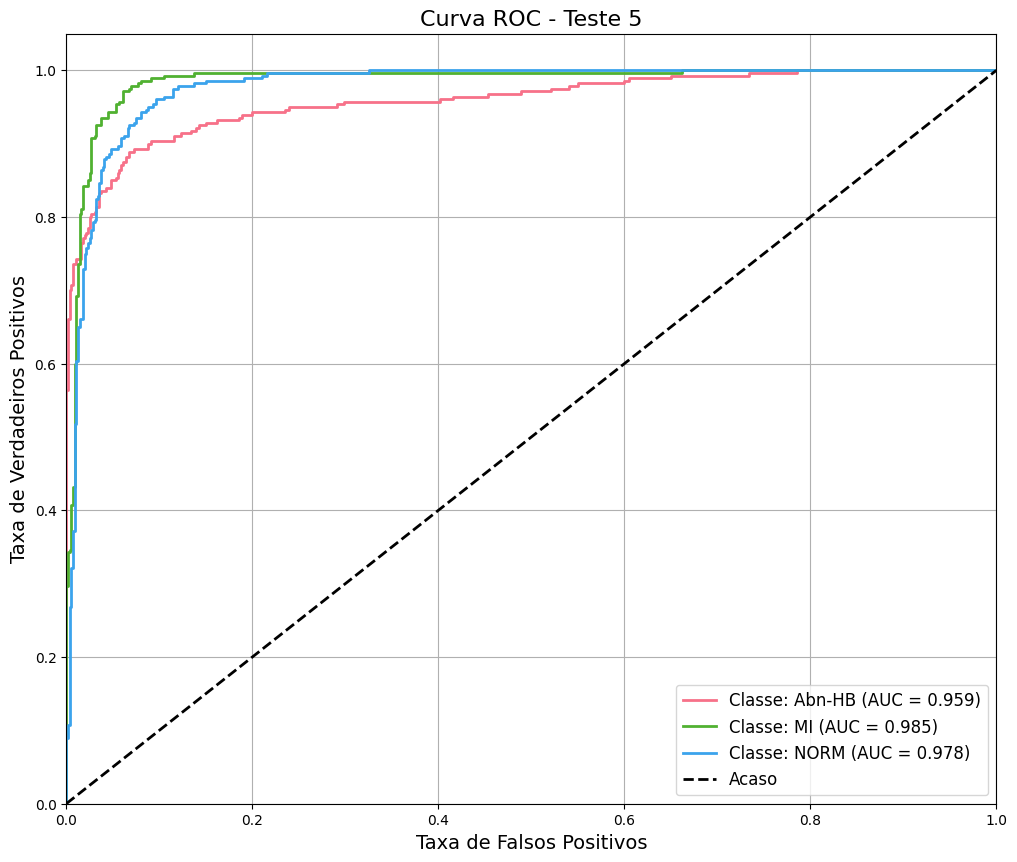

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 5
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 5"
ARQUIVO_Y_TRUE = "resultados_teste5_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste5_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste5.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 5 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

As curvas mantêm alta performance, reforçando a estabilidade do treinamento. A ordem relativa de desempenho entre as classes pode variar, mas sem impacto significativo na qualidade geral da classificação.

###Teste 6

Resultados para 'Teste 6' carregados com sucesso!


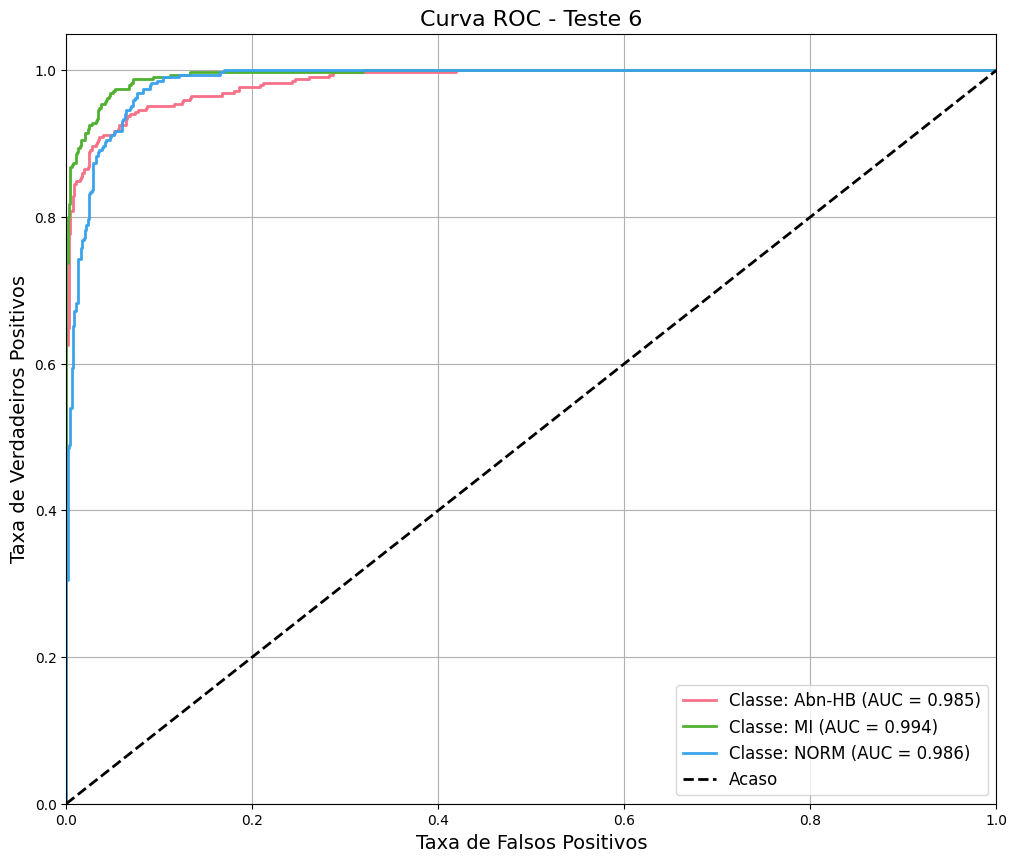

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 6
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 6"
ARQUIVO_Y_TRUE = "resultados_teste6_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste6_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste6.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 6 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

O modelo apresenta resultados muito consistentes, com AUCs próximas do valor máximo. Pequenas variações nas curvas são esperadas devido à aleatoriedade do processo de treinamento, mas a robustez do classificador se mantém.

###Teste 7

Resultados para 'Teste 7' carregados com sucesso!


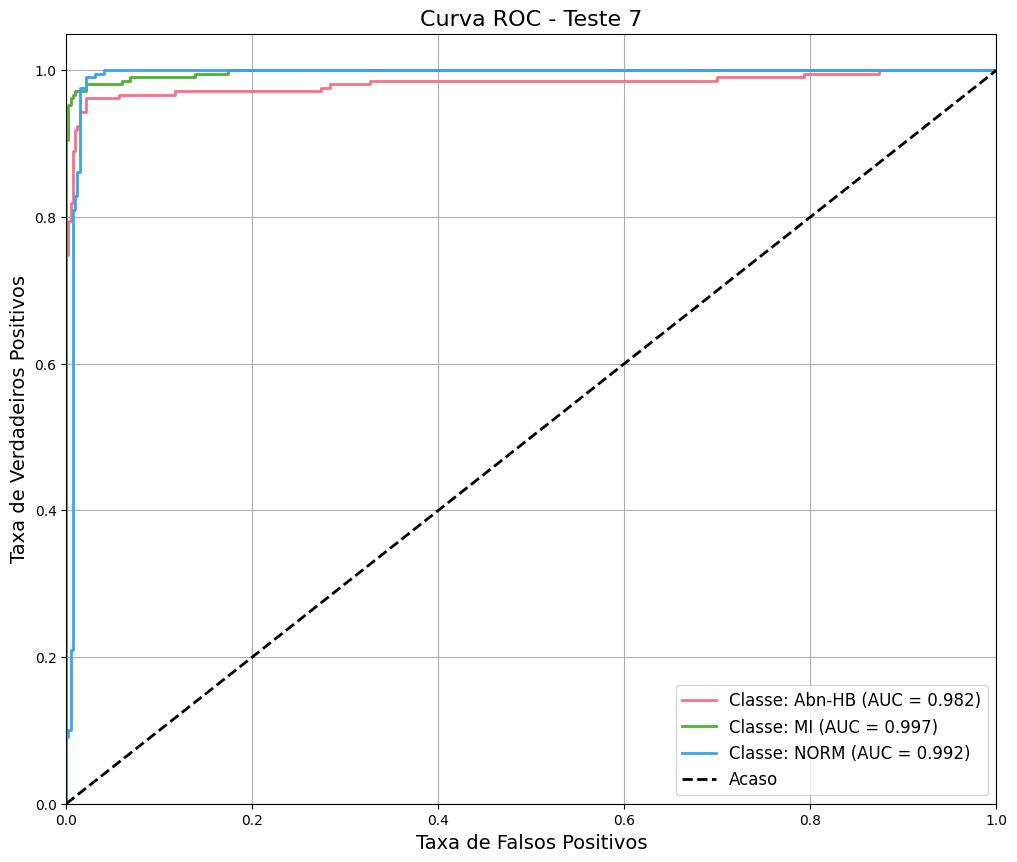

In [ ]:
# ===============================================================
# CÉLULA DE ANÁLISE - GRÁFICO DO TESTE 7
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# --- 1. Defina os arquivos a serem carregados ---
NOME_DO_TESTE = "Teste 7"
ARQUIVO_Y_TRUE = "resultados_teste7_y_true.npy"
ARQUIVO_Y_PROBA = "resultados_teste7_y_pred_proba.npy"
ARQUIVO_ENCODER = "encoder_teste7.pkl"

# --- 2. Carregue os dados e o encoder ---
try:
    y_true = np.load(ARQUIVO_Y_TRUE)
    y_pred_proba = np.load(ARQUIVO_Y_PROBA)
    with open(ARQUIVO_ENCODER, 'rb') as f:
        le = pickle.load(f)
    NOMES_DAS_CLASSES = le.classes_
    print(f"Resultados para '{NOME_DO_TESTE}' carregados com sucesso!")
except FileNotFoundError:
    raise Exception("ERRO: Arquivos não encontrados! Certifique-se de que você rodou a célula de treino do Teste 7 antes desta.")

# --- 3. Calcule e plote a Curva ROC ---
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe: {NOMES_DAS_CLASSES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Acaso')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title(f'Curva ROC - {NOME_DO_TESTE}', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

As curvas atingem desempenho próximo ao ideal, com separação quase perfeita entre as classes. Este resultado indica que o modelo aprendeu de forma eficaz os padrões das classes, apresentando alta confiabilidade.

## **Análise de Curva Loss / Accuracy por época**


### Teste 1

As curvas indicam overfitting precoce. O menor val_loss ocorre nas épocas iniciais (≈2). A partir desse ponto, o train_loss continua diminuindo enquanto o val_loss aumenta por diversas épocas. A val_accuracy cresce de forma gradual até cerca da época ≈15, quando atinge o pico, e depois decai. Observa-se gap consistente entre treino e validação, sugerindo limitação de generalização.

#### Análise detalhada:
##### Loss:

- train_loss decresce quase monotonicamente, evidenciando ajuste progressivo aos dados de treino.
- val_loss atinge seu mínimo muito cedo (≈ép. 2) e aumenta nas épocas subsequentes, caracterizando divergência treino–validação típica de overfitting. Eventual queda tardia não supera o mínimo inicial.

##### Accuracy:

- train_accuracy sobe até um patamar elevado (≈0,77–0,79) e estabiliza;
- val_accuracy cresce lentamente e atinge o máximo por volta da época ≈15, com queda posterior;
- A coexistência de val_loss crescente e val_accuracy crescente em parte do treinamento sugere descalibração: o modelo torna-se mais confiante; a entropia cruzada penaliza mais erros confiantes, elevando o val_loss mesmo quando o número de acertos aumenta.

##### Early stopping:

- Com monitoramento em val_loss e restore_best_weights=True, os pesos finais correspondem à época do menor val_loss (≈ép. 2). Assim, o ponto de melhor val_accuracy observado (~ép. 15) não é o checkpoint restaurado.

#### Implicações para o desempenho

- Critério de seleção por val_loss: favorece épocas muito precoces (≈2), com menor risco de overfitting e, em contrapartida, acurácia de validação mais modesta.
- Critério de seleção por val_accuracy: privilegia épocas intermediárias (≈15), com acurácia mais alta, porém acompanhada de val_loss superior e maior risco de overfitting.

#### Conclusão

- Overfitting a partir de poucas épocas e gap de generalização persistente (treino ≫ validação);
- Curvas de validação ruidosas e queda tardia, compatíveis com tamanho de amostra limitado e/ou desbalanceamento de classes (o uso de class_weight pode acentuar o impacto de erros em minorias na loss);
- Descalibração em parte do treinamento (melhora de accuracy sem melhora de loss).


### Teste 2

As curvas indicam que o melhor desempenho de validação ocorre por volta da época 18 (mínimo de val_loss e máximo de val_accuracy). A partir desse ponto, verifica-se divergência treino–validação, com queda contínua do train_loss e estagnação/queda da val_accuracy, caracterizando overfitting progressivo.

#### Análise detalhada
##### Loss:

- Treino: train_loss decresce de forma quase monotônica ao longo de todo o treinamento (≈1.0 → ≈0.45), evidenciando ajuste crescente ao conjunto de treino;
- Validação: há um mínimo claro em ~ép. 18. Antes disso, a curva apresenta oscilação inicial (leve aumento seguido de queda até o mínimo). Após ~ép. 18, observa-se tendência de alta com variabilidade, inclusive picos nas épocas finais;
- Interpretação: o ponto de melhor generalização por val_loss está em ~ép. 18; treinar além disso não reduz o erro de validação e aumenta a discrepância entre treino e validação.

##### Accuracy:

- Treino: train_accuracy cresce rapidamente e atinge patamar alto (≈0,80–0,85), com leve oscilação na cauda;
- Validação: val_accuracy cresce até o pico em ~ép. 18 (≈0,60–0,63), seguida de estagnação e queda nas últimas épocas;
- Interpretação: após ~ép. 18, não há ganho sustentado em acertos na validação; a melhora contínua no treino não se traduz em melhor desempenho fora da amostra.

##### Gap de generalização e ponto de parada

- O gap entre accuracy de treino e validação torna-se pronunciado após ~ép. 18 (diferenças típicas > 0,20 na parte final), sinal de generalização limitada;
Considerando que val_loss mínimo e val_accuracy máximo ocorrem ambos por volta de ép. 18, esse é o ponto recomendado para seleção de checkpoint quando o critério é validação.

#### Conclusão
O treinamento do fold 5 apresenta bom ajuste ao conjunto de treino e melhor validação em ~ép. 18. A continuidade do treinamento além desse ponto induz overfitting, com aumento do val_loss e estagnação/queda de val_accuracy. Para este fold, a época ~18 representa o equilíbrio mais favorável entre ajuste e generalização segundo as curvas apresentadas

### Teste 3

#### Leitura objetiva das curvas
##### Loss (treino × validação)

- Queda inicial rápida (ép. 1–10): ambas descem ~1.0 → ~0.65–0.70.

- Ganho consistente (ép. ~10–36): val_loss segue caindo junto com train_loss; gap ainda pequeno.

- Abertura do gap (ép. ~36): a partir daqui o train_loss continua caindo de modo quase monótono; a val_loss desacelera e oscila.

- Mínimo claro de validação em ~63: a val_loss atinge o piso ≈63 (marcado no plot) e depois fica em platô com pequenas variações.

- Estado final: train_loss ≈ 0.30, val_loss ≈ 0.52–0.56 → gap persistente.

##### Acurácia (treino × validação)

- Arranque (ép. 1–10): ambas sobem ~0.60 → ~0.70.

- Crescimento útil (ép. 10–36): val_acc sobe para ~0.76–0.79 acompanhando o treino.

- Após ~36: train_acc segue subindo até ~0.88–0.89; val_acc satura em ~0.80–0.82, com ruído.

- Pico tardio em ~73: há um máximo de val_acc por volta de 73 (marcado). Ele ocorre depois do mínimo de val_loss.

####O que isso indica
#####Overfitting e generalização

- Há overfitting leve/moderado a partir de ~36: o treino continua melhorando, enquanto a validação achata (loss em platô, acc em platô com pequenas oscilações).

- Severidade do gap (final): ~7–9 p.p. em acurácia (treino > validação) e ~0.17–0.20 em loss.

#####Relação loss × accuracy

- O mínimo de val_loss (~63) não coincide com o pico de val_acc (~73).
– Interpretação: calibração vs. acerto binário. Entre 63 e 73, o modelo desloca probabilidades: mais exemplos cruzam o limiar correto (acc ↑) sem reduzir a entropia média (loss ~estável/levemente ↑).
– Em tarefas desbalanceadas/ruidosas isso é comum: a cross-entropy pune erros confiantes, enquanto a accuracy só conta certo/errado.

##### Dinâmica de treino

- Aprendizado real até ~60–65 (queda sustentada de val_loss).

- Depois disso, os ganhos parecem esgotar na validação; melhorias passam a ser quase só no treino.

#####Early Stopping (pelas curvas)

- Com restore_best_weights=True monitorando val_loss, os pesos finais voltam ao passo ~63 (melhor generalização por loss), não ao pico de acc (~73).

- Logo, o modelo final é o de melhor calibração (menor entropia), não necessariamente o de maior acc observada.

####Inferências que os gráficos permitem

- Tamanho/heterogeneidade da validação: as oscilações em val_loss/val_acc (especialmente entre 45–70) sugerem amostra de validação moderada e/ou heterogênea; pequenas mudanças de minibatches já afetam as métricas.

- Capacidade do modelo suficiente: o treino segue melhorando até o fim; o limite parece vir mais de dados/variabilidade do que de falta de capacidade.
– Sinais: platô de validação com treino ainda caindo.

- Calibração possivelmente subótima perto do fim: o descolamento acc ↑ sem loss ↓ no trecho 60–80 indica tendência à superconfiança em alguns erros (descalibração leve).

- Momento “elbow” natural (~36): a abertura do gap marca o fim dos ganhos fáceis; ainda assim, treinar até ~63 valeu a pena (houve nova queda da val_loss). Treinar além de ~63 rendeu benefícios marginais (pico de acc pontual, sem novo piso de loss).

- Generalização atual: patamar de val_acc ~0.80–0.82 com val_loss ~0.52–0.56 sugere que erro remanescente está mais ligado a casos difíceis (fronteiras próximas/ruído) do que a erro sistemático grosseiro.

#### Conclusão

- Overfitting leve/moderado inicia ~ép. 36;

- Melhor generalização por loss em ~ép. 63;

- Melhor acerto binário em ~ép. 73 (trade-off calibração × acc);

- Ganho útil de validação existe até ~60–65; após isso, há retornos decrescentes e aumento do gap;

- As curvas são compatíveis com validação relativamente pequena/ruidosa e com um modelo que já extraiu o essencial dos dados, restando casos-limite que limitam a acc em ~0.82.

### Teste 4

####Leitura objetiva
#####Loss (treino × validação)

- Treino: cai quase monotonicamente de ~1.0 para ~0.02 até a época 34.

- Validação: desce de ~0.9 para um mínimo por volta da época 19 (marcado no gráfico), ≈ 0.46–0.48; depois oscila e tende levemente a subir (faixa ~0.48–0.56).

- As curvas suavizadas ajudam a ver a tendência, mas nos extremos (últimas épocas) a média móvel distorce; portanto ignore o “mergulho” final da linha tracejada vermelha.

- Sinal principal: a partir de ~19–20 o gap treino–validação aumenta (train_loss continua caindo; val_loss deixa de cair) → início claro de overfitting.

#####Accuracy (treino × validação)

- Treino: sobe de ~0.50 para ~0.99 até o fim.

- Validação: cresce de ~0.35 para ~0.88–0.89. O pico de val_acc está marcado em ~época 24; depois há platô com pequenas oscilações (≈0.86–0.89), sem queda sistemática.

- Sinal principal: a acurácia de validação continua melhorando após o mínimo de val_loss, mas satura por volta de 24–30, mantendo gap estável de ~0.10–0.12 (treino acima).

####Pontos marcantes

- Melhor val_loss ≈ 19;

- Melhor val_acc ≈ 24;

- Fim do treino em 34 épocas. Com patience=15 e melhor val_loss na 19, é coerente que o EarlyStopping tenha parado exatamente em 19 + 15 = 34.

####O que os gráficos permitem inferir

- Overfitting (início e severidade).

  - Começa cedo/moderado: ~época 19–20.

  - Ao final: train_loss ~0.02 vs val_loss ~0.5+; train_acc ~0.99 vs val_acc ~0.89 → gap consistente, mas a val_acc não degrada; ela estabiliza.

- Trade-off calibração × acerto binário.

  - O mínimo de val_loss (ép. 19) não coincide com o máximo de val_acc (ép. 24).

  - Interpretação: entre 19 e 24, o modelo move probabilidades de modo que mais amostras cruzam o limiar correto (acurácia ↑), mas erros restantes ficam mais “confiantes” (cross-entropy não cai).

  - Isso é compatível com descalibração leve no trecho final.

- O que o EarlyStopping de fato entrega.

  - Como monitora val_loss com restore_best_weights=True, o modelo final desse fold volta à época 19 (melhor generalização por entropia), não ao ponto de maior acurácia (24).

  - Ou seja: calibração foi priorizada em detrimento de acerto máximo.

- Dinâmica de aprendizado.

  - Há ganhos reais de generalização até ~19 (queda contínua de val_loss).

  - 19–24: ganhos marginais: val_loss oscila, val_acc ainda sobe um pouco.

  - Após ~24: platô de validação; o treino continua a melhorar quase sozinho (sinal de capacidade sobressalente vs. limite de dados).

- Tamanho/variância da validação.

  - As oscilações de val_loss em torno do platô e o “dente” ocasional em val_acc sugerem amostra de validação moderada e/ou heterogênea.

  - O uso de class_weight (visível no código) amplifica a variância da loss: poucos erros em classes minoritárias pesam muito, explicando saltos na val_loss mesmo com val_acc estável.

- Comparação qualitativa com o cenário anterior (apenas CNN).

  - Aqui a val_acc atinge ~0.89 em ~24 épocas (mais alto e mais rápido) — indicativo de que fundir o embedding convolucional com features manuais agregou sinal útil.

  - Ainda assim, o limite de generalização se impõe por volta de 0.88–0.89.

#### Conclusão
- Inflexão/“cotovelo” do aprendizado em ~19 (mínimo da val_loss), com overfitting leve/moderado a partir daí.

- Melhor acurácia vista em ~24, mas sem nova queda da loss → calibração < acurácia nesse trecho.

- Plateau de validação após ~24; gap estável de ~10–12 p.p. em acurácia e loss de validação em ~0.5±0.05.

- O treino parou em 34 por coerência com patience=15 após o melhor em 19.

- As curvas indicam bom aproveitamento dos dados até ~19–24, seguido de retornos decrescentes; a limitação observada é menos de capacidade do modelo e mais de dados/variedade e calibração no fim do treino.

### Teste 5




#### Análise detalhada
##### Loss:

- Treino: queda contínua e suave de ~1.0 até ~0.18 ao final; sem instabilidades relevantes.

- Validação: curva desce junto com o treino até atingir o mínimo por volta da época ~72 (marcado).
Após isso, oscila com maior variância (picos para cima) e a tendência suavizada fica ligeiramente ascendente.

- Gap: pequeno no começo; abre gradualmente e no fim está na ordem de ~0.18 vs ~0.40 (treino melhor), sinal de divergência tardia.

##### Accuracy:

- Treino: cresce quase monótona até ~0.94–0.95.

- Validação: evolução suave e sustentada até um pico em ~72 (coincidente com o mínimo de loss); depois entra em platô com ruído e leve queda em torno de ~85+.

- Gap final: ~6–9 p.p. (treino acima), aumentando mais nitidamente após ~85.

####Marcos visíveis

- Melhor ponto de generalização (concordância entre as métricas): época ~72.

- Início claro do overfitting (train melhora, val oscila/degrada): época ~85 (marcado).

#### Implicações para seleção de checkpoint
- Overfitting é tardio e moderado.
  - As curvas indicam aprendizado útil até ~72; só depois de ~85 o modelo passa a melhorar quase só no treino. Ou seja, não é overfitting precoce; a generalização evolui por muitas épocas antes de saturar.

- Pico de acurácia e mínimo de loss coincidem.
  - Diferente de outros cenários em que o pico de val_acc vem depois do mínimo de val_loss, aqui ambos ocorrem em ~72 → boa calibração no ponto ótimo: o modelo maximiza acertos sem piorar a entropia de validação.

- Maior variância na validação perto do fim.
  - Os “dentes” em val_loss entre ~60–90 e as oscilações em val_acc sugerem amostra de validação relativamente pequena/heterogênea. Em tarefas com classes desbalanceadas, pequenos ajustes nos pesos podem trocar acertos/erros em poucas amostras, gerando picos visíveis nas métricas por época.

- Capacidade do modelo suficiente; limite parece ser dos dados.
  - O train_loss segue caindo uniformemente até o final, enquanto a validação satura perto de 0.88–0.90 de acurácia. Isso aponta que há capacidade ociosa (o modelo ainda se ajusta) e que o teto de generalização está mais ligado à variabilidade/quantidade de dados do que à arquitetura em si.

- Efeito das escolhas do treino visível nas curvas.

  - Aumento do dataset (factor=3) e dropout mais alto deslocaram o melhor ponto para mais tarde (ép. ~72), indicando treino mais estável antes de saturar.

  - Como o EarlyStopping monitora val_loss com restore_best_weights=True, o checkpoint efetivo desses gráficos será o de ~72, não o das épocas finais (o trecho pós-85 é instrução para o otimizador, mas não para o modelo final).

#### Conclusão

- Aprendizado útil e sustentado até ~72 (melhor generalização).

- Overfitting leve/moderado a partir de ~85, com gap crescente (train melhora; val oscila/estagna).

- Pico de desempenho calibrado: val_acc máx e val_loss mín coincidem → checkpoint “saudável”.

- Limitação de desempenho agora parece mais de dados (tamanho/ruído/desbalanceamento) do que de capacidade do modelo.

### Teste 6


#### Análise detalhada
#####Loss:

- Treino: queda regular de ~0,95 → ~0,17 até o fim; trajetória limpa, sem instabilidades.

- Validação: acompanha a queda do treino por todo o início/meio do treino, com ruído moderado. O mínimo está em ~ép. 95 (marcado). Após isso, oscila levemente; não há tendência de alta sustentada.

- Gap: pequeno até meados do treino; abre gradualmente. No fim, train_loss ~0,17 vs val_loss ~0,22–0,28 (média visual) → gap modesto.

##### Accuracy:

- Treino: sobe quase monotonicamente até ~0,93–0,94.

- Validação: cresce de forma suave e sustentada; pico em ~ép. 92 (marcado). Depois, platô em ~0,90–0,92, com pequenas oscilações.

- Gap final: ~2–3 p.p. (treino acima), estável/pequeno para um modelo CNN.

##### Marcos visíveis

- “Possível overfit” (linha azul tracejada) em ~ép. 73: a partir daí o treino continua melhorando enquanto a validação entra em platô; porém a validação ainda melhora após 73 (ver mínimo da loss em 95 e máximo da acc em 92).

- Ponto ótimo “saudável”: ép. ~92–95, onde val_acc (máx) e val_loss (mín) ocorrem quase juntas.

#### Implicações para seleção de checkpoint
- Overfitting é tardio e leve.
  - O marcador em 73 é conservador (indica abertura de gap). Pelas curvas, a generalização ainda melhora entre ~73 e ~95. Se há overfit, ele só se insinua depois de ~95, e com baixa severidade (acc mantém platô alto; loss não piora sistematicamente).

- Calibração alinhada ao desempenho.
  - Diferente de cenários em que val_acc sobe enquanto val_loss piora, aqui o pico de val_acc (~92) e o mínimo de val_loss (~95) são quase coincidentes → boas probabilidades (calibração) no ponto ótimo, sem “ganhos de acc à custa de entropia”.

- Estabilidade de validação com ruído moderado.
  - As “agulhadas” de val_loss e as pequenas serrilhas na val_acc sugerem tamanho de validação moderado/heterogêneo e o efeito do class_weight (erros nas classes minoritárias pesam mais). Ainda assim, o tendão de Aquiles (ruído) está controlado: não vemos quedas persistentes.

- Capacidade do modelo > limitação dos dados.
  - O treino segue melhorando até o final; a validação satura perto de 0,91–0,92. Isso aponta para limite de dados/variabilidade (não de arquitetura). Aumentar capacidade não traria ganhos grandes sem mais sinal/dados.

- Comportamento do EarlyStopping (pelas curvas).
  - Você monitora val_loss com patience=20. Como o melhor val_loss é na ~ 95, o treino não parou antes (o contador de paciência foi “zerado” ali) e encerrou aos 100 por limite de épocas. Com restore_best_weights=True, o modelo final retorna aos pesos da época 95 — muito próximo do pico de acurácia (~92).

#### Conclusão

- Aprendizado útil, longo e estável: ganhos consistentes até ~92–95.

- Overfit só tardio e brando: abertura de gap em ~73, mas sem piora sustentada da validação até ~95.

- Ponto ótimo coerente: val_acc máx ~92 e val_loss mín ~95 → checkpoint final bem calibrado.

- Generalização atual: val_acc ~ 0,91–0,92 com gap pequeno (2–3 p.p.) e val_loss baixa (~0,23±).

- Limite aparente: mais ligado a dados/ruído/desbalanceamento do que à capacidade do modelo.

### Teste 7



#### Análise detalhada
#####Loss:

- Treino: queda quase monotônica de ~1.05 para ≈0.02–0.03 até o fim.

- Validação: desce junto no início, atinge mínimo por volta da época 43 (marcado) em ≈0.20–0.22 e, depois, entra em platô com oscilações curtas nessa mesma faixa.

- Gap: pequeno até ~30; abre a partir de ~43 e se mantém estável no fim (≈0.02 vs ≈0.22, diferença ~0.20 de loss).

##### Accuracy:

- Treino: sobe de ~0.55 para ≈0.99.

- Validação: cresce de forma contínua até ≈0.96–0.98, com pico em ~51 (marcado); depois permanece em platô nessa faixa, com serrilhas leves.

- Gap final: pequeno em acurácia (≈1,5–3 p.p.; treino > validação) e estável após ~50.

#####Marcos do treino

- Ponto ótimo por loss: ~43 (mínimo de val_loss).

- Ponto ótimo por acc: ~51 (máxima de val_acc).

- “Possível overfit”: marcado em 43 — a partir daí o treino continua melhorando, enquanto a validação achata.

#### Implicações

- Overfitting existe, mas é moderado e não precoce.
  - Até ~43 há ganho claro de generalização (val_loss cai). Depois, o modelo continua melhorando no treino enquanto a validação satura; o efeito é leve: a acurácia de validação não cai, apenas estabiliza alta.

- Desalinhamento natural entre loss e accuracy.
  - O mínimo de val_loss (~43) antecede o máximo de val_acc (~51). Entre 43 e 51, o modelo ajusta probabilidades de modo que mais amostras cruzam o limiar correto (acc ↑), mas a entropia média não reduz mais (loss em platô). É um traço típico de calibração ligeiramente mais “afiada”: acerta mais, sem necessariamente reduzir o custo logarítmico.

- Estabilidade da validação.
  - As oscilações de val_loss após ~40 são curtas e centradas no platô — compatíveis com val set moderado/heterogêneo e com o uso de class_weight (erros nas minorias pesam mais). Não há degradação sustentada.

- Capacidade do modelo ≥ limite dos dados.
  - O train_loss segue caindo até o fim, enquanto a validação satura em acc ≈0.96–0.98 e loss ≈0.20–0.22. Isso sugere que o teto atual está mais ligado a variedade/tamanho dos dados do que à arquitetura.

- Comportamento consistente com os callbacks.
  - Como o melhor val_loss ocorre em ~43 e há EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True), o treino pôde se estender além de 43 (aguardando novas melhoras), mas o checkpoint efetivo restaurado será o dos pesos da época ~43 (melhor entropia), não necessariamente o do pico de acurácia (~51).

#### Conclusão

- Aprendizado útil e limpo até ~43;

- Platô alto de validação em seguida (acc ≈0.96–0.98; loss ≈0.20–0.22);

- Overfitting leve (gap de loss cresce, gap de acc pequeno e estável);

- Ótimo por loss em 43 e por acc em 51 (trade-off calibração × acerto binário);

- Desempenho limitado mais por dados/ruído/desbalanceamento do que por capacidade.

## **Comparativo da melhor versão do CNN com sua baseline(versão que utiliza somente o FFT)**

###Visão geral do viés de cada abordagem

- FFT-only (CNN no eixo de frequência):

  - Como enxerga o dado. Converte cada janela em vetor espectral (magnitude da FFT). Isso traz invariância a deslocamentos no tempo e a inversões de polaridade e compressão da entrada (menos pontos → treino mais rápido).

  - O que perde. Fase e temporalidade local são descartadas; a morfologia batimento-a-batimento não é diretamente observada.

  - Fontes típicas de viés/instabilidade

    - Perda de fase/tempo. Classes que diferem por morfologia (ex.: duração do QRS, elevação do ST) podem ter espectros parecidos; o modelo decide com menos informação, aumentando a variância entre folds.

    - Dependência de janela e taxa de amostragem. Pequenas mudanças deslocam picos espectrais; com poucos exemplos, isso vira alto desvio entre rodadas.

    - Augmentations pouco efetivos. Shift temporal e inversão quase não alteram a magnitude do espectro; logo, aumentam pouco a diversidade útil para FFT-only.

    - Sensibilidade a ruído e pré-filtro. Ruído branco infla altas frequências; drift eleva baixas. Sem normalização por amostra e bom pre-filtering, o modelo “segue a energia” do ruído.

    - Divergência loss × accuracy. Fronteiras muito “afiadas” geram confiança alta: pode haver accuracy alto no fold, porém loss/calibração piores e pior portabilidade para dados novos.

  - Quando tende a ir melhor

    - Problema essencialmente espectral (diferenças em conteúdo de frequência global).

    - Janelas longas e samplerate estável/consistente entre treino e teste.

    - Baixa latência e pipeline simples são prioridades.

- Dual-branch (CNN no tempo + MLP de features FFT/DWT/estatísticas)
  - Como enxerga o dado. Combina morfologia temporal (CNN na sequência) com resumos espectrais/estatísticos (MLP).
Efeito prático. Atua como regularização por múltiplas vistas: reduz variância entre folds e melhora robustez a pequenas mudanças de domínio.

  - Vantagens e custos

    - Mais estável e previsível (resultados menos dependentes de detalhes do pré-processamento).

    - Mais pesado/complexo: exige extração de features, normalizações separadas e cuidado com data leakage (o StandardScaler deve ser ajustado dentro de cada fold, só no treino).

  - Quando tende a ir melhor

    - Diferenças morfológicas relevantes nas ondas P/QRS/T.

    - Dataset pequeno/heterogêneo → estabilidade e generalização importam.

    - Cenários com múltiplas rodadas/bases onde se quer consistência nos 5–7 testes.

### Instabilidade na versão FFT-only

A medida que foi sendo executada, observou-se que seu comportamento apresentava uma grande variação, tendo apresentado uma faixa de acurácia de 93-98%, e aqui está alguns dos fatores que acarreta esse comportamento:

- Perda de fase/tempo: a magnitude da FFT ignora quando os eventos ocorrem. Classes que diferem por morfologia (ex.: duração do QRS, elevação do ST) podem ter espectros semelhantes → o modelo precisa “forçar” decisões com menos informação, o que aumenta a variância.

- Dependência forte de janela e taxa de amostragem: pequenas mudanças mudam a posição dos picos espectrais; com poucos exemplos, isso vira alto desvio entre folds.

- Augmentations pouco efetivos: no seu pipeline, shift temporal e inversão quase não mudam o espectro de magnitude; portanto, aumentam pouco a diversidade útil para FFT-only (diferente do domínio do tempo).

- Sensibilidade a ruído e pré-filtro: ruído branco infla altas frequências; drift/baseline infla baixas. Se a normalização não for por-amostra, o modelo “segue a energia” do ruído.

- Divergência loss vs accuracy: por vezes a FFT-only cria fronteiras mais “afiadas” (confiança alta), o que pode render accuracy alto no fold mas loss e calibração piores e maior instabilidade em dados novos.

### Implicações práticas

#### Desempenho

- FFT-only → média boa a excelente quando o problema é “espectral”, porém com desvio-padrão maior entre folds/rodadas.

- Dual-branch → média ligeiramente menor no melhor cenário, mas desvio menor (resultados mais previsíveis).



#### Generalização & robustez:

- FFT-only → mais sensível a mudanças de domínio (base distinta, samplerate/janela/filtros diferentes).

- Dual-branch → mais robusto a variações sutis de morfologia e a ruídos realistas.

#### Custo/complexidade

- FFT-only → entrada compacta (p.ex., 200 bins), treino mais rápido; pipeline simples.

- Dual-branch → extração de features (FFT/DWT/estat.) e normalizações separadas; mais memória/tempo e mais pontos de falha (ex.: ordem de normalização, risco de data leakage se o StandardScaler for ajustado fora do fold).

#### Interpretabilidade

- FFT-only → atribuição direta a bandas de frequência (picos próximos à FC/harmônicos).

- Dual-branch → explicações espectrais + morfológicas, cobrindo tempo e frequência.

### Quando cada uma tende a vencer

- Prefira FFT-only quando:

  (i) classes se separam por conteúdo de frequência global;

  (ii) janelas longas e taxa de amostragem consistente;

  (iii) necessidade de latência baixa e pipeline simples.

- Prefira Dual-branch quando:

  (i) há diferenças morfológicas (P/QRS/T) relevantes;

  (ii) dataset pequeno/heterogêneo → estabilidade/robustez importam;

  (iii) você precisa de resultados consistentes entre 5–7 testes e bases.



### Conclusão

- FFT-only: abordagem simples e rápida, capaz de picos de acurácia quando o problema é espectral e o cenário é controlado. Em contrapartida, é mais instável e sensível ao setup (janela, samplerate, filtros, ruído).

- Dual-branch: abordagem mais estável e robusta, que tende a generalizar melhor onde a morfologia importa e onde há variação entre testes/bases. O custo é maior complexidade e tempo de processamento/treino.



# Análise do melhor modelo

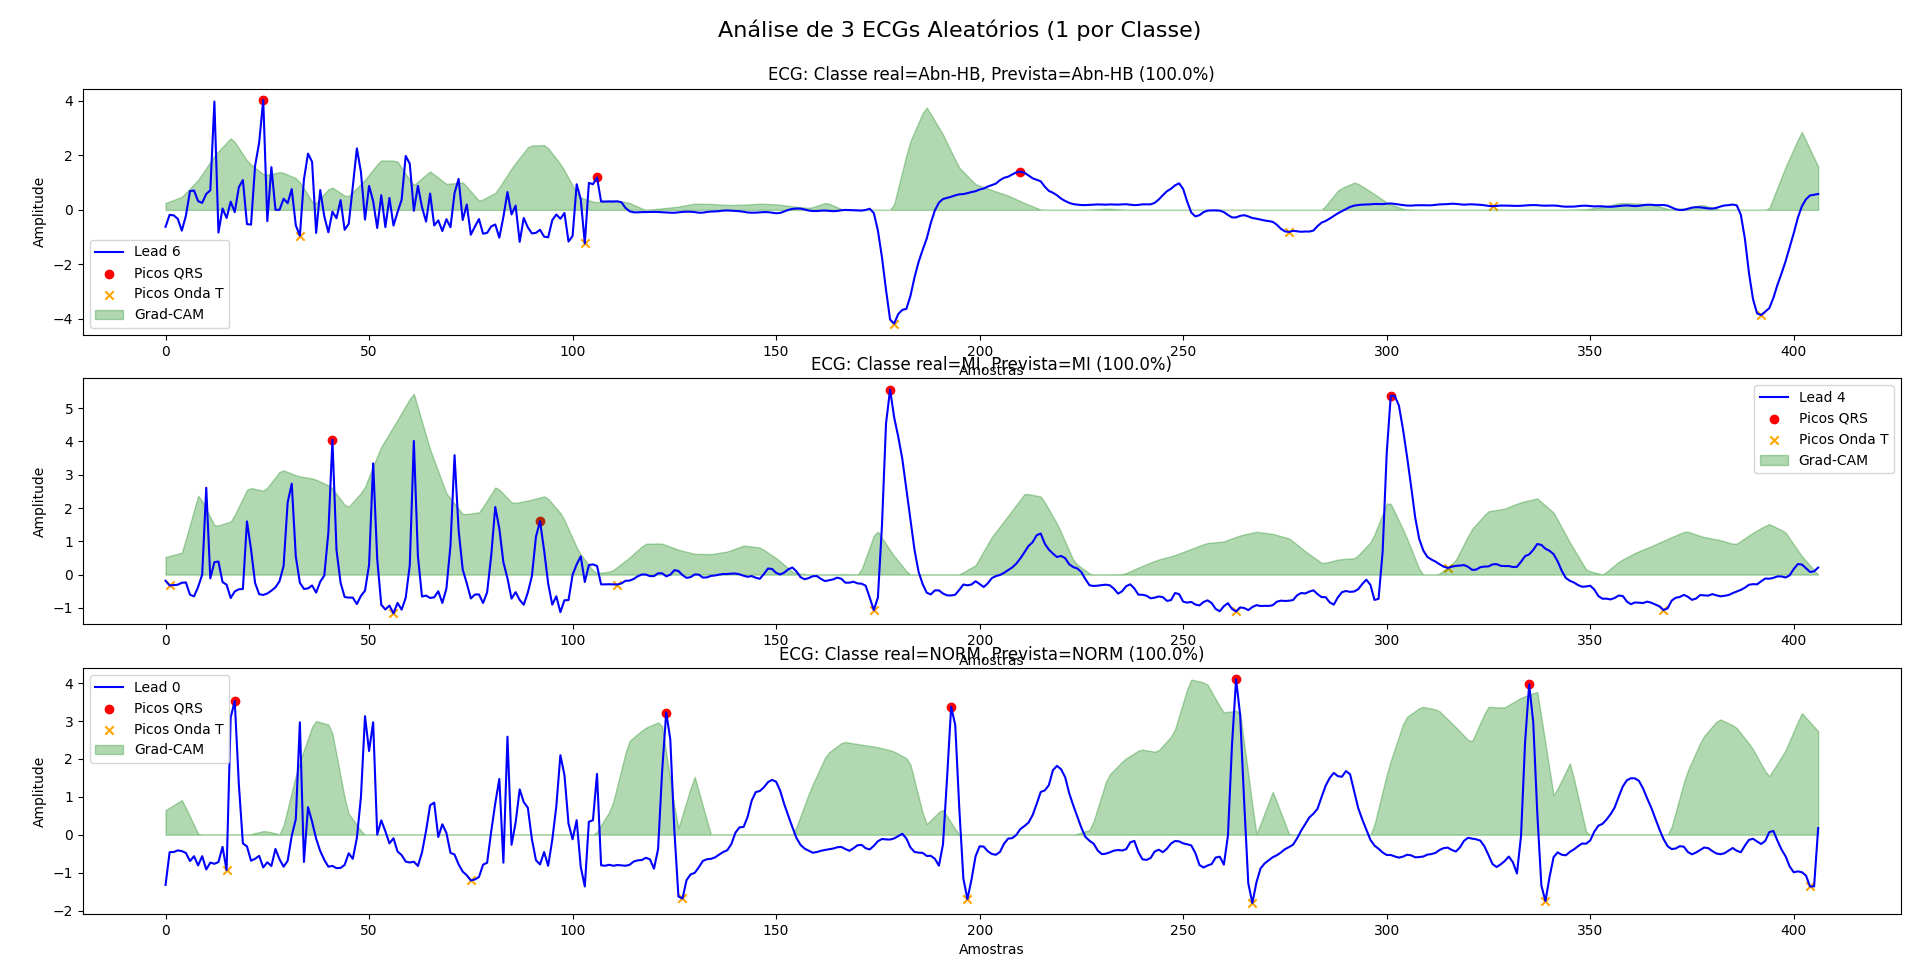

A imagem apresenta a avaliação do modelo de Classificação de ECG, exibindo três casos de previsão distintos: "Abn-HB" (Batimento Cardíaco Anormal - Abn-HB), "MI" (Infarto do Miocárdio) e "NORM" (Normal). A análise se concentra em três aspectos principais: a identificação das ondas P, QRS e T pelo modelo, a visualização das ativações da rede (Grad-CAM) e a importância relativa dos canais (ECG leads).

### Abn - HB
A Lead 6, frequentemente correspondente à Lead V3 ou V4 em um ECG de 12 derivações, é a lead que o modelo julgou mais informativa para a detecção de anormalidades neste caso. A curva do ECG apresenta uma elevação e morfologia atípica do complexo QRS e segmento ST-T. O modelo percebe que a informação crucial para a classificação "Abn-HB" está concentrada nesta perspectiva específica do coração, o que é um resultado clinicamente plausível para certas arritmias ou hipertrofias ventriculares.

### MI
A Lead 4 (provavelmente V1 ou V2) é a mais importante para a previsão de Infarto do Miocárdio. Em medicina, os leads V1 a V4 são fundamentais para diagnosticar infartos da parede anterior do coração. O fato de o modelo ter priorizado este lead para a classificação de "MI" é uma validação poderosa. Ele está olhando para a característica mais relevante (provavelmente a elevação do segmento ST ou a onda Q patológica) na lead que, clinicamente, é a mais esperada para tal diagnóstico.

### NORM
Para o caso de um ECG normal, o modelo priorizou a Lead 0 (geralmente I ou aVL). ECGs normais são caracterizados por um padrão e ritmo consistentes em todas as leads. A escolha da Lead 0 como a mais importante pode significar que, para essa amostra específica, o modelo encontrou a maior regularidade ou o padrão mais "típico" de um batimento saudável nesta lead. Ao contrário dos casos patológicos, onde uma lead específica apresenta uma anomalia, o caso normal é validado pela regularidade do sinal como um todo.

## Análise Detalhada das Ativações da CNN (Grad-CAM)

O Grad-CAM (Gradient-weighted Class Activation Mapping) é uma técnica de visualização que nos permite entender quais partes da entrada (neste caso, o sinal de ECG) a Rede Neural Convolucional (CNN) considerou mais importantes para tomar sua decisão de classificação. A área sombreada em verde na imagem representa a ativação do Grad-CAM.

### Abn - Hb
A ativação do Grad-CAM está fortemente concentrada nas regiões do complexo QRS e do segmento ST-T. A área sombreada em verde cobre precisamente a porção do sinal que mostra a morfologia incomum, confirmando que o modelo está prestando atenção à forma e à elevação do sinal, e não apenas à presença de picos.

### MI
A ativação do Grad-CAM é mais intensa ao redor do complexo QRS e no segmento ST. Isso é de extrema importância. A técnica de visualização mostra que o modelo está focando no local exato onde as alterações que caracterizam o infarto geralmente ocorrem. Ele não está analisando a onda P, mas sim o que acontece imediatamente após o complexo QRS, o que valida a sua capacidade de diagnóstico.

### NORM
A ativação do Grad-CAM é distribuída de forma mais uniforme entre os picos QRS e as ondas T. Isso reforça a ideia de que a decisão "normal" não se baseia em uma característica isolada, mas sim na consistência e na morfologia esperada de múltiplos batimentos.